<a href="https://colab.research.google.com/github/adamgrzanek/car_classification/blob/main/otomoto_damaged_cars_classification_models_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The main goal is to classify cars as damaged or undamaged.

The data comes from car advertisements on otomoto.pl
Damage may be of any type (mechanical, sheet metal, missing parts or equipment).
The seller classifies the car as damaged or undamaged.

Original column names left (Polish)

Classification


, ........ ...........and decision tree were used.

### Contents:
1. [Import libraries](#1)
2. [Loading data and creating a data frame](#2)
3. [Data frame splitting and preprocessing](#3)
4. [EDA (damaged-traning data)](#4)
5. [Classification models](#5)

### <a name='1'></a> Import libraries

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.sparse
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from yellowbrick.model_selection import FeatureImportances

from scipy.stats import shapiro, kstest

In [ ]:
pd.set_option('display.max_columns', None)

# <a name='2'></a> Loading data and creating a data frame

In [ ]:
files = !ls *.csv -l
files

['-rw-r--r-- 1 root root 3396859 Nov 24 10:49 coupe.csv',
 '-rw-r--r-- 1 root root 1887500 Nov 24 10:49 kabrio.csv',
 '-rw-r--r-- 1 root root 6130024 Nov 24 10:49 kombi.csv',
 '-rw-r--r-- 1 root root 5871247 Nov 24 10:49 kompakt.csv',
 '-rw-r--r-- 1 root root 3790778 Nov 24 10:49 male.csv',
 '-rw-r--r-- 1 root root 4237532 Nov 24 10:49 miejskie.csv',
 '-rw-r--r-- 1 root root 5577297 Nov 24 10:49 minivan.csv',
 '-rw-r--r-- 1 root root 4623226 Nov 24 10:49 sedan.csv',
 '-rw-r--r-- 1 root root 5546067 Nov 24 10:49 suv.csv',
 '-rw-r--r-- 1 root root 1215254 Nov 24 10:49 wszystkie_uszkodzone.csv']

In [ ]:
files = [f.split()[-1] for f in files]
files

['coupe.csv',
 'kabrio.csv',
 'kombi.csv',
 'kompakt.csv',
 'male.csv',
 'miejskie.csv',
 'minivan.csv',
 'sedan.csv',
 'suv.csv',
 'wszystkie_uszkodzone.csv']

In [ ]:
Counter(files)

Counter({'coupe.csv': 1,
         'kabrio.csv': 1,
         'kombi.csv': 1,
         'kompakt.csv': 1,
         'male.csv': 1,
         'miejskie.csv': 1,
         'minivan.csv': 1,
         'sedan.csv': 1,
         'suv.csv': 1,
         'wszystkie_uszkodzone.csv': 1})

In [ ]:
all_data_dict = {}
len_df = 0

for car_type in files:
    all_data_dict[car_type] = pd.read_csv(car_type, engine='python')
    print(f'{car_type}, len {car_type} df: {len(all_data_dict[car_type])}')
    len_df += len(all_data_dict[car_type])
    print(40 * '-')

print(f'\nTotal number of rows: {len_df}')

coupe.csv, len coupe.csv df: 1730
----------------------------------------
kabrio.csv, len kabrio.csv df: 1150
----------------------------------------
kombi.csv, len kombi.csv df: 3170
----------------------------------------
kompakt.csv, len kompakt.csv df: 3186
----------------------------------------
male.csv, len male.csv df: 2732
----------------------------------------
miejskie.csv, len miejskie.csv df: 2450
----------------------------------------
minivan.csv, len minivan.csv df: 3082
----------------------------------------
sedan.csv, len sedan.csv df: 2462
----------------------------------------
suv.csv, len suv.csv df: 2732
----------------------------------------
wszystkie_uszkodzone.csv, len wszystkie_uszkodzone.csv df: 1294
----------------------------------------

Total number of rows: 23988


In [ ]:
df = pd.concat([df for df in all_data_dict.values()], axis=0, join='outer', ignore_index=True)
df.head()

Unnamed: 0 Oferta od Pokaż oferty z numerem VIN Ma numer rejestracyjny  \
0          0  Prywatne                        Tak                    Tak   
1          1  Prywatne                        Tak                    Tak   
2          2  Prywatne                        Tak                    Tak   
3          3  Prywatne                        Tak                    Tak   
4          4  Prywatne                        Tak                    Tak   

   Marka pojazdu Model pojazdu                  Wersja Rok produkcji  \
0     Volkswagen        Arteon  2.0 TDI SCR DSG R-Line        2019.0   
1  Mercedes-Benz            CL                  65 AMG        2008.0   
2            BMW            M4     Competition GPF DKG        2017.0   
3           Audi            A5                     NaN        2017.0   
4           Opel         Astra       III GTC 1.6 Sport        2009.0   

     Przebieg Pojemność skokowa                VIN Rodzaj paliwa     Moc  \
0  179 900 km         1 968 cm3  WVWZZZ3HZKE027697        Diesel  190 KM   
1  118 000 km         5 980 cm3  WDDEJ79X18A012374       Benzyna  612 KM   
2   63 800 km         2 979 cm3  WBS4Y91040AC55849       Benzyna  450 KM   
3   81 000 km         1 984 cm3  WAUTNAF54JA036712       Benzyna  251 KM   
4  180 000 km         1 598 cm3  W0L0AHL0895029352       Benzyna  115 KM   

  Skrzynia biegów             Napęd Spalanie W Mieście Typ nadwozia  \
0    Automatyczna  Na przednie koła       5,20 l/100km        Coupe   
1    Automatyczna     Na tylne koła         23 l/100km        Coupe   
2    Automatyczna     Na tylne koła                NaN        Coupe   
3    Automatyczna       4x4 (stały)       7,80 l/100km        Coupe   
4        Manualna  Na przednie koła          8 l/100km        Coupe   

   Liczba drzwi  Liczba miejsc   Kolor Leasing   Kraj pochodzenia  \
0           5.0            5.0   Szary     Tak             Polska   
1           2.0            4.0  Czarny     NaN  Stany Zjednoczone   
2           2.0            4.0   Szary     NaN             Polska   
3           2.0            4.0   Biały     NaN  Stany Zjednoczone   
4           3.0            5.0  Czarny     NaN             Niemcy   

  Data pierwszej rejestracji w historii pojazdu Zarejestrowany w Polsce  \
0                              21 czerwiec 2019                     Tak   
1                                           NaN                     Tak   
2                                 grudzień 2018                     Tak   
3                                           NaN                     Tak   
4                              15 wrzesień 2017                     Tak   

   Pierwszy właściciel (od nowości) Bezwypadkowy Serwisowany w ASO     Stan  \
0                               Tak          Tak               Tak  Używane   
1                               NaN          Tak               NaN  Używane   
2                               NaN          NaN               NaN  Używane   
3                               NaN          NaN               NaN  Używane   
4                               NaN          Tak               NaN  Używane   

       cena                                               opis  \
0  108973.0  Szukasz pewnego samochodu z pełna dokumentacja...   
1  244770.0  INFORMACJE PODSTAWOWE:  MERCEDES CL 65 AMG V12...   
2  310000.0  Do sprzedania BMW M4 Performance Edition 1/40 ...   
3  115000.0  Sprzedam bardzo ładne i zadbane audi A5 coupe....   
4   17500.0  Sprzedam Opla Astre H GTC w wersji po liftingu...   

  Wojewodztwo_sprzedajacego Importowany         Generacja  \
0             Wielkopolskie         NaN               NaN   
1                 Pomorskie         Tak  C216 (2006-2013)   
2                 Lubelskie         NaN               NaN   
3             Wielkopolskie         Tak        F5 (2016-)   
4               Małopolskie         NaN     H (2004-2014)   

  Spalanie Poza Miastem Emisja CO2 Rodzaj koloru Opłata początkowa  \
0                   NaN        NaN           NaN     

In [ ]:
df.shape

(23988, 59)

In [ ]:
df.duplicated().sum()

97

In [ ]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [ ]:
# import library
import dask.dataframe as dd
# read all csv files starting with "df"
dd_df = dd.read_csv("*.csv")

In [ ]:
dd_df

Dask DataFrame Structure:
               Unnamed: 0 Oferta od Pokaż oferty z numerem VIN Ma numer rejestracyjny Marka pojazdu Model pojazdu  Wersja Rok produkcji Przebieg Pojemność skokowa     VIN Rodzaj paliwa     Moc Skrzynia biegów   Napęd Spalanie W Mieście Typ nadwozia Liczba drzwi Liczba miejsc   Kolor Leasing Kraj pochodzenia Data pierwszej rejestracji w historii pojazdu Zarejestrowany w Polsce  Pierwszy właściciel (od nowości) Bezwypadkowy Serwisowany w ASO    Stan     cena    opis Wojewodztwo_sprzedajacego Importowany Generacja Spalanie Poza Miastem Emisja CO2 Rodzaj koloru Opłata początkowa Miesięczna rata Liczba pozostałych rat Wartość wykupu  Tuning Okres gwarancji producenta lub do (przebieg km) Faktura VAT VAT marża Możliwość finansowania Spalanie W Cyklu Mieszanym Gwarancja dealerska (w cenie) Autonomia Średnie zużycie Pojemność baterii Rodzaj własności baterii Kierownica po prawej (Anglik) Zarejestrowany jako zabytek Homologacja ciężarowa
npartitions=10                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
                    int64    object                     object                 object        object        object  object         int64   object            object  object        object  object          object  object             object       object        int64       float64  object  object           object                                        object                  object                            object       object            object  object  float64  object                    object      object    object                object     object        object            object          object                float64         object  object                     object               object     float64   float64                float64                    float64                       float64   float64         float64           float64                  float64                       float64                     float64               float64
                      ...       ...                        ...                    ...           ...           ...     ...           ...      ...               ...     ...           ...     ...             ...     ...                ...          ...          ...           ...     ...     ...              ...                                           ...                     ...                               ...          ...               ...     ...      ...     ...                       ...         ...       ...                   ...        ...           ...               ...             ...                    ...            ...     ...                        ...                  ...         ...       ...                    ...                        ...                           ...       ...             ...               ...                      ...                           ...                         ...                   ...
...                   ...       ...                        ...                    ...           ...           ...     ...           ...      ...               ...     ...           ...     ...          

In [ ]:
dd_df[1].compute()

KeyError: ignored

In [ ]:
dd_df = dd_df.compute()

ParserError: ignored

In [ ]:
df.loc[[21723, 22527]]

Unnamed: 0 Oferta od Pokaż oferty z numerem VIN Ma numer rejestracyjny  \
21723       1782  Prywatne                        Tak                    Tak   
22527         60  Prywatne                        Tak                    Tak   

      Marka pojazdu Model pojazdu          Wersja Rok produkcji   Przebieg  \
21723         Tesla             Y  Long Range AWD        2022.0  16 700 km   
22527         Tesla             Y  Long Range AWD        2022.0  16 700 km   

      Pojemność skokowa                VIN Rodzaj paliwa     Moc  \
21723               NaN  7SAYGAEE0NF346604   Elektryczny  514 KM   
22527               NaN  7SAYGAEE0NF346604   Elektryczny  514 KM   

      Skrzynia biegów        Napęd Spalanie W Mieście Typ nadwozia  \
21723    Automatyczna  4x4 (stały)                NaN          SUV   
22527    Automatyczna  4x4 (stały)                NaN          SUV   

       Liczba drzwi  Liczba miejsc   Kolor Leasing   Kraj pochodzenia  \
21723           5.0            7.0  Czarny     Tak  Stany Zjednoczone   
22527           5.0            7.0  Czarny     Tak  Stany Zjednoczone   

      Data pierwszej rejestracji w historii pojazdu Zarejestrowany w Polsce  \
21723                                  styczeń 2022                     Tak   
22527                                  styczeń 2022                     Tak   

       Pierwszy właściciel (od nowości) Bezwypadkowy Serwisowany w ASO  \
21723                               NaN          NaN               NaN   
22527                               NaN          NaN               NaN   

          Stan      cena                                               opis  \
21723  Używane  239000.0  AUTO SPROWADZONE Z USA  PEŁNA KONWERSJA NA EUR...   
22527  Używane  239000.0  AUTO SPROWADZONE Z USA  PEŁNA KONWERSJA NA EUR...   

      Wojewodztwo_sprzedajacego Importowany Generacja Spalanie Poza Miastem  \
21723                   Łódzkie         Tak       NaN                   NaN   
22527                   Łódzkie         Tak       NaN                   NaN   

      Emisja CO2 Rodzaj koloru Opłata początkowa Miesięczna rata  \
21723        NaN       Metalik               NaN             NaN   
22527        NaN       Metalik               NaN             NaN   

       Liczba pozostałych rat Wartość wykupu Tuning  \
21723                     NaN            NaN    NaN   
22527                     NaN            NaN    NaN   

      Okres gwarancji producenta lub do (przebieg km) Faktura VAT VAT marża  \
21723                        NaN                  NaN         NaN       NaN   
22527                        NaN                  NaN         NaN       NaN   

      Możliwość finansowania Spalanie W Cyklu Mieszanym  \
21723                    NaN                        NaN   
22527                    NaN                        NaN   

      Gwarancja dealerska (w cenie) Autonomia Średnie zużycie  \
21723                           NaN    505 km    16 kWh/100km   
22527                           NaN    505 km    16 kWh/100km   

      Pojemność baterii Rodzaj własności baterii  \
21723               NaN                  W cenie   
22527               NaN                  W cenie   

      Kierownica po prawej (Anglik) Zarejestrowany jako zabytek  \
21723                           NaN                         NaN   
22527                           NaN                         NaN   

      Homologacja ciężarowa Czas ładowania  Unnamed: 0.1 Uszkodzony  \
21723                   NaN            NaN        1761.0        NaN   
22527                   NaN            NaN          59.0        NaN   

      Numer rejestracyjny pojazdu  
21723                         NaN  
22527                         NaN

In [ ]:
#############

In [ ]:
df_raw = df.copy()
df_raw.to_csv('cars_raw.csv', index=False)

In [ ]:
# df = pd.read_csv('cars_raw.csv')
# df.head()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23891 entries, 0 to 23987
Data columns (total 59 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Unnamed: 0                                     23891 non-null  object 
 1   Oferta od                                      23811 non-null  object 
 2   Pokaż oferty z numerem VIN                     23787 non-null  object 
 3   Ma numer rejestracyjny                         15485 non-null  object 
 4   Marka pojazdu                                  23797 non-null  object 
 5   Model pojazdu                                  23802 non-null  object 
 6   Wersja                                         16605 non-null  object 
 7   Rok produkcji                                  23797 non-null  object 
 8   Przebieg                                       23793 non-null  object 
 9   Pojemność skokowa                              234

### Dropping rows without basic data (cena)

In [ ]:
df.dropna(subset=['cena'], inplace=True)

### Reducing data set to cars with price < 500 000 zł

In [ ]:
df['cena']

0        108973.0
1        244770.0
2        310000.0
3        115000.0
4         17500.0
           ...   
23983     42000.0
23984      3300.0
23985      5500.0
23986      4500.0
23987      9900.0
Name: cena, Length: 23793, dtype: object

In [ ]:
# changing data type (some rows raise error)
#df['cena'] = df['cena'].astype(float, errors='raise')

In [ ]:
# checking rows raising errors
df[df['cena'].apply(lambda x: str(x).isalpha())]

Unnamed: 0     Oferta od  \
8533   Powyższa oferta ma charakter informacyjny i n...  Podkarpackie   

     Pokaż oferty z numerem VIN Ma numer rejestracyjny Marka pojazdu  \
8533                        NaN                    NaN           NaN   

     Model pojazdu Wersja Rok produkcji Przebieg Pojemność skokowa  VIN  \
8533           Tak    NaN           Tak      NaN               NaN  NaN   

     Rodzaj paliwa  Moc Skrzynia biegów Napęd Spalanie W Mieście Typ nadwozia  \
8533           NaN  NaN             NaN   NaN               None          NaN   

      Liczba drzwi  Liczba miejsc Kolor Leasing Kraj pochodzenia  \
8533           NaN            NaN   NaN     NaN             None   

     Data pierwszej rejestracji w historii pojazdu Zarejestrowany w Polsce  \
8533                                           NaN                     NaN   

      Pierwszy właściciel (od nowości) Bezwypadkowy Serwisowany w ASO Stan  \
8533                              None          NaN              None  NaN   

     cena opis Wojewodztwo_sprzedajacego Importowany Generacja  \
8533  Tak  NaN                       NaN        None    Polska   

     Spalanie Poza Miastem Emisja CO2 Rodzaj koloru Opłata początkowa  \
8533                  None        NaN           NaN              None   

     Miesięczna rata  Liczba pozostałych rat Wartość wykupu Tuning  \
8533            None                     NaN           None   None   

     Okres gwarancji producenta lub do (przebieg km) Faktura VAT VAT marża  \
8533                       None                 None        None      None   

     Możliwość finansowania Spalanie W Cyklu Mieszanym  \
8533                   None                       None   

     Gwarancja dealerska (w cenie) Autonomia Średnie zużycie  \
8533                          None      None            None   

     Pojemność baterii Rodzaj własności baterii Kierownica po prawej (Anglik)  \
8533              None                     None                          None   

     Zarejestrowany jako zabytek Homologacja ciężarowa Czas ładowania  \
8533                        None                  None           None   

      Unnamed: 0.1 Uszkodzony Numer rejestracyjny pojazdu  
8533           NaN        NaN                         NaN

In [ ]:
defective_rows_idx = df[df['cena'].apply(lambda x: str(x).isalpha())].index
defective_rows_idx

Int64Index([8533], dtype='int64')

In [ ]:
df.drop(index=defective_rows_idx, inplace=True)

In [ ]:
df['cena'] = df['cena'].astype(float, errors='raise')

In [ ]:
df['cena'].dtype

dtype('float64')

<Axes: xlabel='cena', ylabel='Count'>

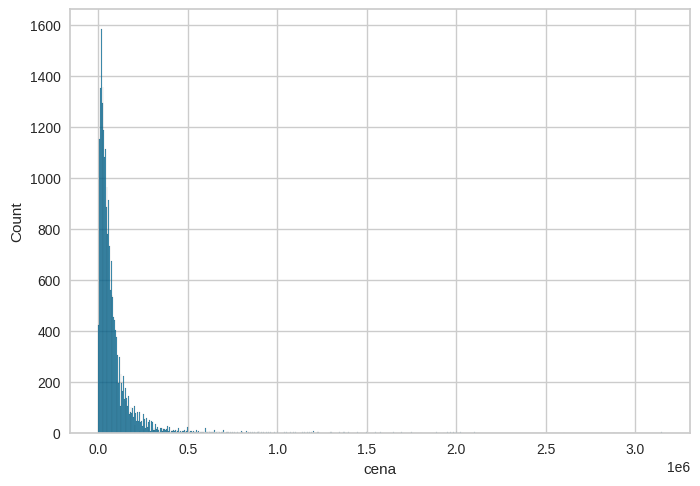

In [ ]:
sns.histplot(df['cena'])

In [ ]:
df[df['cena'] > 500000]

Unnamed: 0 Oferta od Pokaż oferty z numerem VIN Ma numer rejestracyjny  \
8              8  Prywatne                        Tak                    Tak   
26            26  Prywatne                        Tak                    Tak   
65            65  Prywatne                        Tak                    Tak   
140          140  Prywatne                        Tak                    Tak   
188          188     Firma                        Tak                    Tak   
...          ...       ...                        ...                    ...   
22108       2174  Prywatne                        Tak                    NaN   
22201       2278     Firma                        Tak                    NaN   
22383       2466     Firma                        Tak                    NaN   
22414       2497     Firma                        Tak                    NaN   
22549         82  Prywatne                        Tak                    Tak   

       Marka pojazdu Model pojazdu                       Wersja Rok produkcji  \
8      Mercedes-Benz       Klasa C           63 S AMG 9G-TRONIC        2022.0   
26           McLaren    720S Coupe                          NaN        2018.0   
65           Porsche           911                        Turbo        2021.0   
140      Rolls-Royce        Wraith                          NaN        2014.0   
188             Audi           RS7  TFSI mHEV Quattro Tiptronic        2021.0   
...              ...           ...                          ...           ...   
22108        Porsche       Cayenne                     Standard        2021.0   
22201  Mercedes-Benz       Klasa G                          NaN        2022.0   
22383  Mercedes-Benz           GLS         580 4Matic 9G-TRONIC        2022.0   
22414        Bentley      Bentayga                          W12        2018.0   
22549  Mercedes-Benz       Klasa G                   AMG 63 4x4        2023.0   

        Przebieg Pojemność skokowa                VIN Rodzaj paliwa     Moc  \
8       7 000 km         3 982 cm3  W1K2053871G109222       Benzyna  510 KM   
26     40 000 km         3 994 cm3  SBM14DCB8KW003376       Benzyna  720 KM   
65     41 000 km         3 745 cm3  WP0ZZZ99ZNS250078       Benzyna  580 KM   
140    36 000 km         6 592 cm3  SCA665C06EUX77548       Benzyna  632 KM   
188    45 000 km         3 996 cm3  WUAZZZF21MN906289       Benzyna  600 KM   
...          ...               ...                ...           ...     ...   
22108  39 500 km         2 995 cm3  WP1ZZZ9YZNDA02170       Benzyna  340 KM   
22201   3 214 km         3 982 cm3  W1N4632761X442639       Benzyna  585 KM   
22383  23 196 km         3 982 cm3  W1N1679861A702117       Benzyna  489 KM   
22414  27 900 km         5 950 cm3  SJAAF14XXXXXXXXXX       Benzyna  608 KM   
22549     300 km         3 982 cm3  vxxxxxxxxxxxxxxxx       Benzyna  585 KM   

      Skrzynia biegów                          Napęd Spalanie W Mieście  \
8        Automatyczna                  Na tylne koła                NaN   
26       Automatyczna                  Na tylne koła                NaN   
65       Automatyczna                    4x4 (stały)                NaN   
140      Automatyczna                            NaN         21 l/100km   
188      Automatyczna                    4x4 (stały)         16 l/100km   
...               ...                            ...                ...   
22108    Automatyczna  4x4 (dołączany automatycznie)         11 l/100km   
22201    Automatyczna  4x4 (dołączany automatycznie)                NaN   
22383    Automatyczna                    4x4 (stały)                NaN   
22414    Automatyczna                    4x4 (stały)         19 l/100km   
22549    Automatyczna                            NaN         16 l/100km   

      Typ nadwozia  Liczba drzwi  Liczba miejsc       Kolor Leasing  \
8            Coupe           2.0            4.0       Szary     NaN   
26           Coupe           2.0            2.0  Inny kolor     NaN   
65       

In [ ]:
# reduce df to cars with price < 500 000 zł
df = df[df['cena'] < 500000]

In [ ]:
df.describe()

Liczba drzwi  Liczba miejsc           cena  Liczba pozostałych rat  \
count  23481.000000   22555.000000   23511.000000              176.000000   
mean       4.467782       4.930836   71086.119947               28.051136   
std        0.964265       0.909004   73118.508287               14.482411   
min        2.000000       1.000000     800.000000                3.000000   
25%        4.000000       5.000000   23900.000000               16.750000   
50%        5.000000       5.000000   48000.000000               28.500000   
75%        5.000000       5.000000   89000.000000               37.000000   
max        6.000000       9.000000  499999.000000               76.000000   

       Unnamed: 0.1  
count   2691.000000  
mean    1156.667410  
std      766.812475  
min        0.000000  
25%      464.500000  
50%     1144.000000  
75%     1824.500000  
max     2505.000000

<Axes: xlabel='cena', ylabel='Count'>

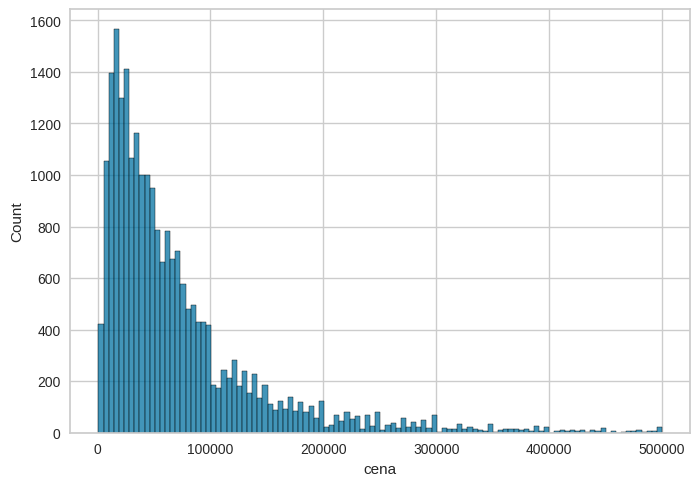

In [ ]:
sns.histplot(df['cena'])

<Axes: xlabel='cena', ylabel='Count'>

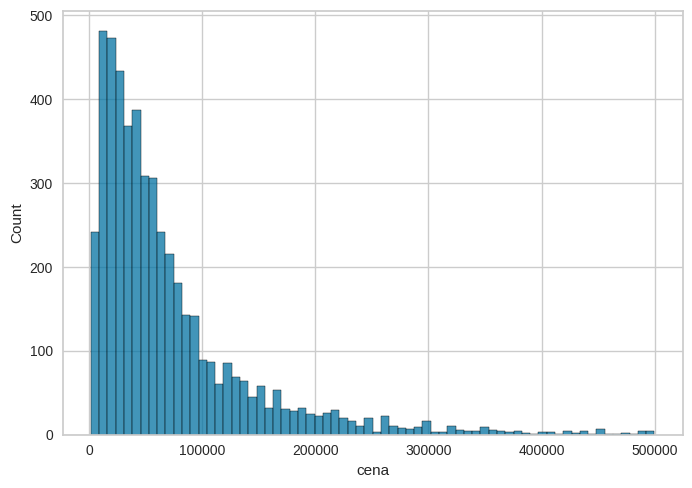

In [ ]:
sns.histplot(df['cena'].sample(5000))

In [ ]:
# sharpio wilk test
sw_cena = shapiro(df['cena'].sample(5000))
sw_cena

ShapiroResult(statistic=0.7469078898429871, pvalue=0.0)

In [ ]:
from scipy import stats

In [ ]:
stats.norm.cdf

<bound method rv_continuous.cdf of <scipy.stats._continuous_distns.norm_gen object at 0x7c7bf8fbdab0>>

In [ ]:
####
kstest(df['cena'], stats.norm.cdf)
####

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=800.0, statistic_sign=-1)

### Selecting columns and removing rows with more than 5 missing values

In [ ]:
df.columns = [col.strip().replace(' ', '_').lower() for col in df.columns]
df.columns

Index(['unnamed:_0', 'oferta_od', 'pokaż_oferty_z_numerem_vin',
       'ma_numer_rejestracyjny', 'marka_pojazdu', 'model_pojazdu', 'wersja',
       'rok_produkcji', 'przebieg', 'pojemność_skokowa', 'vin',
       'rodzaj_paliwa', 'moc', 'skrzynia_biegów', 'napęd',
       'spalanie_w_mieście', 'typ_nadwozia', 'liczba_drzwi', 'liczba_miejsc',
       'kolor', 'leasing', 'kraj_pochodzenia',
       'data_pierwszej_rejestracji_w_historii_pojazdu',
       'zarejestrowany_w_polsce', 'pierwszy_właściciel_(od_nowości)',
       'bezwypadkowy', 'serwisowany_w_aso', 'stan', 'cena', 'opis',
       'wojewodztwo_sprzedajacego', 'importowany', 'generacja',
       'spalanie_poza_miastem', 'emisja_co2', 'rodzaj_koloru',
       'opłata_początkowa', 'miesięczna_rata', 'liczba_pozostałych_rat',
       'wartość_wykupu', 'tuning', 'okres_gwarancji_producenta',
       'lub_do_(przebieg_km)', 'faktura_vat', 'vat_marża',
       'możliwość_finansowania', 'spalanie_w_cyklu_mieszanym',
       'gwarancja_dealerska_(w

In [ ]:
 selected_columns = ['marka_pojazdu',
                     'model_pojazdu',
                     'rok_produkcji',
                     'pojemność_skokowa',
                     'moc',
                     'przebieg',
                     'rodzaj_paliwa',
                     'skrzynia_biegów',
                     'napęd',
                     'cena',
                     'typ_nadwozia',
                     'liczba_drzwi',
                     'liczba_miejsc',
                     'kolor',
                     'leasing',
                     'oferta_od',
                     'uszkodzony'
                     ]

In [ ]:
df = df[selected_columns]
df

marka_pojazdu model_pojazdu rok_produkcji pojemność_skokowa     moc  \
0         Volkswagen        Arteon        2019.0         1 968 cm3  190 KM   
1      Mercedes-Benz            CL        2008.0         5 980 cm3  612 KM   
2                BMW            M4        2017.0         2 979 cm3  450 KM   
3               Audi            A5        2017.0         1 984 cm3  251 KM   
4               Opel         Astra        2009.0         1 598 cm3  115 KM   
...              ...           ...           ...               ...     ...   
23983          Honda        Accord          2008         2 354 cm3  190 KM   
23984         Toyota         Yaris          2004         1 298 cm3   87 KM   
23985           Fiat        Sedici          2008         1 586 cm3  107 KM   
23986           Ford   Focus C-Max          2006         1 798 cm3  125 KM   
23987        Hyundai      Santa Fe          2006         1 991 cm3  112 KM   

         przebieg rodzaj_paliwa skrzynia_biegów             napęd      cena  \
0      179 900 km        Diesel    Automatyczna  Na przednie koła  108973.0   
1      118 000 km       Benzyna    Automatyczna     Na tylne koła  244770.0   
2       63 800 km       Benzyna    Automatyczna     Na tylne koła  310000.0   
3       81 000 km       Benzyna    Automatyczna       4x4 (stały)  115000.0   
4      180 000 km       Benzyna        Manualna  Na przednie koła   17500.0   
...           ...           ...             ...               ...       ...   
23983   86 000 km       Benzyna    Automatyczna  Na przednie koła   42000.0   
23984  278 080 km       Benzyna        Manualna  Na przednie koła    3300.0   
23985  150 000 km       Benzyna        Manualna  Na przednie koła    5500.0   
23986  330 000 km   Benzyna+LPG        Manualna  Na przednie koła    4500.0   
23987  360 000 km        Diesel        Manualna  Na przednie koła    9900.0   

      typ_nadwozia  liczba_drzwi  liczba_miejsc      kolor leasing oferta_od  \
0            Coupe           5.0            5.0      Szary     Tak  Prywatne   
1            Coupe           2.0            4.0     Czarny     NaN  Prywatne   
2            Coupe           2.0            4.0      Szary     NaN  Prywatne   
3            Coupe           2.0            4.0      Biały     NaN  Prywatne   
4            Coupe           3.0            5.0     Czarny     NaN  Prywatne   
...            ...           ...            ...        ...     ...       ...   
23983        Coupe           2.0            5.0  Niebieski     NaN  Prywatne   
23984    Auta małe           3.0            5.0   Błękitny     NaN  Prywatne   
23985          SUV           5.0            5.0    Srebrny     NaN  Prywatne   
23986      Minivan           5.0            5.0     Czarny     NaN  Prywatne   
23987        Kombi           5.0            5.0     Czarny     NaN  Prywatne   

      uszkodzony  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
...          ...  
23983        Tak  
23984        Tak  
23985        Tak  
23986        Tak  
23987        Tak  

[23511 rows x 17 columns]

In [ ]:
df.duplicated().sum()

93

In [ ]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [ ]:
# removing rows with more than 5 missing values
df.dropna(thresh=12, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23417 entries, 0 to 23987
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   marka_pojazdu      23417 non-null  object 
 1   model_pojazdu      23417 non-null  object 
 2   rok_produkcji      23417 non-null  object 
 3   pojemność_skokowa  23073 non-null  object 
 4   moc                23417 non-null  object 
 5   przebieg           23417 non-null  object 
 6   rodzaj_paliwa      23417 non-null  object 
 7   skrzynia_biegów    23397 non-null  object 
 8   napęd              21947 non-null  object 
 9   cena               23417 non-null  float64
 10  typ_nadwozia       23417 non-null  object 
 11  liczba_drzwi       23388 non-null  float64
 12  liczba_miejsc      22463 non-null  float64
 13  kolor              23417 non-null  object 
 14  leasing            3204 non-null   object 
 15  oferta_od          23417 non-null  object 
 16  uszkodzony         128

# Extra rows

In [ ]:
# sample with mossing 'pojemność_skokowa'
n_sample = 12
extra_rows_without_pojemnosc_skokowa = df.sample(n_sample)
extra_rows_without_pojemnosc_skokowa

marka_pojazdu model_pojazdu rok_produkcji pojemność_skokowa     moc  \
18               Kia       Stinger        2018.0         3 342 cm3  370 KM   
5828      Volkswagen        Passat          2017         1 968 cm3  150 KM   
19778            BMW       Seria 3          2015         1 995 cm3  163 KM   
19970  Mercedes-Benz           GLE        2016.0         2 987 cm3  258 KM   
15569           Ford         S-Max        2015.0         1 997 cm3  180 KM   
22279          Volvo         XC 60        2022.0         1 969 cm3  197 KM   
12486            Kia          Ceed        2009.0         1 582 cm3   90 KM   
4963             BMW       Seria 5          2012         1 995 cm3  218 KM   
4529            Audi            A6          2005         2 967 cm3  224 KM   
9284           Skoda         Fabia          2003         1 198 cm3   54 KM   
7546           Skoda         Fabia          2019           999 cm3   95 KM   
5115         Hyundai           I30          2013         1 582 cm3  110 KM   

         przebieg rodzaj_paliwa skrzynia_biegów             napęd      cena  \
18      66 000 km       Benzyna    Automatyczna               NaN  191047.0   
5828   196 253 km        Diesel    Automatyczna  Na przednie koła   69000.0   
19778  243 000 km        Diesel        Manualna     Na tylne koła   62500.0   
19970  180 500 km        Diesel    Automatyczna       4x4 (stały)  139500.0   
15569  180 000 km        Diesel    Automatyczna  Na przednie koła   69000.0   
22279   29 000 km       Benzyna    Automatyczna  Na przednie koła  209000.0   
12486  288 000 km        Diesel        Manualna  Na przednie koła   14500.0   
4963   306 000 km        Diesel    Automatyczna       4x4 (stały)   49900.0   
4529   302 000 km        Diesel    Automatyczna       4x4 (stały)   22900.0   
9284   111 300 km       Benzyna        Manualna  Na przednie koła    5200.0   
7546    98 300 km       Benzyna        Manualna  Na przednie koła   47000.0   
5115   204 000 km        Diesel        Manualna  Na przednie koła   33300.0   

        typ_nadwozia  liczba_drzwi  liczba_miejsc       kolor leasing  \
18             Coupe           5.0            5.0    Czerwony     Tak   
5828           Kombi           5.0            5.0      Czarny     Tak   
19778          Sedan           4.0            5.0     Brązowy     NaN   
19970            SUV           5.0            5.0      Czarny     NaN   
15569        Minivan           5.0            5.0     Srebrny     NaN   
22279            SUV           5.0            5.0    Czerwony     NaN   
12486  Auta miejskie           5.0            4.0  Inny kolor     NaN   
4963           Kombi           5.0            5.0      Czarny     NaN   
4529           Kombi           5.0            5.0     Srebrny     NaN   
9284       Auta małe           5.0            5.0     Zielony     NaN   
7546         Kompakt           5.0            5.0       Szary     NaN   
5115           Kombi           5.0            5.0       Szary     NaN   

      oferta_od uszkodzony  
18     Prywatne        NaN  
5828      Firma        NaN  
19778  Prywatne        NaN  
19970  Prywatne        NaN  
15569  Prywatne        NaN  
22279     Firma        NaN  
12486  Prywatne        NaN  
4963   Prywatne        NaN  
4529   Prywatne        NaN  
9284   Prywatne        NaN  
7546   Prywatne        NaN  
5115   Prywatne        NaN

In [ ]:
extra_rows_without_pojemnosc_skokowa['rodzaj_paliwa']

18       Benzyna
5828      Diesel
19778     Diesel
19970     Diesel
15569     Diesel
22279    Benzyna
12486     Diesel
4963      Diesel
4529      Diesel
9284     Benzyna
7546     Benzyna
5115      Diesel
Name: rodzaj_paliwa, dtype: object

In [ ]:
extra_rows_without_pojemnosc_skokowa['pojemność_skokowa']

18       3 342 cm3
5828     1 968 cm3
19778    1 995 cm3
19970    2 987 cm3
15569    1 997 cm3
22279    1 969 cm3
12486    1 582 cm3
4963     1 995 cm3
4529     2 967 cm3
9284     1 198 cm3
7546       999 cm3
5115     1 582 cm3
Name: pojemność_skokowa, dtype: object

In [ ]:
extra_rows_without_pojemnosc_skokowa['pojemność_skokowa'] = np.nan

In [ ]:
extra_rows_without_pojemnosc_skokowa['pojemność_skokowa']

18      NaN
5828    NaN
19778   NaN
19970   NaN
15569   NaN
22279   NaN
12486   NaN
4963    NaN
4529    NaN
9284    NaN
7546    NaN
5115    NaN
Name: pojemność_skokowa, dtype: float64

In [ ]:
extra_rows_without_pojemnosc_skokowa

marka_pojazdu model_pojazdu rok_produkcji  pojemność_skokowa     moc  \
18               Kia       Stinger        2018.0                NaN  370 KM   
5828      Volkswagen        Passat          2017                NaN  150 KM   
19778            BMW       Seria 3          2015                NaN  163 KM   
19970  Mercedes-Benz           GLE        2016.0                NaN  258 KM   
15569           Ford         S-Max        2015.0                NaN  180 KM   
22279          Volvo         XC 60        2022.0                NaN  197 KM   
12486            Kia          Ceed        2009.0                NaN   90 KM   
4963             BMW       Seria 5          2012                NaN  218 KM   
4529            Audi            A6          2005                NaN  224 KM   
9284           Skoda         Fabia          2003                NaN   54 KM   
7546           Skoda         Fabia          2019                NaN   95 KM   
5115         Hyundai           I30          2013                NaN  110 KM   

         przebieg rodzaj_paliwa skrzynia_biegów             napęd      cena  \
18      66 000 km       Benzyna    Automatyczna               NaN  191047.0   
5828   196 253 km        Diesel    Automatyczna  Na przednie koła   69000.0   
19778  243 000 km        Diesel        Manualna     Na tylne koła   62500.0   
19970  180 500 km        Diesel    Automatyczna       4x4 (stały)  139500.0   
15569  180 000 km        Diesel    Automatyczna  Na przednie koła   69000.0   
22279   29 000 km       Benzyna    Automatyczna  Na przednie koła  209000.0   
12486  288 000 km        Diesel        Manualna  Na przednie koła   14500.0   
4963   306 000 km        Diesel    Automatyczna       4x4 (stały)   49900.0   
4529   302 000 km        Diesel    Automatyczna       4x4 (stały)   22900.0   
9284   111 300 km       Benzyna        Manualna  Na przednie koła    5200.0   
7546    98 300 km       Benzyna        Manualna  Na przednie koła   47000.0   
5115   204 000 km        Diesel        Manualna  Na przednie koła   33300.0   

        typ_nadwozia  liczba_drzwi  liczba_miejsc       kolor leasing  \
18             Coupe           5.0            5.0    Czerwony     Tak   
5828           Kombi           5.0            5.0      Czarny     Tak   
19778          Sedan           4.0            5.0     Brązowy     NaN   
19970            SUV           5.0            5.0      Czarny     NaN   
15569        Minivan           5.0            5.0     Srebrny     NaN   
22279            SUV           5.0            5.0    Czerwony     NaN   
12486  Auta miejskie           5.0            4.0  Inny kolor     NaN   
4963           Kombi           5.0            5.0      Czarny     NaN   
4529           Kombi           5.0            5.0     Srebrny     NaN   
9284       Auta małe           5.0            5.0     Zielony     NaN   
7546         Kompakt           5.0            5.0       Szary     NaN   
5115           Kombi           5.0            5.0       Szary     NaN   

      oferta_od uszkodzony  
18     Prywatne        NaN  
5828      Firma        NaN  
19778  Prywatne        NaN  
19970  Prywatne        NaN  
15569  Prywatne        NaN  
22279     Firma        NaN  
12486  Prywatne        NaN  
4963   Prywatne        NaN  
4529   Prywatne        NaN  
9284   Prywatne        NaN  
7546   Prywatne        NaN  
5115   Prywatne        NaN

In [ ]:
extra_rows_without_pojemnosc_skokowa.index

Int64Index([18, 5828, 19778, 19970, 15569, 22279, 12486, 4963, 4529, 9284,
            7546, 5115],
           dtype='int64')

In [ ]:
np.arange(30001, 30000+n_sample+1)

array([30001, 30002, 30003, 30004, 30005, 30006, 30007, 30008, 30009,
       30010, 30011, 30012])

In [ ]:
extra_rows_without_pojemnosc_skokowa.index = np.arange(30001, 30000+n_sample+1)

In [ ]:
extra_rows_without_pojemnosc_skokowa.index

Int64Index([30001, 30002, 30003, 30004, 30005, 30006, 30007, 30008, 30009,
            30010, 30011, 30012],
           dtype='int64')

In [ ]:
extra_rows_without_pojemnosc_skokowa

marka_pojazdu model_pojazdu rok_produkcji  pojemność_skokowa     moc  \
30001            Kia       Stinger        2018.0                NaN  370 KM   
30002     Volkswagen        Passat          2017                NaN  150 KM   
30003            BMW       Seria 3          2015                NaN  163 KM   
30004  Mercedes-Benz           GLE        2016.0                NaN  258 KM   
30005           Ford         S-Max        2015.0                NaN  180 KM   
30006          Volvo         XC 60        2022.0                NaN  197 KM   
30007            Kia          Ceed        2009.0                NaN   90 KM   
30008            BMW       Seria 5          2012                NaN  218 KM   
30009           Audi            A6          2005                NaN  224 KM   
30010          Skoda         Fabia          2003                NaN   54 KM   
30011          Skoda         Fabia          2019                NaN   95 KM   
30012        Hyundai           I30          2013                NaN  110 KM   

         przebieg rodzaj_paliwa skrzynia_biegów             napęd      cena  \
30001   66 000 km       Benzyna    Automatyczna               NaN  191047.0   
30002  196 253 km        Diesel    Automatyczna  Na przednie koła   69000.0   
30003  243 000 km        Diesel        Manualna     Na tylne koła   62500.0   
30004  180 500 km        Diesel    Automatyczna       4x4 (stały)  139500.0   
30005  180 000 km        Diesel    Automatyczna  Na przednie koła   69000.0   
30006   29 000 km       Benzyna    Automatyczna  Na przednie koła  209000.0   
30007  288 000 km        Diesel        Manualna  Na przednie koła   14500.0   
30008  306 000 km        Diesel    Automatyczna       4x4 (stały)   49900.0   
30009  302 000 km        Diesel    Automatyczna       4x4 (stały)   22900.0   
30010  111 300 km       Benzyna        Manualna  Na przednie koła    5200.0   
30011   98 300 km       Benzyna        Manualna  Na przednie koła   47000.0   
30012  204 000 km        Diesel        Manualna  Na przednie koła   33300.0   

        typ_nadwozia  liczba_drzwi  liczba_miejsc       kolor leasing  \
30001          Coupe           5.0            5.0    Czerwony     Tak   
30002          Kombi           5.0            5.0      Czarny     Tak   
30003          Sedan           4.0            5.0     Brązowy     NaN   
30004            SUV           5.0            5.0      Czarny     NaN   
30005        Minivan           5.0            5.0     Srebrny     NaN   
30006            SUV           5.0            5.0    Czerwony     NaN   
30007  Auta miejskie           5.0            4.0  Inny kolor     NaN   
30008          Kombi           5.0            5.0      Czarny     NaN   
30009          Kombi           5.0            5.0     Srebrny     NaN   
30010      Auta małe           5.0            5.0     Zielony     NaN   
30011        Kompakt           5.0            5.0       Szary     NaN   
30012          Kombi           5.0            5.0       Szary     NaN   

      oferta_od uszkodzony  
30001  Prywatne        NaN  
30002     Firma        NaN  
30003  Prywatne        NaN  
30004  Prywatne        NaN  
30005  Prywatne        NaN  
30006     Firma        NaN  
30007  Prywatne        NaN  
30008  Prywatne        NaN  
30009  Prywatne        NaN  
30010  Prywatne        NaN  
30011  Prywatne        NaN  
30012  Prywatne        NaN

In [ ]:
df.shape

(23417, 17)

In [ ]:
df = pd.concat([df, extra_rows_without_pojemnosc_skokowa], axis=0, join='outer')#, ignore_index=True)
#df.head()
df.tail(25)

marka_pojazdu model_pojazdu rok_produkcji pojemność_skokowa     moc  \
23975        Renault        Laguna          2009         1 995 cm3  150 KM   
23976            BMW       Seria 1          2012         1 995 cm3  143 KM   
23977        Renault        Scenic          2012         1 197 cm3  116 KM   
23978        Citroën      C-Elysée          2016         1 587 cm3  115 KM   
23979        Hyundai           i40          2012         1 685 cm3  115 KM   
23980        Citroën            C4          2004         1 997 cm3  136 KM   
23981        Renault          Clio          2008         1 461 cm3   68 KM   
23982           Opel        Meriva          2006         1 598 cm3  105 KM   
23983          Honda        Accord          2008         2 354 cm3  190 KM   
23984         Toyota         Yaris          2004         1 298 cm3   87 KM   
23985           Fiat        Sedici          2008         1 586 cm3  107 KM   
23986           Ford   Focus C-Max          2006         1 798 cm3  125 KM   
23987        Hyundai      Santa Fe          2006         1 991 cm3  112 KM   
30001            Kia       Stinger        2018.0               NaN  370 KM   
30002     Volkswagen        Passat          2017               NaN  150 KM   
30003            BMW       Seria 3          2015               NaN  163 KM   
30004  Mercedes-Benz           GLE        2016.0               NaN  258 KM   
30005           Ford         S-Max        2015.0               NaN  180 KM   
30006          Volvo         XC 60        2022.0               NaN  197 KM   
30007            Kia          Ceed        2009.0               NaN   90 KM   
30008            BMW       Seria 5          2012               NaN  218 KM   
30009           Audi            A6          2005               NaN  224 KM   
30010          Skoda         Fabia          2003               NaN   54 KM   
30011          Skoda         Fabia          2019               NaN   95 KM   
30012        Hyundai           I30          2013               NaN  110 KM   

         przebieg rodzaj_paliwa skrzynia_biegów             napęd      cena  \
23975  270 000 km        Diesel        Manualna  Na przednie koła   13000.0   
23976  280 000 km        Diesel        Manualna     Na tylne koła   20900.0   
23977   97 000 km       Benzyna        Manualna  Na przednie koła   17000.0   
23978   36 000 km       Benzyna        Manualna  Na przednie koła   19000.0   
23979  260 000 km        Diesel        Manualna  Na przednie koła   12500.0   
23980  225 000 km        Diesel        Manualna  Na przednie koła    6500.0   
23981  232 560 km        Diesel        Manualna  Na przednie koła    4000.0   
23982  280 000 km   Benzyna+LPG        Manualna  Na przednie koła    3500.0   
23983   86 000 km       Benzyna    Automatyczna  Na przednie koła   42000.0   
23984  278 080 km       Benzyna        Manualna  Na przednie koła    3300.0   
23985  150 000 km       Benzyna        Manualna  Na przednie koła    5500.0   
23986  330 000 km   Benzyna+LPG        Manualna  Na przednie koła    4500.0   
23987  360 000 km        Diesel        Manualna  Na przednie koła    9900.0   
30001   66 000 km       Benzyna    Automatyczna               NaN  191047.0   
30002  196 253 km        Diesel    Automatyczna  Na przednie koła   69000.0   
30003  243 000 km        Diesel        Manualna     Na tylne koła   62500.0   
30004  180 500 km        Diesel    Automatyczna       4x4 (stały)  139500.0   
30005  180 000 km        Diesel    Automatyczna  Na przednie koła   69000.0   
30006   29 000 km       Benzyna    Automatyczna  Na przednie koła  209000.0   
30007  288 000 km        Diesel        Manualna  Na przednie koła   14500.0   
30008  306 000 km        Diesel    Automatyczna       4x4 (stały)   49900.0   
30009  302 000 km        Diesel    Automatyczna       4x4 (stały)   22900.0   
30010  111 300 km       Benzyna        Manualna  Na przednie koła    5200.0   
30011   98 300 km       Benzyna        Manualna  Na przednie koła   47000.0   
300

In [ ]:
df.shape

(23429, 17)

# <a name='3'></a> Data frame splitting and preprocessing

In [ ]:
####
df[df['pojemność_skokowa'].isnull()]['rodzaj_paliwa'].value_counts()

Elektryczny    344
Diesel           8
Benzyna          4
Name: rodzaj_paliwa, dtype: int64

In [ ]:
X = df.copy()
y = X.pop('uszkodzony')

In [ ]:
y.value_counts()

Tak    1289
Name: uszkodzony, dtype: int64

In [ ]:
y.isna().sum()

22140

In [ ]:
y = y.map({np.nan: 0, 'Tak': 1})

In [ ]:
y.value_counts()

0    22140
1     1289
Name: uszkodzony, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    random_state=420,
                                                    stratify=y)

In [ ]:
len(X_train)

18743

In [ ]:
len(X_test)

4686

In [ ]:
y_train.value_counts()

0    17712
1     1031
Name: uszkodzony, dtype: int64

## Preprocessing train data

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18743 entries, 5773 to 4436
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   marka_pojazdu      18743 non-null  object 
 1   model_pojazdu      18743 non-null  object 
 2   rok_produkcji      18743 non-null  object 
 3   pojemność_skokowa  18456 non-null  object 
 4   moc                18743 non-null  object 
 5   przebieg           18743 non-null  object 
 6   rodzaj_paliwa      18743 non-null  object 
 7   skrzynia_biegów    18731 non-null  object 
 8   napęd              17527 non-null  object 
 9   cena               18743 non-null  float64
 10  typ_nadwozia       18743 non-null  object 
 11  liczba_drzwi       18718 non-null  float64
 12  liczba_miejsc      17986 non-null  float64
 13  kolor              18743 non-null  object 
 14  leasing            2544 non-null   object 
 15  oferta_od          18743 non-null  object 
dtypes: float64(3), objec

### Changing data types

#### rok_produkcji

In [ ]:
X_train['rok_produkcji']

5773       2019
9759       2012
18893      2005
6148       2003
14505    2014.0
          ...  
13027    2010.0
4958       2001
7784       2014
6046       2012
4436       2013
Name: rok_produkcji, Length: 18743, dtype: object

In [ ]:
X_train['rok_produkcji'] = X_train['rok_produkcji'].astype(float)

<Axes: xlabel='rok_produkcji', ylabel='Count'>

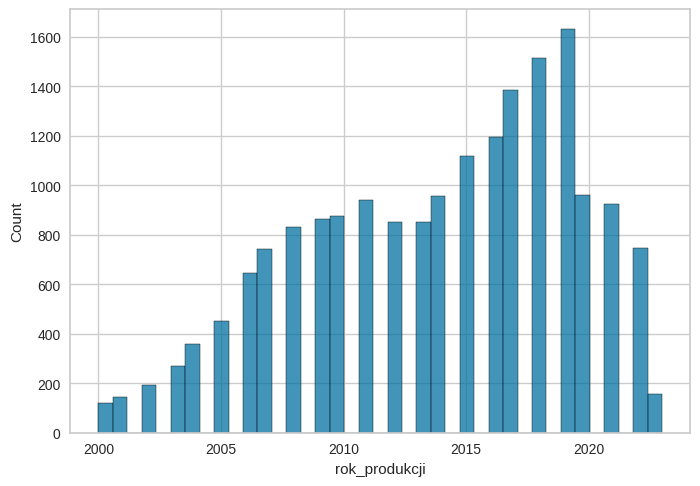

In [ ]:
sns.histplot(X_train['rok_produkcji'])

In [ ]:
X_train['rok_produkcji']

5773     2019.0
9759     2012.0
18893    2005.0
6148     2003.0
14505    2014.0
          ...  
13027    2010.0
4958     2001.0
7784     2014.0
6046     2012.0
4436     2013.0
Name: rok_produkcji, Length: 18743, dtype: float64

In [ ]:
# sharpio wilk test
sw_rok = shapiro(X_train['rok_produkcji'].sample(5000))
sw_rok

ShapiroResult(statistic=0.9609829187393188, pvalue=1.0847257535409118e-34)

#### przebieg

In [ ]:
X_train['przebieg']

5773      53 710 km
9759      66 579 km
18893    323 800 km
6148     192 000 km
14505    191 700 km
            ...    
13027    115 000 km
4958     344 444 km
7784      59 000 km
6046     299 675 km
4436     327 574 km
Name: przebieg, Length: 18743, dtype: object

In [ ]:
X_train['przebieg'] = X_train['przebieg'].str.replace('km', '').str.replace(' ', '').str.strip().astype(int)

<Axes: xlabel='przebieg', ylabel='Count'>

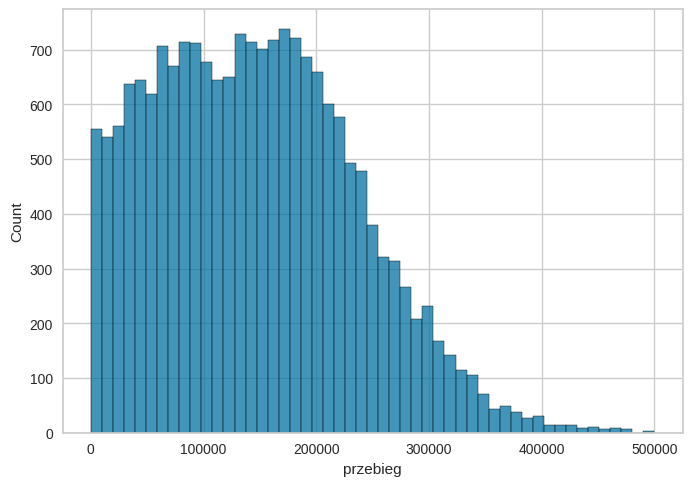

In [ ]:
sns.histplot(X_train['przebieg'])

#### pojemność_skokowa

In [ ]:
X_train['pojemność_skokowa']

5773     1 197 cm3
9759       523 cm3
18893    1 968 cm3
6148     1 995 cm3
14505    1 995 cm3
           ...    
13027    1 199 cm3
4958     2 497 cm3
7784     3 605 cm3
6046     1 998 cm3
4436     1 995 cm3
Name: pojemność_skokowa, Length: 18743, dtype: object

In [ ]:
X_train['pojemność_skokowa'] = X_train['pojemność_skokowa'].str.replace('cm3', '').str.replace(' ', '').astype(float)

<Axes: xlabel='pojemność_skokowa', ylabel='Count'>

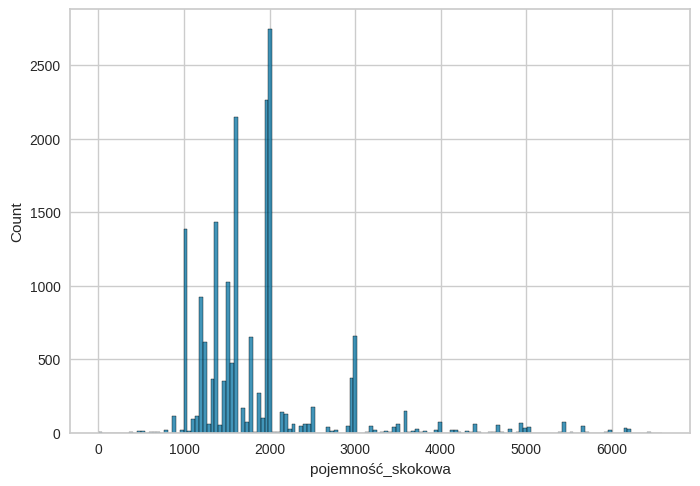

In [ ]:
sns.histplot(X_train['pojemność_skokowa'])

<Axes: xlabel='pojemność_skokowa', ylabel='Count'>

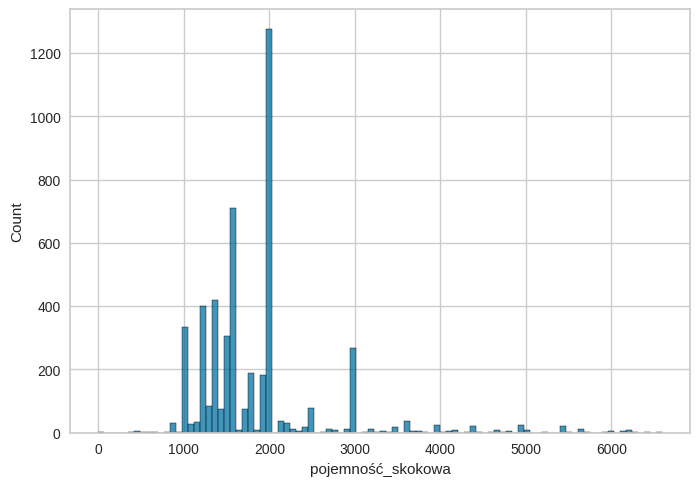

In [ ]:
sns.histplot(X_train['pojemność_skokowa'].sample(5000))

In [ ]:
# sharpio wilk test
sw_pojemnosc = shapiro(X_train['pojemność_skokowa'].sample(5000))
sw_pojemnosc

ShapiroResult(statistic=nan, pvalue=1.0)

#### moc

In [ ]:
X_train['moc']

5773     116 KM
9759       5 KM
18893    140 KM
6148     116 KM
14505    114 KM
          ...  
13027     75 KM
4958     163 KM
7784     300 KM
6046     124 KM
4436     163 KM
Name: moc, Length: 18743, dtype: object

In [ ]:
X_train['moc'] = X_train['moc'].str.replace('KM', '').str.replace(' ', '').astype(float)

In [ ]:
X_train['moc']

5773     116.0
9759       5.0
18893    140.0
6148     116.0
14505    114.0
         ...  
13027     75.0
4958     163.0
7784     300.0
6046     124.0
4436     163.0
Name: moc, Length: 18743, dtype: float64

In [ ]:
X_train['moc'].isna().sum()

0

<Axes: xlabel='moc', ylabel='Count'>

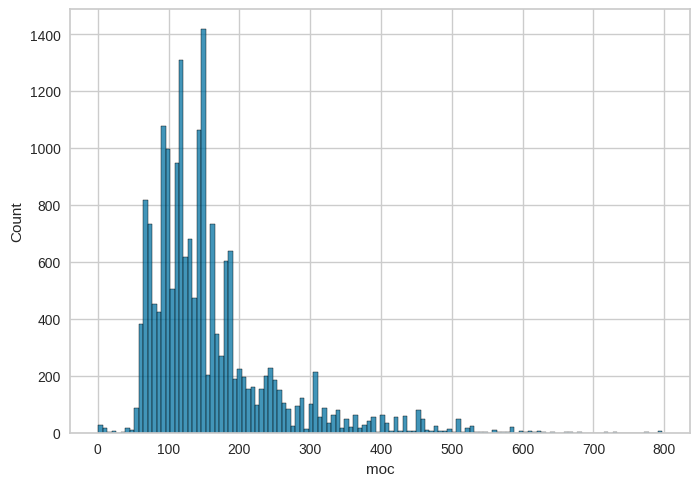

In [ ]:
sns.histplot(X_train['moc'])

In [ ]:
# sharpio wilk test
sw_moc = shapiro(X_train['moc'].sample(5000))
sw_moc

ShapiroResult(statistic=0.8165919184684753, pvalue=0.0)

### Changing marka_pojazdu

In [ ]:
X_train['marka_pojazdu'].unique()

array(['Toyota', 'Aixam', 'Audi', 'Renault', 'Dacia', 'BMW', 'Fiat',
       'Volkswagen', 'Mercedes-Benz', 'Suzuki', 'Skoda', 'Honda', 'Jeep',
       'Citroën', 'Ford', 'Opel', 'Chevrolet', 'Dodge', 'Infiniti',
       'Nissan', 'Chrysler', 'Volvo', 'Hyundai', 'Land Rover', 'Seat',
       'Kia', 'Bentley', 'Alfa Romeo', 'Lexus', 'Peugeot', 'Jaguar',
       'Maserati', 'Porsche', 'MINI', 'Mitsubishi', 'Subaru', 'Smart',
       'Mazda', 'Ligier', 'Maybach', 'Aston Martin', 'BMW-ALPINA', 'Inny',
       'Lancia', 'RAM', 'Cadillac', 'Saab', 'Abarth', 'Tesla', 'KTM',
       'Microcar', 'Hummer', 'Daewoo', 'Daihatsu', 'Polestar',
       'DS Automobiles', 'Cupra', 'MG', 'Ferrari', 'SsangYong', 'Alpine',
       'Tata', 'Lincoln', 'Buick', 'Lotus', 'Lada', 'GMC', 'Caterham',
       'LTI', 'Isuzu', 'Acura', 'McLaren', 'Pontiac', 'Casalini',
       'Piaggio', 'Chatenet', 'Rover', 'Iveco'], dtype=object)

In [ ]:
# https://www.wyborkierowcow.pl/ranking-prestizu-marek-samochodowych/

luxury_brands = ['Rolls-Royce', 'Ferrari', 'Aston Martin', 'Bentley', 'Lamborghini',
                 'McLaren', 'Maserati', 'Aston Martin', 'McLaren', 'Maybach']

premium_brands = ['Porsche', 'Jaguar', 'Lotus', 'Mercedes-Benz', 'BMW', 'Audi',
                  'Land Rover', 'Tesla', 'Lexus', 'Infiniti']

subpremium_brands = ['MINI', 'Volvo', 'Jeep', 'Alfa Romeo', 'DS', 'Cupra', 'Alpine',
                     'BMW-ALPINA', 'Abarth', 'Mazda']

popular_brands = ['Volkswagen', 'Opel', 'Ford', 'Dodge', 'Kia','Chevrolet',
                  'Hyundai', 'Skoda', 'Seat', 'Renault', 'Toyota', 'Subaru',
                  'Honda', 'Nissan', 'Peugeot', 'Chrysler', 'Saab', 'Citroën',
                  'Mitsubishi', 'Suzuki', 'Fiat', 'Smart', 'Cadillac',
                  'Pontiac', 'Lancia', 'Dacia', 'SsangYong']

In [ ]:
# Changing the brand to a luxurious, popular (the brand name remains) and other
brand_dict = {'Luksusowa': luxury_brands, 'Popularna': popular_brands + premium_brands + subpremium_brands}

In [ ]:
def brand_type(brand, map_dict=brand_dict):
    if brand in map_dict['Luksusowa']:
        return 'Luksusowa'
    elif brand in map_dict['Popularna']:
        return brand
    else:
        return 'INNA'

brand_type('Audi')

'Audi'

In [ ]:
X_train['marka_pojazdu'] = X_train['marka_pojazdu'].apply(lambda x: brand_type(x))

In [ ]:
X_train['marka_pojazdu'].value_counts()

Volkswagen       1657
BMW              1511
Ford             1505
Opel             1347
Audi             1346
Mercedes-Benz    1346
Toyota           1112
Renault          1031
Skoda             944
Peugeot           821
Citroën           680
Kia               588
Fiat              532
Hyundai           492
Volvo             443
Seat              397
Nissan            349
Mazda             317
MINI              269
Honda             266
Suzuki            197
Dacia             151
Porsche           135
Chevrolet         134
Mitsubishi        116
INNA              112
Dodge             101
Alfa Romeo         95
Jaguar             93
Jeep               92
Lexus              85
Chrysler           78
Land Rover         74
Subaru             69
Smart              63
Luksusowa          39
Saab               32
Infiniti           28
Lancia             22
Abarth             20
Tesla              18
Cupra              13
SsangYong          11
Cadillac            6
BMW-ALPINA          2
Alpine    

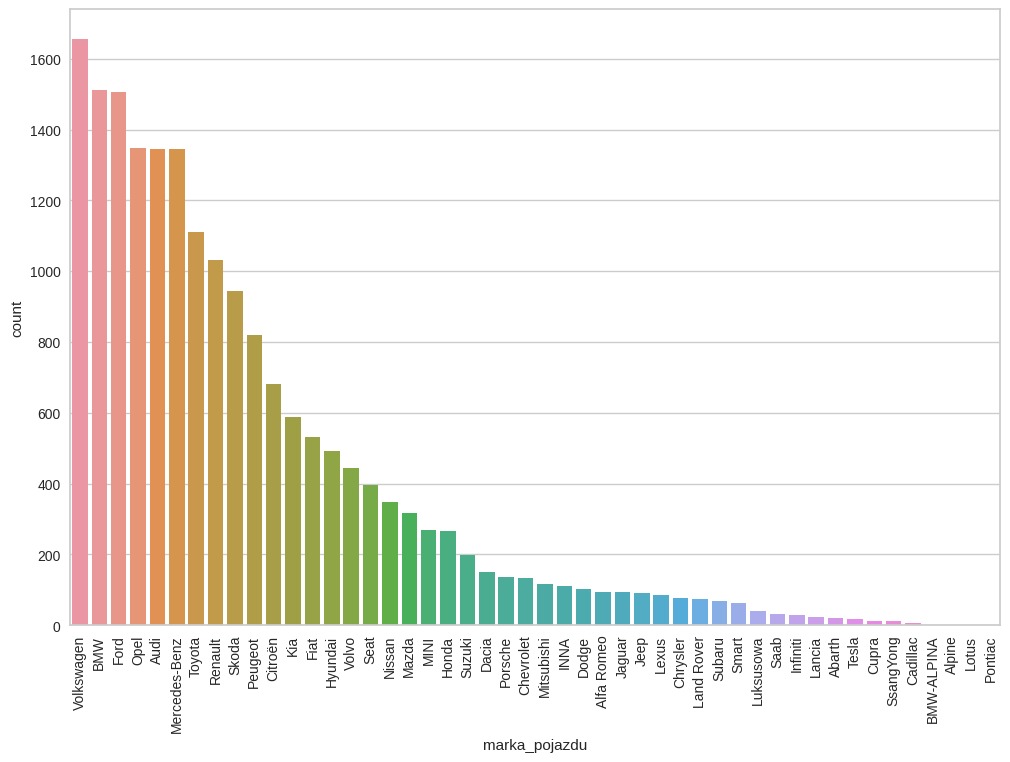

In [ ]:
plt.figure(figsize = (12, 8))
sns.countplot(x='marka_pojazdu', data=X_train, order=list(X_train['marka_pojazdu'].value_counts().index))
plt.xticks(rotation = 90);

### Filling missing values

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18743 entries, 5773 to 4436
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   marka_pojazdu      18743 non-null  object 
 1   model_pojazdu      18743 non-null  object 
 2   rok_produkcji      18743 non-null  float64
 3   pojemność_skokowa  18456 non-null  float64
 4   moc                18743 non-null  float64
 5   przebieg           18743 non-null  int64  
 6   rodzaj_paliwa      18743 non-null  object 
 7   skrzynia_biegów    18731 non-null  object 
 8   napęd              17527 non-null  object 
 9   cena               18743 non-null  float64
 10  typ_nadwozia       18743 non-null  object 
 11  liczba_drzwi       18718 non-null  float64
 12  liczba_miejsc      17986 non-null  float64
 13  kolor              18743 non-null  object 
 14  leasing            2544 non-null   object 
 15  oferta_od          18743 non-null  object 
dtypes: float64(6), int64

In [ ]:
X_train.describe()

rok_produkcji  pojemność_skokowa           moc       przebieg  \
count   18743.000000       18456.000000  18743.000000   18743.000000   
mean     2013.809796        1865.783919    157.145761  146308.549859   
std         5.469987         813.355660     88.253420   88461.710615   
min      2000.000000           1.000000      1.000000       1.000000   
25%      2010.000000        1395.000000    100.000000   74449.500000   
50%      2015.000000        1609.000000    136.000000  141000.000000   
75%      2018.000000        1995.000000    184.000000  207000.000000   
max      2023.000000        6592.000000    797.000000  500000.000000   

                cena  liczba_drzwi  liczba_miejsc  
count   18743.000000  18718.000000   17986.000000  
mean    70498.365969      4.462763       4.927833  
std     72766.080108      0.968807       0.917937  
min      1500.000000      2.000000       1.000000  
25%     23900.000000      4.000000       5.000000  
50%     47900.000000      5.000000       5.000000  
75%     87900.000000      5.000000       5.000000  
max    499999.000000      6.000000       9.000000

In [ ]:
X_train.describe(include='object')

marka_pojazdu model_pojazdu rodzaj_paliwa skrzynia_biegów  \
count          18743         18743         18743           18731   
unique            48           746             6               2   
top       Volkswagen         Astra       Benzyna        Manualna   
freq            1657           415          9933           11181   

                   napęd typ_nadwozia   kolor leasing oferta_od  
count              17527        18743   18743    2544     18743  
unique                 5            9      17       1         2  
top     Na przednie koła        Kombi  Czarny     Tak  Prywatne  
freq               12591         2707    4367    2544     12579

In [ ]:
missing_data = X_train.isnull().sum()
missing_data

marka_pojazdu            0
model_pojazdu            0
rok_produkcji            0
pojemność_skokowa      287
moc                      0
przebieg                 0
rodzaj_paliwa            0
skrzynia_biegów         12
napęd                 1216
cena                     0
typ_nadwozia             0
liczba_drzwi            25
liczba_miejsc          757
kolor                    0
leasing              16199
oferta_od                0
dtype: int64

In [ ]:
missing_data[missing_data > 0]

pojemność_skokowa      287
skrzynia_biegów         12
napęd                 1216
liczba_drzwi            25
liczba_miejsc          757
leasing              16199
dtype: int64

In [ ]:
cols_to_fill = list(missing_data[missing_data > 0].index)
cols_to_fill

['pojemność_skokowa',
 'skrzynia_biegów',
 'napęd',
 'liczba_drzwi',
 'liczba_miejsc',
 'leasing']

In [ ]:
for col in cols_to_fill:
    print(f'{col}; number of missing values: {X_train[col].isnull().sum()}')
    print(X_train[col].value_counts())

    print(40 * '-')

pojemność_skokowa; number of missing values: 287
1598.0    1420
1968.0    1111
1995.0     810
1997.0     780
999.0      753
          ... 
3999.0       1
1578.0       1
1343.0       1
3217.0       1
5972.0       1
Name: pojemność_skokowa, Length: 420, dtype: int64
----------------------------------------
skrzynia_biegów; number of missing values: 12
Manualna        11181
Automatyczna     7550
Name: skrzynia_biegów, dtype: int64
----------------------------------------
napęd; number of missing values: 1216
Na przednie koła                 12591
Na tylne koła                     1893
4x4 (stały)                       1609
4x4 (dołączany automatycznie)     1292
4x4 (dołączany ręcznie)            142
Name: napęd, dtype: int64
----------------------------------------
liczba_drzwi; number of missing values: 25
5.0    13473
4.0     2038
2.0     1625
3.0     1575
6.0        7
Name: liczba_drzwi, dtype: int64
----------------------------------------
liczba_miejsc; number of missing values: 757


#### pojemność_skokowa

(if electric: strategy='constant', fill_value=0;  

if other: strategy='mean')

In [ ]:
X_train.shape

(18743, 16)

In [ ]:
X_train[X_train['pojemność_skokowa'].isna()]

marka_pojazdu model_pojazdu  rok_produkcji  pojemność_skokowa    moc  \
23075       Renault           Zoe         2018.0                NaN   92.0   
10322          Fiat           500         2020.0                NaN  118.0   
11655           BMW            i3         2019.0                NaN  184.0   
7156         Nissan          Leaf         2014.0                NaN  109.0   
8545         Nissan          Leaf         2021.0                NaN  217.0   
...             ...           ...            ...                ...    ...   
30009          Audi            A6         2005.0                NaN  224.0   
23674          Opel         Corsa         2022.0                NaN  136.0   
6191            Kia          Niro         2022.0                NaN  204.0   
10984          Fiat           500         2017.0                NaN  118.0   
12821           BMW            i3         2018.0                NaN  184.0   

       przebieg rodzaj_paliwa skrzynia_biegów             napęd      cena  \
23075     59999   Elektryczny    Automatyczna               NaN   53000.0   
10322     62000   Elektryczny    Automatyczna  Na przednie koła   93000.0   
11655     45425   Elektryczny    Automatyczna     Na tylne koła  123000.0   
7156     143150   Elektryczny    Automatyczna  Na przednie koła   49000.0   
8545      29000   Elektryczny    Automatyczna  Na przednie koła  153000.0   
...         ...           ...             ...               ...       ...   
30009    302000        Diesel    Automatyczna       4x4 (stały)   22900.0   
23674     11000   Elektryczny    Automatyczna  Na przednie koła   59999.0   
6191       3600   Elektryczny    Automatyczna  Na przednie koła  186900.0   
10984     92000   Elektryczny    Automatyczna  Na przednie koła   59700.0   
12821     19500   Elektryczny    Automatyczna     Na tylne koła  120900.0   

        typ_nadwozia  liczba_drzwi  liczba_miejsc      kolor leasing oferta_od  
23075  Auta miejskie           5.0            5.0  Niebieski     NaN  Prywatne  
10322      Auta małe           2.0            4.0      Szary     NaN     Firma  
11655      Auta małe           5.0            4.0   Czerwony     NaN  Prywatne  
7156         Kompakt           5.0            5.0     Czarny     NaN  Prywatne  
8545         Kompakt           5.0            5.0      Biały     NaN  Prywatne  
...              ...           ...            ...        ...     ...       ...  
30009          Kombi           5.0            5.0    Srebrny     NaN  Prywatne  
23674      Auta małe           5.0            5.0      Biały     NaN  Prywatne  
6191         Kompakt           5.0            5.0    Zielony     NaN     Firma  
10984      Auta małe           3.0            4.0   Błękitny     NaN  Prywatne  
12821  Auta miejskie           5.0            5.0  Granatowy     NaN  Prywatne  

[287 rows x 16 columns]

In [ ]:
X_train[X_train['pojemność_skokowa'].isna()]['rodzaj_paliwa'].value_counts()

Elektryczny    275
Diesel           8
Benzyna          4
Name: rodzaj_paliwa, dtype: int64

##### Two SimpleImputer for electic cars and other cars

In [ ]:
imputer_pojemnosc_skokowa_mean = SimpleImputer(missing_values=np.nan, strategy='mean', fill_value=0)
imputer_pojemnosc_skokowa_mean.fit_transform(X_train[['pojemność_skokowa']])

array([[1197.],
       [ 523.],
       [1968.],
       ...,
       [3605.],
       [1998.],
       [1995.]])

In [ ]:
imputer_pojemnosc_skokowa_mean.statistics_

array([1865.78391851])

In [ ]:
X_train['pojemność_skokowa'].mean()

1865.783918508886

In [ ]:
imputer_pojemnosc_skokowa_electric = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
imputer_pojemnosc_skokowa_electric.fit_transform(X_train[['pojemność_skokowa']])

array([[1197.],
       [ 523.],
       [1968.],
       ...,
       [3605.],
       [1998.],
       [1995.]])

In [ ]:
imputer_pojemnosc_skokowa_electric.statistics_

array([0.])

##### Extraction of cars with missing "pojemność_skokowa" (electric and no electric) and imputing values.

In [ ]:
# Electric cars with missing 'pojemność_skokowa'  (all electric)
electric = X_train[(X_train['rodzaj_paliwa'] == 'Elektryczny') & (X_train['pojemność_skokowa'].isna())]
electric

marka_pojazdu model_pojazdu  rok_produkcji  pojemność_skokowa    moc  \
23075       Renault           Zoe         2018.0                NaN   92.0   
10322          Fiat           500         2020.0                NaN  118.0   
11655           BMW            i3         2019.0                NaN  184.0   
7156         Nissan          Leaf         2014.0                NaN  109.0   
8545         Nissan          Leaf         2021.0                NaN  217.0   
...             ...           ...            ...                ...    ...   
10121          MINI        Cooper         2022.0                NaN  184.0   
23674          Opel         Corsa         2022.0                NaN  136.0   
6191            Kia          Niro         2022.0                NaN  204.0   
10984          Fiat           500         2017.0                NaN  118.0   
12821           BMW            i3         2018.0                NaN  184.0   

       przebieg rodzaj_paliwa skrzynia_biegów             napęd      cena  \
23075     59999   Elektryczny    Automatyczna               NaN   53000.0   
10322     62000   Elektryczny    Automatyczna  Na przednie koła   93000.0   
11655     45425   Elektryczny    Automatyczna     Na tylne koła  123000.0   
7156     143150   Elektryczny    Automatyczna  Na przednie koła   49000.0   
8545      29000   Elektryczny    Automatyczna  Na przednie koła  153000.0   
...         ...           ...             ...               ...       ...   
10121     14050   Elektryczny    Automatyczna  Na przednie koła  116900.0   
23674     11000   Elektryczny    Automatyczna  Na przednie koła   59999.0   
6191       3600   Elektryczny    Automatyczna  Na przednie koła  186900.0   
10984     92000   Elektryczny    Automatyczna  Na przednie koła   59700.0   
12821     19500   Elektryczny    Automatyczna     Na tylne koła  120900.0   

        typ_nadwozia  liczba_drzwi  liczba_miejsc      kolor leasing oferta_od  
23075  Auta miejskie           5.0            5.0  Niebieski     NaN  Prywatne  
10322      Auta małe           2.0            4.0      Szary     NaN     Firma  
11655      Auta małe           5.0            4.0   Czerwony     NaN  Prywatne  
7156         Kompakt           5.0            5.0     Czarny     NaN  Prywatne  
8545         Kompakt           5.0            5.0      Biały     NaN  Prywatne  
...              ...           ...            ...        ...     ...       ...  
10121      Auta małe           3.0            4.0    Srebrny     NaN  Prywatne  
23674      Auta małe           5.0            5.0      Biały     NaN  Prywatne  
6191         Kompakt           5.0            5.0    Zielony     NaN     Firma  
10984      Auta małe           3.0            4.0   Błękitny     NaN  Prywatne  
12821  Auta miejskie           5.0            5.0  Granatowy     NaN  Prywatne  

[275 rows x 16 columns]

In [ ]:
electric['pojemność_skokowa'] = imputer_pojemnosc_skokowa_electric.transform(electric[['pojemność_skokowa']])

<ipython-input-112-e0c7b70d120b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electric['pojemność_skokowa'] = imputer_pojemnosc_skokowa_electric.transform(electric[['pojemność_skokowa']])


In [ ]:
electric['pojemność_skokowa']

23075    0.0
10322    0.0
11655    0.0
7156     0.0
8545     0.0
        ... 
10121    0.0
23674    0.0
6191     0.0
10984    0.0
12821    0.0
Name: pojemność_skokowa, Length: 275, dtype: float64

In [ ]:
electric['pojemność_skokowa'].isna().sum()

0

In [ ]:
# No electric cars with missing 'pojemność_skokowa'
no_electric = X_train[(X_train['rodzaj_paliwa'] != 'Elektryczny') & (X_train['pojemność_skokowa'].isna())]
no_electric

marka_pojazdu model_pojazdu  rok_produkcji  pojemność_skokowa    moc  \
30005           Ford         S-Max         2015.0                NaN  180.0   
30004  Mercedes-Benz           GLE         2016.0                NaN  258.0   
30011          Skoda         Fabia         2019.0                NaN   95.0   
30007            Kia          Ceed         2009.0                NaN   90.0   
30003            BMW       Seria 3         2015.0                NaN  163.0   
30006          Volvo         XC 60         2022.0                NaN  197.0   
30002     Volkswagen        Passat         2017.0                NaN  150.0   
30010          Skoda         Fabia         2003.0                NaN   54.0   
30001            Kia       Stinger         2018.0                NaN  370.0   
30008            BMW       Seria 5         2012.0                NaN  218.0   
30012        Hyundai           I30         2013.0                NaN  110.0   
30009           Audi            A6         2005.0                NaN  224.0   

       przebieg rodzaj_paliwa skrzynia_biegów             napęd      cena  \
30005    180000        Diesel    Automatyczna  Na przednie koła   69000.0   
30004    180500        Diesel    Automatyczna       4x4 (stały)  139500.0   
30011     98300       Benzyna        Manualna  Na przednie koła   47000.0   
30007    288000        Diesel        Manualna  Na przednie koła   14500.0   
30003    243000        Diesel        Manualna     Na tylne koła   62500.0   
30006     29000       Benzyna    Automatyczna  Na przednie koła  209000.0   
30002    196253        Diesel    Automatyczna  Na przednie koła   69000.0   
30010    111300       Benzyna        Manualna  Na przednie koła    5200.0   
30001     66000       Benzyna    Automatyczna               NaN  191047.0   
30008    306000        Diesel    Automatyczna       4x4 (stały)   49900.0   
30012    204000        Diesel        Manualna  Na przednie koła   33300.0   
30009    302000        Diesel    Automatyczna       4x4 (stały)   22900.0   

        typ_nadwozia  liczba_drzwi  liczba_miejsc       kolor leasing  \
30005        Minivan           5.0            5.0     Srebrny     NaN   
30004            SUV           5.0            5.0      Czarny     NaN   
30011        Kompakt           5.0            5.0       Szary     NaN   
30007  Auta miejskie           5.0            4.0  Inny kolor     NaN   
30003          Sedan           4.0            5.0     Brązowy     NaN   
30006            SUV           5.0            5.0    Czerwony     NaN   
30002          Kombi           5.0            5.0      Czarny     Tak   
30010      Auta małe           5.0            5.0     Zielony     NaN   
30001          Coupe           5.0            5.0    Czerwony     Tak   
30008          Kombi           5.0            5.0      Czarny     NaN   
30012          Kombi           5.0            5.0       Szary     NaN   
30009          Kombi           5.0            5.0     Srebrny     NaN   

      oferta_od  
30005  Prywatne  
30004  Prywatne  
30011  Prywatne  
30007  Prywatne  
30003  Prywatne  
30006     Firma  
30002     Firma  
30010  Prywatne  
30001  Prywatne  
30008  Prywatne  
30012  Prywatne  
30009  Prywatne

In [ ]:
no_electric['pojemność_skokowa'] = imputer_pojemnosc_skokowa_mean.transform(no_electric[['pojemność_skokowa']])

<ipython-input-116-238bbf6ae8b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_electric['pojemność_skokowa'] = imputer_pojemnosc_skokowa_mean.transform(no_electric[['pojemność_skokowa']])


In [ ]:
no_electric['pojemność_skokowa']

30005    1865.783919
30004    1865.783919
30011    1865.783919
30007    1865.783919
30003    1865.783919
30006    1865.783919
30002    1865.783919
30010    1865.783919
30001    1865.783919
30008    1865.783919
30012    1865.783919
30009    1865.783919
Name: pojemność_skokowa, dtype: float64

In [ ]:
no_electric['pojemność_skokowa'].isna().sum()

0

In [ ]:
others = X_train[~X_train['pojemność_skokowa'].isna()]
others

marka_pojazdu model_pojazdu  rok_produkcji  pojemność_skokowa    moc  \
5773         Toyota       Corolla         2019.0             1197.0  116.0   
9759           INNA     Crossline         2012.0              523.0    5.0   
18893          Audi            A3         2005.0             1968.0  140.0   
6148         Toyota       Corolla         2003.0             1995.0  116.0   
14505       Renault        Trafic         2014.0             1995.0  114.0   
...             ...           ...            ...                ...    ...   
13027    Volkswagen          Polo         2010.0             1199.0   75.0   
4958            BMW       Seria 5         2001.0             2497.0  163.0   
7784        Porsche      Panamera         2014.0             3605.0  300.0   
6046         Toyota       Avensis         2012.0             1998.0  124.0   
4436            BMW       Seria 3         2013.0             1995.0  163.0   

       przebieg rodzaj_paliwa skrzynia_biegów             napęd     cena  \
5773      53710       Benzyna        Manualna  Na przednie koła  79900.0   
9759      66579        Diesel    Automatyczna  Na przednie koła  24900.0   
18893    323800        Diesel        Manualna  Na przednie koła  17500.0   
6148     192000        Diesel        Manualna  Na przednie koła   6500.0   
14505    191700        Diesel        Manualna  Na przednie koła  76000.0   
...         ...           ...             ...               ...      ...   
13027    115000        Diesel        Manualna  Na przednie koła  17500.0   
4958     344444        Diesel    Automatyczna     Na tylne koła  12300.0   
7784      59000       Benzyna    Automatyczna     Na tylne koła  96900.0   
6046     299675        Diesel        Manualna  Na przednie koła  28500.0   
4436     327574        Diesel    Automatyczna     Na tylne koła  48000.0   

        typ_nadwozia  liczba_drzwi  liczba_miejsc       kolor leasing  \
5773           Kombi           5.0            5.0     Srebrny     NaN   
9759       Auta małe           3.0            2.0   Niebieski     NaN   
18893          Sedan           5.0            5.0  Inny kolor     NaN   
6148         Kompakt           5.0            5.0     Srebrny     NaN   
14505        Minivan           4.0            8.0   Niebieski     NaN   
...              ...           ...            ...         ...     ...   
13027  Auta miejskie           3.0            5.0   Niebieski     NaN   
4958           Kombi           5.0            5.0     Zielony     NaN   
7784         Kompakt           5.0            4.0  Inny kolor     NaN   
6046           Kombi           5.0            5.0      Czarny     NaN   
4436           Kombi           5.0            5.0       Biały     NaN   

      oferta_od  
5773      Firma  
9759      Firma  
18893  Prywatne  
6148   Prywatne  
14505  Prywatne  
...         ...  
13027  Prywatne  
4958   Prywatne  
7784   Prywatne  
6046   Prywatne  
4436   Prywatne  

[18456 rows x 16 columns]

##### New data frame with completed values

In [ ]:
X_train_2 = pd.concat([electric, no_electric, others], axis=0, join='outer')#, ignore_index=True)
X_train_2

marka_pojazdu model_pojazdu  rok_produkcji  pojemność_skokowa    moc  \
23075       Renault           Zoe         2018.0                0.0   92.0   
10322          Fiat           500         2020.0                0.0  118.0   
11655           BMW            i3         2019.0                0.0  184.0   
7156         Nissan          Leaf         2014.0                0.0  109.0   
8545         Nissan          Leaf         2021.0                0.0  217.0   
...             ...           ...            ...                ...    ...   
13027    Volkswagen          Polo         2010.0             1199.0   75.0   
4958            BMW       Seria 5         2001.0             2497.0  163.0   
7784        Porsche      Panamera         2014.0             3605.0  300.0   
6046         Toyota       Avensis         2012.0             1998.0  124.0   
4436            BMW       Seria 3         2013.0             1995.0  163.0   

       przebieg rodzaj_paliwa skrzynia_biegów             napęd      cena  \
23075     59999   Elektryczny    Automatyczna               NaN   53000.0   
10322     62000   Elektryczny    Automatyczna  Na przednie koła   93000.0   
11655     45425   Elektryczny    Automatyczna     Na tylne koła  123000.0   
7156     143150   Elektryczny    Automatyczna  Na przednie koła   49000.0   
8545      29000   Elektryczny    Automatyczna  Na przednie koła  153000.0   
...         ...           ...             ...               ...       ...   
13027    115000        Diesel        Manualna  Na przednie koła   17500.0   
4958     344444        Diesel    Automatyczna     Na tylne koła   12300.0   
7784      59000       Benzyna    Automatyczna     Na tylne koła   96900.0   
6046     299675        Diesel        Manualna  Na przednie koła   28500.0   
4436     327574        Diesel    Automatyczna     Na tylne koła   48000.0   

        typ_nadwozia  liczba_drzwi  liczba_miejsc       kolor leasing  \
23075  Auta miejskie           5.0            5.0   Niebieski     NaN   
10322      Auta małe           2.0            4.0       Szary     NaN   
11655      Auta małe           5.0            4.0    Czerwony     NaN   
7156         Kompakt           5.0            5.0      Czarny     NaN   
8545         Kompakt           5.0            5.0       Biały     NaN   
...              ...           ...            ...         ...     ...   
13027  Auta miejskie           3.0            5.0   Niebieski     NaN   
4958           Kombi           5.0            5.0     Zielony     NaN   
7784         Kompakt           5.0            4.0  Inny kolor     NaN   
6046           Kombi           5.0            5.0      Czarny     NaN   
4436           Kombi           5.0            5.0       Biały     NaN   

      oferta_od  
23075  Prywatne  
10322     Firma  
11655  Prywatne  
7156   Prywatne  
8545   Prywatne  
...         ...  
13027  Prywatne  
4958   Prywatne  
7784   Prywatne  
6046   Prywatne  
4436   Prywatne  

[18743 rows x 16 columns]

In [ ]:
X_train.index

Int64Index([ 5773,  9759, 18893,  6148, 14505, 14630,  7703, 12695, 23956,
            15172,
            ...
            14253, 19931, 11220,  4739, 12903, 13027,  4958,  7784,  6046,
             4436],
           dtype='int64', length=18743)

In [ ]:
X_train_2.index

Int64Index([23075, 10322, 11655,  7156,  8545, 10304, 11209, 20625,  9737,
             9337,
            ...
            14253, 19931, 11220,  4739, 12903, 13027,  4958,  7784,  6046,
             4436],
           dtype='int64', length=18743)

In [ ]:
# checking sample rows
X_train.loc[[4710, 2464]]

marka_pojazdu model_pojazdu  rok_produkcji  pojemność_skokowa    moc  \
4710          Opel      Insignia         2018.0             1598.0  136.0   
2464       Peugeot        207 CC         2009.0             1598.0  120.0   

      przebieg rodzaj_paliwa skrzynia_biegów             napęd     cena  \
4710    126618        Diesel    Automatyczna  Na przednie koła  65801.0   
2464    207400       Benzyna        Manualna  Na przednie koła  17800.0   

     typ_nadwozia  liczba_drzwi  liczba_miejsc    kolor leasing oferta_od  
4710        Kombi           5.0            5.0  Srebrny     Tak     Firma  
2464    Kabriolet           2.0            4.0   Czarny     NaN  Prywatne

In [ ]:
X_train_2.loc[[4710, 2464]]

marka_pojazdu model_pojazdu  rok_produkcji  pojemność_skokowa    moc  \
4710          Opel      Insignia         2018.0             1598.0  136.0   
2464       Peugeot        207 CC         2009.0             1598.0  120.0   

      przebieg rodzaj_paliwa skrzynia_biegów             napęd     cena  \
4710    126618        Diesel    Automatyczna  Na przednie koła  65801.0   
2464    207400       Benzyna        Manualna  Na przednie koła  17800.0   

     typ_nadwozia  liczba_drzwi  liczba_miejsc    kolor leasing oferta_od  
4710        Kombi           5.0            5.0  Srebrny     Tak     Firma  
2464    Kabriolet           2.0            4.0   Czarny     NaN  Prywatne

In [ ]:
# Changing rows order in X_train_2
X_train_2 = X_train_2.loc[X_train.index]

In [ ]:
# comparing rows order
X_train.index

Int64Index([ 5773,  9759, 18893,  6148, 14505, 14630,  7703, 12695, 23956,
            15172,
            ...
            14253, 19931, 11220,  4739, 12903, 13027,  4958,  7784,  6046,
             4436],
           dtype='int64', length=18743)

In [ ]:
X_train_2.index

Int64Index([ 5773,  9759, 18893,  6148, 14505, 14630,  7703, 12695, 23956,
            15172,
            ...
            14253, 19931, 11220,  4739, 12903, 13027,  4958,  7784,  6046,
             4436],
           dtype='int64', length=18743)

In [ ]:
pd.Series(X_train.index == X_train_2.index).value_counts()

True    18743
dtype: int64

In [ ]:
# compare data frames
df_diff = pd.concat([X_train, X_train_2]).drop_duplicates(keep=False)
df_diff.sort_index()

marka_pojazdu model_pojazdu  rok_produkcji  pojemność_skokowa    moc  \
297             BMW            i4         2022.0           0.000000  544.0   
297             BMW            i4         2022.0                NaN  544.0   
653            Audi     e-tron GT         2021.0                NaN  476.0   
653            Audi     e-tron GT         2021.0           0.000000  476.0   
700            Audi     e-tron GT         2022.0           0.000000  503.0   
...             ...           ...            ...                ...    ...   
30010         Skoda         Fabia         2003.0                NaN   54.0   
30011         Skoda         Fabia         2019.0        1865.783919   95.0   
30011         Skoda         Fabia         2019.0                NaN   95.0   
30012       Hyundai           I30         2013.0                NaN  110.0   
30012       Hyundai           I30         2013.0        1865.783919  110.0   

       przebieg rodzaj_paliwa skrzynia_biegów             napęd      cena  \
297       20161   Elektryczny    Automatyczna       4x4 (stały)  399900.0   
297       20161   Elektryczny    Automatyczna       4x4 (stały)  399900.0   
653       33860   Elektryczny    Automatyczna       4x4 (stały)  419750.0   
653       33860   Elektryczny    Automatyczna       4x4 (stały)  419750.0   
700       23450   Elektryczny    Automatyczna       4x4 (stały)  408000.0   
...         ...           ...             ...               ...       ...   
30010    111300       Benzyna        Manualna  Na przednie koła    5200.0   
30011     98300       Benzyna        Manualna  Na przednie koła   47000.0   
30011     98300       Benzyna        Manualna  Na przednie koła   47000.0   
30012    204000        Diesel        Manualna  Na przednie koła   33300.0   
30012    204000        Diesel        Manualna  Na przednie koła   33300.0   

      typ_nadwozia  liczba_drzwi  liczba_miejsc      kolor leasing oferta_od  
297          Coupe           5.0            5.0  Niebieski     NaN     Firma  
297          Coupe           5.0            5.0  Niebieski     NaN     Firma  
653          Coupe           4.0            5.0      Biały     Tak     Firma  
653          Coupe           4.0            5.0      Biały     Tak     Firma  
700          Coupe           5.0            5.0      Szary     NaN  Prywatne  
...            ...           ...            ...        ...     ...       ...  
30010    Auta małe           5.0            5.0    Zielony     NaN  Prywatne  
30011      Kompakt           5.0            5.0      Szary     NaN  Prywatne  
30011      Kompakt           5.0            5.0      Szary     NaN  Prywatne  
30012        Kombi           5.0            5.0      Szary     NaN  Prywatne  
30012        Kombi           5.0            5.0      Szary     NaN  Prywatne  

[574 rows x 16 columns]

In [ ]:
X_train['pojemność_skokowa'].isna().sum() * 2

574

In [ ]:
X_train['pojemność_skokowa'].isna().sum()

287

In [ ]:
df_diff['pojemność_skokowa'].isna().sum()

287

In [ ]:
df_diff['pojemność_skokowa'].isnull().sum()

287

In [ ]:
s_idx = df_diff[df_diff['pojemność_skokowa'].isna()].index

In [ ]:
df_21 = df_diff.loc[s_idx]
df_21

marka_pojazdu model_pojazdu  rok_produkcji  pojemność_skokowa    moc  \
23075       Renault           Zoe         2018.0                NaN   92.0   
23075       Renault           Zoe         2018.0                0.0   92.0   
10322          Fiat           500         2020.0                NaN  118.0   
10322          Fiat           500         2020.0                0.0  118.0   
11655           BMW            i3         2019.0                NaN  184.0   
...             ...           ...            ...                ...    ...   
6191            Kia          Niro         2022.0                0.0  204.0   
10984          Fiat           500         2017.0                NaN  118.0   
10984          Fiat           500         2017.0                0.0  118.0   
12821           BMW            i3         2018.0                NaN  184.0   
12821           BMW            i3         2018.0                0.0  184.0   

       przebieg rodzaj_paliwa skrzynia_biegów             napęd      cena  \
23075     59999   Elektryczny    Automatyczna               NaN   53000.0   
23075     59999   Elektryczny    Automatyczna               NaN   53000.0   
10322     62000   Elektryczny    Automatyczna  Na przednie koła   93000.0   
10322     62000   Elektryczny    Automatyczna  Na przednie koła   93000.0   
11655     45425   Elektryczny    Automatyczna     Na tylne koła  123000.0   
...         ...           ...             ...               ...       ...   
6191       3600   Elektryczny    Automatyczna  Na przednie koła  186900.0   
10984     92000   Elektryczny    Automatyczna  Na przednie koła   59700.0   
10984     92000   Elektryczny    Automatyczna  Na przednie koła   59700.0   
12821     19500   Elektryczny    Automatyczna     Na tylne koła  120900.0   
12821     19500   Elektryczny    Automatyczna     Na tylne koła  120900.0   

        typ_nadwozia  liczba_drzwi  liczba_miejsc      kolor leasing oferta_od  
23075  Auta miejskie           5.0            5.0  Niebieski     NaN  Prywatne  
23075  Auta miejskie           5.0            5.0  Niebieski     NaN  Prywatne  
10322      Auta małe           2.0            4.0      Szary     NaN     Firma  
10322      Auta małe           2.0            4.0      Szary     NaN     Firma  
11655      Auta małe           5.0            4.0   Czerwony     NaN  Prywatne  
...              ...           ...            ...        ...     ...       ...  
6191         Kompakt           5.0            5.0    Zielony     NaN     Firma  
10984      Auta małe           3.0            4.0   Błękitny     NaN  Prywatne  
10984      Auta małe           3.0            4.0   Błękitny     NaN  Prywatne  
12821  Auta miejskie           5.0            5.0  Granatowy     NaN  Prywatne  
12821  Auta miejskie           5.0            5.0  Granatowy     NaN  Prywatne  

[574 rows x 16 columns]

In [ ]:
df_diff.sort_index().index

Int64Index([  297,   297,   653,   653,   700,   700,  1126,  1126,  1710,
             1710,
            ...
            30008, 30008, 30009, 30009, 30010, 30010, 30011, 30011, 30012,
            30012],
           dtype='int64', length=574)

In [ ]:
df_21.sort_index().index

Int64Index([  297,   297,   653,   653,   700,   700,  1126,  1126,  1710,
             1710,
            ...
            30008, 30008, 30009, 30009, 30010, 30010, 30011, 30011, 30012,
            30012],
           dtype='int64', length=574)

In [ ]:
A = set(df_diff.sort_index().index)
B = set(df_21.sort_index().index)

In [ ]:
B

In [ ]:
A.symmetric_difference(B)

set()

In [ ]:
# X_train overwrite
X_train = X_train_2

In [ ]:
X_train_2['pojemność_skokowa'].isnull().sum()

0

In [ ]:
X_train.shape

(18743, 16)

#### leasing (strategy='constant', fill_value='brak_danych')

In [ ]:
X_train['leasing'].isna().sum()

16199

In [ ]:
X_train['leasing'] = X_train['leasing'].map({'Tak': 'Tak', np.nan: 'brak_danych', None: 'brak_danych'})

In [ ]:
X_train['leasing'].isna().sum()

0

#### skrzynia_biegów, napęd, liczba_drzwi, liczba_miejsc (strategy='most_frequent')

In [ ]:
missing_data = X_train.isnull().sum()

cols_to_fill = list(missing_data[missing_data > 0].index)
cols_to_fill

['skrzynia_biegów', 'napęd', 'liczba_drzwi', 'liczba_miejsc']

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')


for col in cols_to_fill:
    print(f"{col}; number of missing values: {X_train[col].isnull().sum()}")
    X_train[col] = imputer.fit_transform(X_train[[col]])
    print(f"The most common value: {imputer.statistics_}")
    print(40 * '-')

skrzynia_biegów; number of missing values: 12
The most common value: ['Manualna']
----------------------------------------
napęd; number of missing values: 1216
The most common value: ['Na przednie koła']
----------------------------------------
liczba_drzwi; number of missing values: 25
The most common value: [5.]
----------------------------------------
liczba_miejsc; number of missing values: 757
The most common value: [5.]
----------------------------------------


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18743 entries, 5773 to 4436
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   marka_pojazdu      18743 non-null  object 
 1   model_pojazdu      18743 non-null  object 
 2   rok_produkcji      18743 non-null  float64
 3   pojemność_skokowa  18743 non-null  float64
 4   moc                18743 non-null  float64
 5   przebieg           18743 non-null  int64  
 6   rodzaj_paliwa      18743 non-null  object 
 7   skrzynia_biegów    18743 non-null  object 
 8   napęd              18743 non-null  object 
 9   cena               18743 non-null  float64
 10  typ_nadwozia       18743 non-null  object 
 11  liczba_drzwi       18743 non-null  float64
 12  liczba_miejsc      18743 non-null  float64
 13  kolor              18743 non-null  object 
 14  leasing            18743 non-null  object 
 15  oferta_od          18743 non-null  object 
dtypes: float64(6), int64

# <a name='4'></a> EDA (damaged)

In [ ]:
eda_df = X_train.join(y_train)
eda_df.head()

marka_pojazdu model_pojazdu  rok_produkcji  pojemność_skokowa    moc  \
5773         Toyota       Corolla         2019.0             1197.0  116.0   
9759           INNA     Crossline         2012.0              523.0    5.0   
18893          Audi            A3         2005.0             1968.0  140.0   
6148         Toyota       Corolla         2003.0             1995.0  116.0   
14505       Renault        Trafic         2014.0             1995.0  114.0   

       przebieg rodzaj_paliwa skrzynia_biegów             napęd     cena  \
5773      53710       Benzyna        Manualna  Na przednie koła  79900.0   
9759      66579        Diesel    Automatyczna  Na przednie koła  24900.0   
18893    323800        Diesel        Manualna  Na przednie koła  17500.0   
6148     192000        Diesel        Manualna  Na przednie koła   6500.0   
14505    191700        Diesel        Manualna  Na przednie koła  76000.0   

      typ_nadwozia  liczba_drzwi  liczba_miejsc       kolor      leasing  \
5773         Kombi           5.0            5.0     Srebrny  brak_danych   
9759     Auta małe           3.0            2.0   Niebieski  brak_danych   
18893        Sedan           5.0            5.0  Inny kolor  brak_danych   
6148       Kompakt           5.0            5.0     Srebrny  brak_danych   
14505      Minivan           4.0            8.0   Niebieski  brak_danych   

      oferta_od  uszkodzony  
5773      Firma           0  
9759      Firma           0  
18893  Prywatne           0  
6148   Prywatne           0  
14505  Prywatne           0

In [ ]:
eda_df.shape

(18743, 17)

In [ ]:
def plot_two_rel(data, X_feat, Y_feat, hue=None, fig_size=(8, 8), hue_order=None):

    display(data[[X_feat, Y_feat]].corr().round(3))
    plt.figure(figsize=fig_size)
    sns.scatterplot(data = data, x = X_feat, y =  Y_feat, hue = hue, hue_order=hue_order)
    plt.title(f"Relation of: {X_feat} & {Y_feat}")
    plt.grid()
    plt.show()

In [ ]:
def extended_pivot_table_with_chart(df, index_, column_='uszkodzony', return_pivot_table=False, title=None, figsize=(16,10)):
    # relation_two_cat
    pivot_table = pd.pivot_table(data=df, index=index_, columns=column_,
                                        aggfunc={index_: 'count'})#.sort_values((index, df[column].unique()[0]), ascending = False)

    extended_pt = pivot_table.copy()
    extended_pt.columns = [col[1] for col in extended_pt.columns]
    number_of_columns = len(extended_pt.columns)
    #print(pivot_table.columns)
    extended_pt.fillna(value=0, inplace=True)
    extended_pt['sum'] = sum([extended_pt[i] for i in extended_pt.columns])
    for col in extended_pt.columns[:-1]:
        extended_pt[f'{col}_%'] = round(extended_pt[col] / extended_pt['sum'] * 100, 1)


    # plot
    df_to_draft = pivot_table.copy() # without MultiIndex
    df_to_draft.columns = [col[1] for col in df_to_draft.columns]

    fig, ax = plt.subplots(figsize=figsize)

    bottom = 0

    for n, c in enumerate(df_to_draft.columns):
        # color
        if column_ == 'uszkodzony' and c == 0:
            color = 'green'
        elif column_ == 'uszkodzony' and c == 1:
            color = 'red'
        else:
            color = None
        # chart
        ax.bar(df_to_draft.index, df_to_draft[c], bottom=bottom, label=c, color=color)
        # annotate
        for i in range(len(df_to_draft.index)):
            bottom_ = sum(df_to_draft.iloc[i, :n]) # sum of previous values in row
            if df_to_draft[c].iloc[i] > 10:
                plt.text(i-0.2, df_to_draft[c].iloc[i]/2+bottom_, str(extended_pt[f'{c}_%'].iloc[i]) + '%', fontsize=10)
        bottom += df_to_draft[c]

    if len(df_to_draft.index) > 10:
        ax.tick_params('x', labelrotation=90)
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f'Number of {column_} by {index_}')
    ax.legend()
    plt.show()

    if return_pivot_table:
        return extended_pt

In [ ]:
def agg_data(data, agg_feat, feat):
    return data.groupby([agg_feat]).agg(
                            min_ = (feat,"min"),
                            perc_1 = (feat,lambda x: np.percentile(x, 1)),
                            perc_5 = (feat,lambda x: np.percentile(x, 5)),
                            perc_25 = (feat,lambda x: np.percentile(x, 25)),
                            mean = (feat,"mean"),
                            perc_50 = (feat,lambda x: np.percentile(x, 50)),
                            perc_75 = (feat,lambda x: np.percentile(x, 75)),
                            perc_95 = (feat,lambda x: np.percentile(x, 95)),
                            perc_99 = (feat,lambda x: np.percentile(x, 99)),
                            max_ = (feat,"max"),
                            _n_ = (feat,"count")
                            ).round(2)

In [ ]:
correlations_matrix  = eda_df.corr()
correlations_matrix
#sns.heatmap(correlations_matrix)

<ipython-input-78-7781b7377a0f>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations_matrix  = eda_df.corr()


rok_produkcji  pojemność_skokowa       moc  przebieg  \
rok_produkcji           1.000000          -0.108831  0.154498 -0.674978   
pojemność_skokowa      -0.108831           1.000000  0.803193  0.110020   
moc                     0.154498           0.803193  1.000000 -0.130327   
przebieg               -0.674978           0.110020 -0.130327  1.000000   
cena                    0.558411           0.414486  0.692366 -0.493584   
liczba_drzwi            0.192197          -0.294848 -0.281940  0.040713   
liczba_miejsc           0.057044          -0.033576 -0.075464  0.140585   
uszkodzony             -0.091479           0.019884 -0.002014  0.123243   

                       cena  liczba_drzwi  liczba_miejsc  uszkodzony  
rok_produkcji      0.558411      0.192197       0.057044   -0.091479  
pojemność_skokowa  0.414486     -0.294848      -0.033576    0.019884  
moc                0.692366     -0.281940      -0.075464   -0.002014  
przebieg          -0.493584      0.040713       0.140585    0.123243  
cena               1.000000     -0.131528      -0.013572   -0.123685  
liczba_drzwi      -0.131528      1.000000       0.444989    0.046793  
liczba_miejsc     -0.013572      0.444989       1.000000    0.035501  
uszkodzony        -0.123685      0.046793       0.035501    1.000000

<ipython-input-79-e352a9e966ce>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(correlations_matrix, dtype=np.bool))


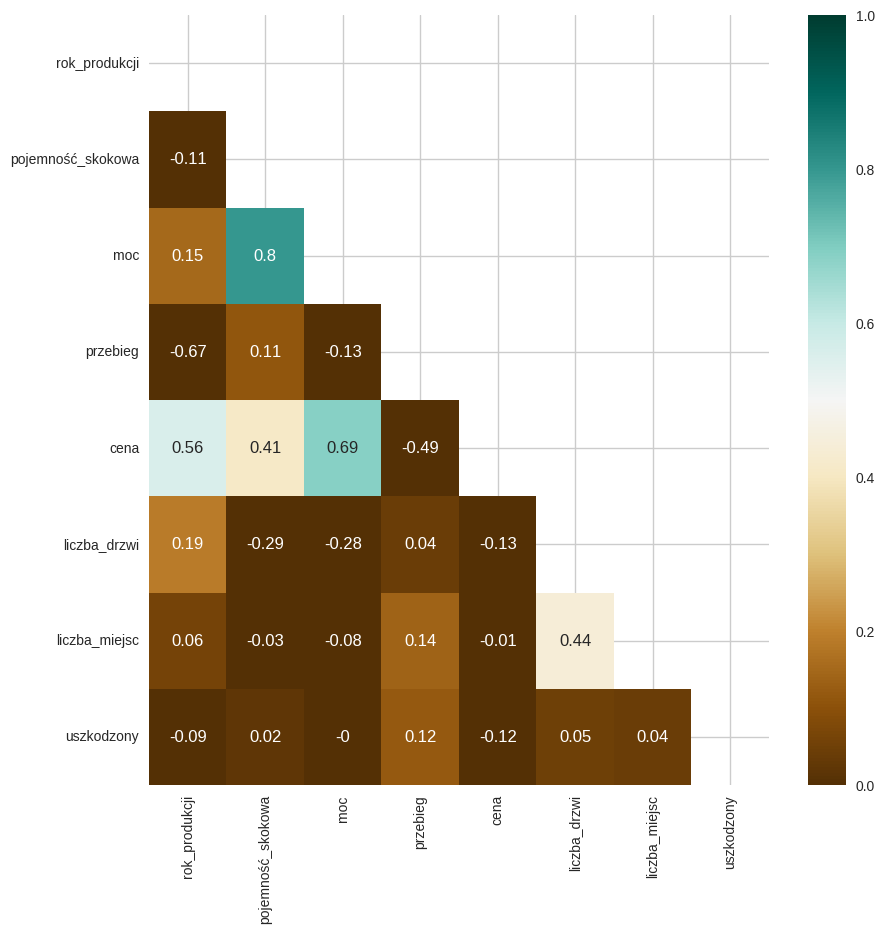

In [ ]:
plt.figure(figsize=(10, 10))
mask = np.triu(np.ones_like(correlations_matrix, dtype=np.bool))
sns.heatmap(correlations_matrix.round(2), mask=mask,
            vmin=0, vmax=1,
            annot=True, cmap='BrBG')
plt.xticks(rotation=90);

In [ ]:
mean_power_capacity_df = pd.pivot_table(data=eda_df, index='rok_produkcji',# columns='typ_nadwozia',
                                        aggfunc={'pojemność_skokowa': 'mean', 'moc': 'mean'})

In [ ]:
mean_power_capacity_df

moc  pojemność_skokowa
rok_produkcji                               
2000.0         154.137615        2249.284404
2001.0         137.762238        2036.657343
2002.0         143.941799        2137.714286
2003.0         142.156364        2081.952727
2004.0         139.794038        2027.588076
2005.0         140.164835        2040.079121
2006.0         133.317147        1924.596358
2007.0         144.113695        2004.480620
2008.0         142.409147        1950.676143
2009.0         129.118705        1766.523981
2010.0         140.840547        1852.882688
2011.0         144.620690        1837.711599
2012.0         152.953349        1887.582536
2013.0         147.298286        1789.902857
2014.0         158.973496        1866.838940
2015.0         166.090828        1885.583259
2016.0         170.310833        1905.133333
2017.0         168.122987        1856.098829
2018.0         168.253082        1790.007787
2019.0         172.071125        1791.852280
2020.0         174.689800        1740.077813
2021.0         174.780702        1673.554825
2022.0         174.578187        1571.793693
2023.0         203.759036        1695.638554

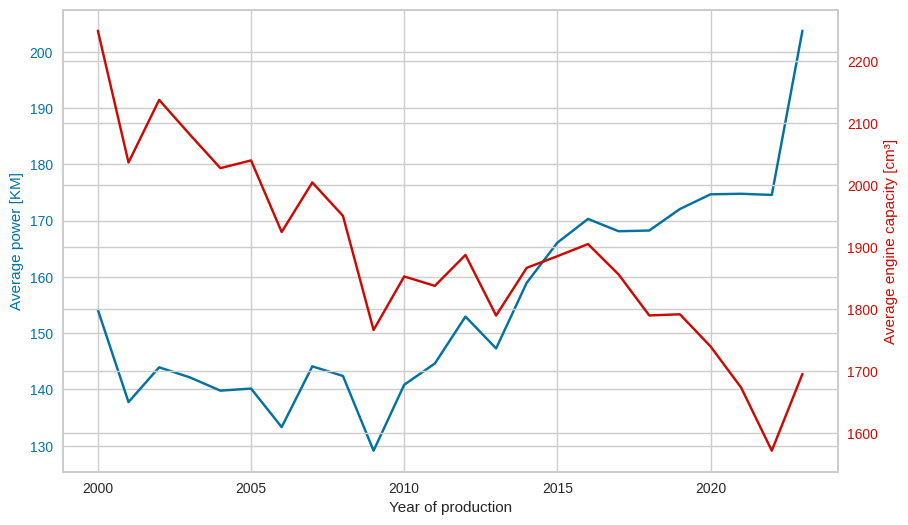

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(mean_power_capacity_df.index, mean_power_capacity_df['moc'], color='b')
ax.set_xlabel('Year of production')
ax.set_ylabel('Average power [KM]', color='b')
ax.tick_params('y', colors='b')

ax2 = ax.twinx()

ax2.plot(mean_power_capacity_df.index, mean_power_capacity_df['pojemność_skokowa'], color='r')
ax2.set_xlabel('Year of production')
ax2.set_ylabel('Average engine capacity [cm³]', color='r')
ax2.tick_params('y', colors='r')

plt.show()

rok_produkcji   cena
rok_produkcji          1.000  0.558
cena                   0.558  1.000

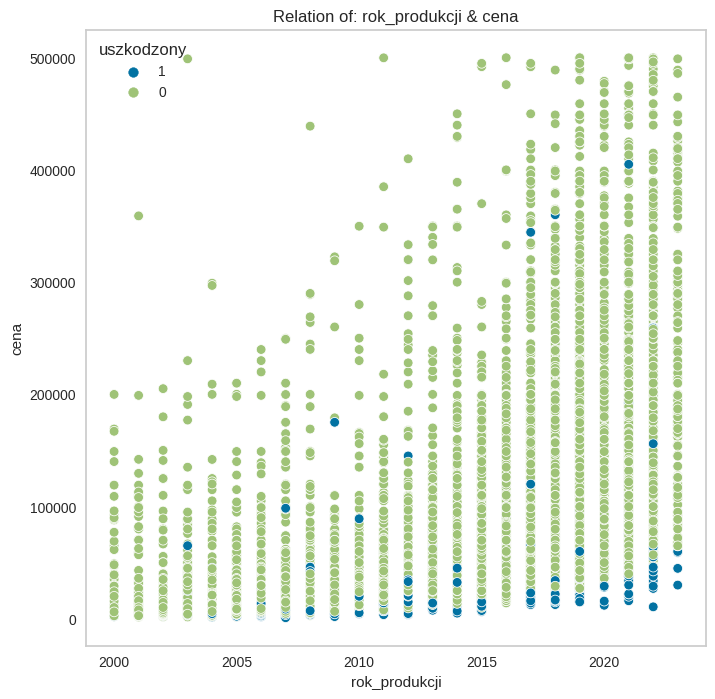

In [ ]:
plot_two_rel(eda_df, 'rok_produkcji', 'cena', hue='uszkodzony',  hue_order=[1, 0])

rok_produkcji  przebieg
rok_produkcji          1.000    -0.675
przebieg              -0.675     1.000

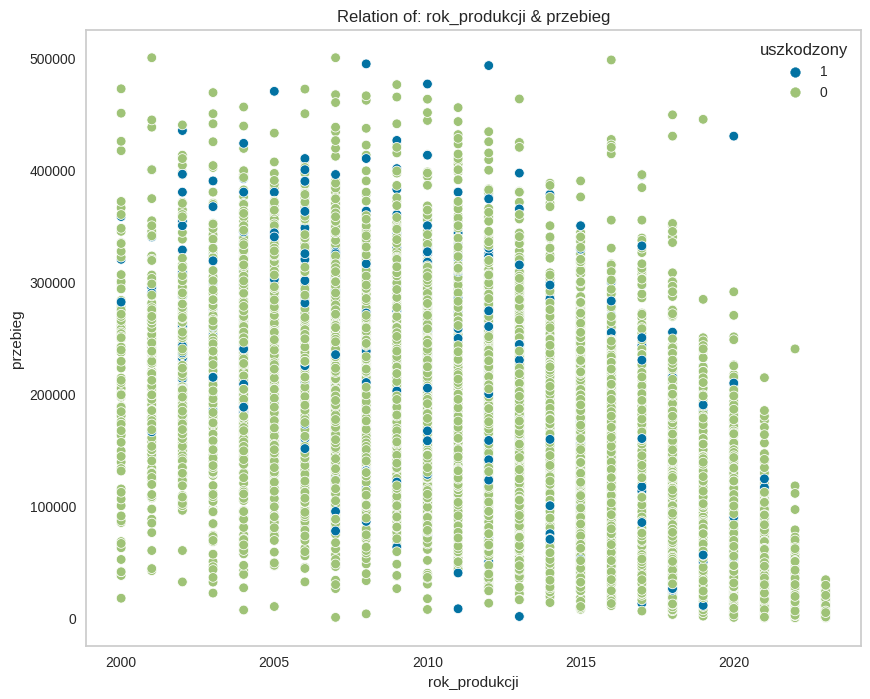

In [ ]:
plot_two_rel(eda_df, X_feat='rok_produkcji', Y_feat='przebieg', hue='uszkodzony', fig_size=(10, 8), hue_order=[1, 0])

moc  pojemność_skokowa
moc                1.000              0.803
pojemność_skokowa  0.803              1.000

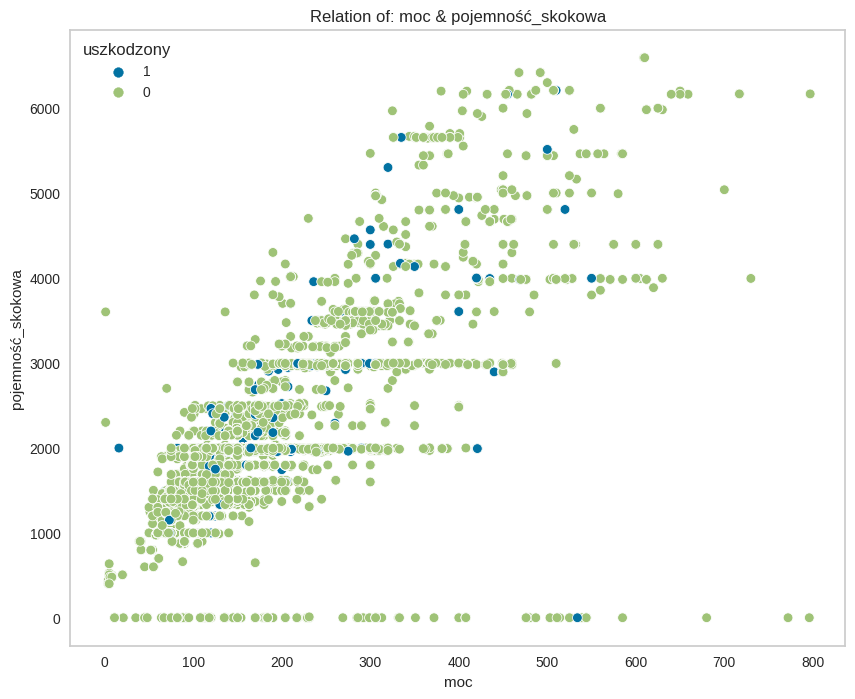

In [ ]:
plot_two_rel(eda_df, 'moc', 'pojemność_skokowa', hue='uszkodzony', fig_size=(10, 8), hue_order=[1, 0])

przebieg   moc
przebieg      1.00 -0.13
moc          -0.13  1.00

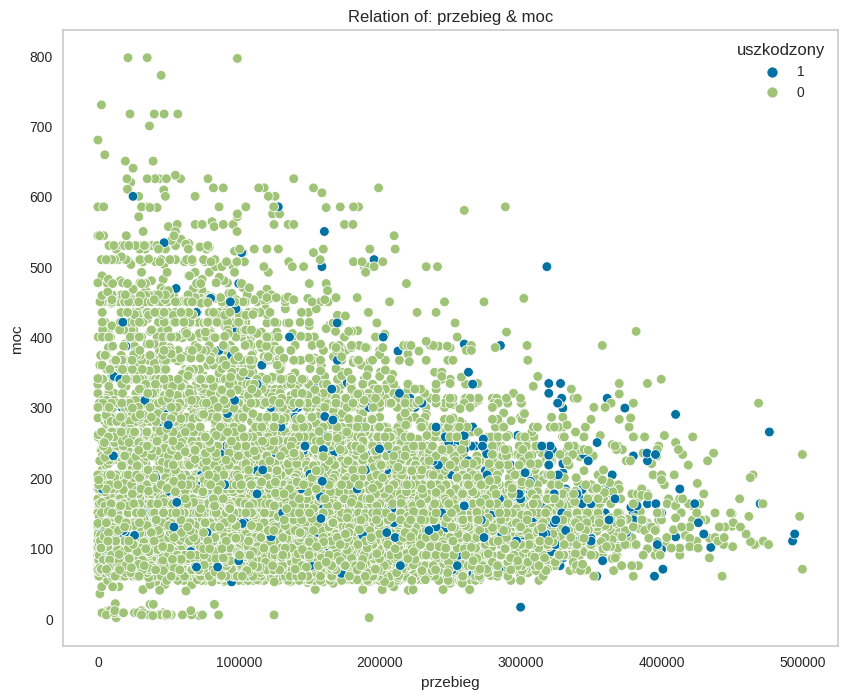

In [ ]:
plot_two_rel(eda_df, X_feat='przebieg', Y_feat='moc', hue='uszkodzony', fig_size=(10, 8), hue_order=[1, 0])

cena  przebieg
cena      1.000    -0.494
przebieg -0.494     1.000

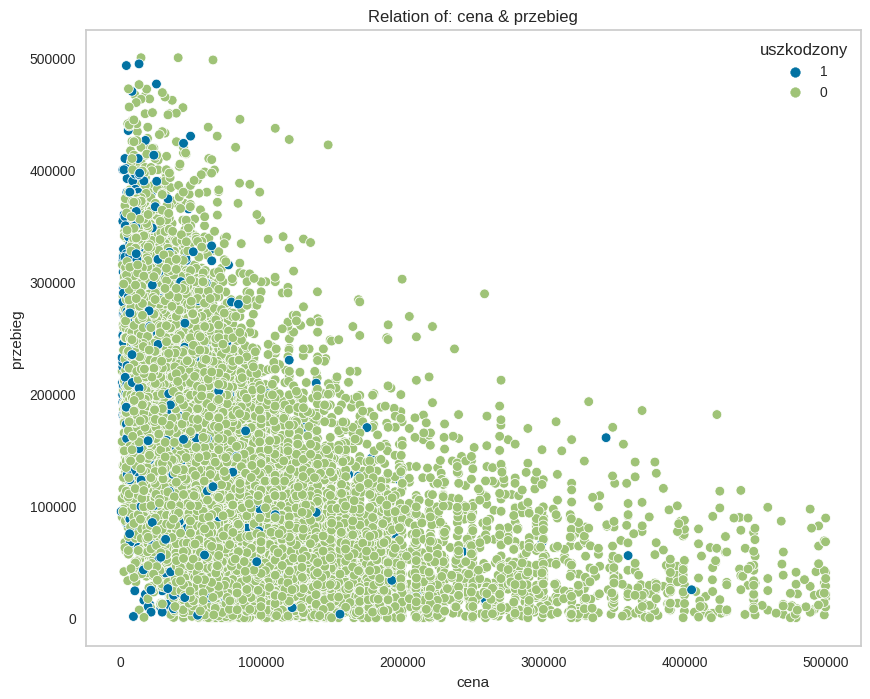

In [ ]:
plot_two_rel(eda_df, X_feat='cena', Y_feat='przebieg', hue='uszkodzony', fig_size=(10, 8), hue_order=[1, 0])

In [ ]:
mean_price_damaged_df = pd.pivot_table(data=eda_df, index='rok_produkcji', columns='uszkodzony',
                                        aggfunc={'cena': 'mean', 'uszkodzony': 'count'}).\
                         rename(columns={'cena': 'średnia_cena', 'uszkodzony': 'liczebność'}).round(0)

mean_price_damaged_df

średnia_cena          liczebność    
uszkodzony               0        1          0   1
rok_produkcji                                     
2000.0             30423.0   3470.0        104   5
2001.0             26628.0   4655.0        130  13
2002.0             21365.0   6131.0        162  27
2003.0             23576.0   9192.0        249  26
2004.0             20526.0   7984.0        332  37
2005.0             21498.0   7113.0        415  40
2006.0             20439.0   8607.0        593  66
2007.0             24635.0  13522.0        709  65
2008.0             26943.0  14391.0        743  66
2009.0             25442.0  19185.0        764  70
2010.0             32212.0  23043.0        810  68
2011.0             36530.0  23568.0        898  59
2012.0             45258.0  29160.0        790  46
2013.0             48699.0  26951.0        844  31
2014.0             59844.0  32962.0        941  40
2015.0             65921.0  42745.0       1067  56
2016.0             77285.0  53696.0       1154  46
2017.0             88095.0  62124.0       1308  58
2018.0             99083.0  57665.0       1490  51
2019.0            110154.0  66078.0       1594  51
2020.0            130730.0  72043.0        914  37
2021.0            148328.0  77547.0        874  38
2022.0            167057.0  80130.0        730  31
2023.0            227444.0  48425.0        162   4

In [ ]:
# Changing columns names to remove MultiIndex
mean_price_damaged_df.columns = ['średnia_cena_sprawne', 'średnia_cena_uszkodzone', 'liczebność_sprawne', 'liczebność_uszkodzone']
mean_price_damaged_df.columns

Index(['średnia_cena_sprawne', 'średnia_cena_uszkodzone', 'liczebność_sprawne',
       'liczebność_uszkodzone'],
      dtype='object')

In [ ]:
# new column
mean_price_damaged_df['%_uszkodzonych'] = round(mean_price_damaged_df['liczebność_uszkodzone'] / (  mean_price_damaged_df['liczebność_sprawne'] + mean_price_damaged_df['liczebność_uszkodzone']), 2)
mean_price_damaged_df

średnia_cena_sprawne  średnia_cena_uszkodzone  \
rok_produkcji                                                  
2000.0                      30423.0                   3470.0   
2001.0                      26628.0                   4655.0   
2002.0                      21365.0                   6131.0   
2003.0                      23576.0                   9192.0   
2004.0                      20526.0                   7984.0   
2005.0                      21498.0                   7113.0   
2006.0                      20439.0                   8607.0   
2007.0                      24635.0                  13522.0   
2008.0                      26943.0                  14391.0   
2009.0                      25442.0                  19185.0   
2010.0                      32212.0                  23043.0   
2011.0                      36530.0                  23568.0   
2012.0                      45258.0                  29160.0   
2013.0                      48699.0                  26951.0   
2014.0                      59844.0                  32962.0   
2015.0                      65921.0                  42745.0   
2016.0                      77285.0                  53696.0   
2017.0                      88095.0                  62124.0   
2018.0                      99083.0                  57665.0   
2019.0                     110154.0                  66078.0   
2020.0                     130730.0                  72043.0   
2021.0                     148328.0                  77547.0   
2022.0                     167057.0                  80130.0   
2023.0                     227444.0                  48425.0   

               liczebność_sprawne  liczebność_uszkodzone  %_uszkodzonych  
rok_produkcji                                                             
2000.0                        104                      5            0.05  
2001.0                        130                     13            0.09  
2002.0                        162                     27            0.14  
2003.0                        249                     26            0.09  
2004.0                        332                     37            0.10  
2005.0                        415                     40            0.09  
2006.0                        593                     66            0.10  
2007.0                        709                     65            0.08  
2008.0                        743                     66            0.08  
2009.0                        764                     70            0.08  
2010.0                        810                     68            0.08  
2011.0                        898                     59            0.06  
2012.0                        790                     46            0.06  
2013.0                        844                     31            0.04  
2014.0                        941                     40            0.04  
2015.0                       1067                     56            0.05  
2016.0                       1154                     46            0.04  
2017.0                       1308                     58            0.04  
2018.0                       1490                     51            0.03  
2019.0                       1594                     51            0.03  
2020.0                        914                     37            0.04  
2021.0                        874                     38            0.04  
2022.0                        730                     31            0.04  
2023.0                        162                      4            0.02

In [ ]:
fig = px.bar(data_frame=mean_price_damaged_df,
             y=['średnia_cena_sprawne', 'średnia_cena_uszkodzone'],
             barmode='group',
             hover_data=['liczebność_sprawne', 'liczebność_uszkodzone'],
             title='Mean price by year')
fig.show()

In [ ]:
fig = px.bar(data_frame=mean_price_damaged_df,
             y=['%_uszkodzonych'],
             title='Percentage of damaged cars by year')
fig.show()

In [ ]:
fig = px.bar(data_frame=mean_price_damaged_df,
             y=['liczebność_sprawne', 'liczebność_uszkodzone'],
             barmode='group',
             title='Number up to a year')
fig.show()

In [ ]:
eda_df['przebieg']

4961     167400
23199    312421
21448     96000
1730     178000
15889    275000
          ...  
7994      79343
6269      32926
14524    300000
2606     270000
23288     56000
Name: przebieg, Length: 18808, dtype: int64

In [ ]:
eda_df['przebieg_przedziały'] = pd.cut(eda_df['przebieg'], bins=[0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000], # np.arange(0, 550000, 50000)
                                       labels=['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-350', '350-400', '400-450', '450-500'])

In [ ]:
mileage_df = pd.pivot_table(data=eda_df, index='przebieg_przedziały', columns=['uszkodzony'],# 'rok_produkcji'],
                                        aggfunc={'cena': 'mean', 'uszkodzony': 'count'}).\
                         rename(columns={'cena': 'średnia_cena', 'uszkodzony': 'liczebność'}).round(0)

mileage_df

średnia_cena          liczebność     
uszkodzony                     0        1          0    1
przebieg_przedziały                                      
0-50                    143757.0  66039.0       2965  108
50-100                   98166.0  65749.0       3451  118
100-150                  66646.0  42075.0       3304  140
150-200                  47326.0  29882.0       3494  162
200-250                  34926.0  20254.0       2462  191
250-300                  30881.0  15976.0       1296  160
300-350                  27072.0  15484.0        555  107
350-400                  27520.0  12230.0        174   33
400-450                  32071.0  20425.0         58    8
450-500                  24953.0  13082.0         18    4

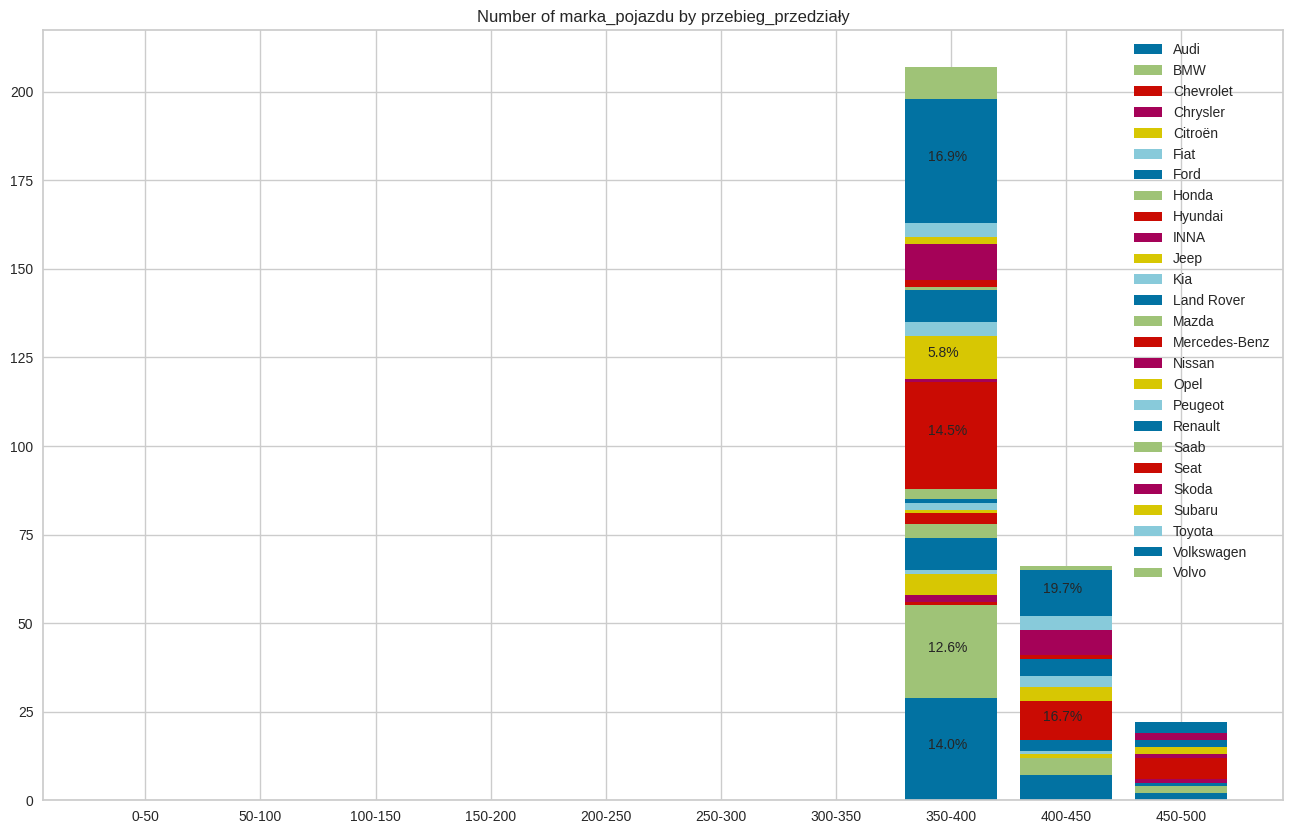

Audi  BMW  Chevrolet  Chrysler  Citroën  Fiat  Ford  \
przebieg_przedziały                                                        
0-50                    0    0          0         0        0     0     0   
50-100                  0    0          0         0        0     0     0   
100-150                 0    0          0         0        0     0     0   
150-200                 0    0          0         0        0     0     0   
200-250                 0    0          0         0        0     0     0   
250-300                 0    0          0         0        0     0     0   
300-350                 0    0          0         0        0     0     0   
350-400                29   26          1         2        6     1     9   
400-450                 7    5          0         0        1     1     3   
450-500                 2    2          0         0        0     0     1   

                     Honda  Hyundai  INNA  Jeep  Kia  Land Rover  Mazda  \
przebieg_przedziały                                                       
0-50                     0        0     0     0    0           0      0   
50-100                   0        0     0     0    0           0      0   
100-150                  0        0     0     0    0           0      0   
150-200                  0        0     0     0    0           0      0   
200-250                  0        0     0     0    0           0      0   
250-300                  0        0     0     0    0           0      0   
300-350                  0        0     0     0    0           0      0   
350-400                  4        3     0     1    2           1      3   
400-450                  0        0     0     0    0           0      0   
450-500                  0        0     1     0    0           0      0   

                     Mercedes-Benz  Nissan  Opel  Peugeot  Renault  Saab  \
przebieg_przedziały                                                        
0-50                             0       0     0        0        0     0   
50-100                           0       0     0        0        0     0   
100-150                          0       0     0        0        0     0   
150-200                          0       0     0        0        0     0   
200-250                          0       0     0        0        0     0   
250-300                          0       0     0        0        0     0   
300-350                          0       0     0        0        0     0   
350-400                         30       1    12        4        9     1   
400-450                         11       0     4        3        5     0   
450-500                          6       1     2        0        2     0   

                     Seat  Skoda  Subaru  Toyota  Volkswagen  Volvo  sum  \
przebieg_przedziały                                                        
0-50                    0      0       0       0           0      0    0   
50-100                  0      0       0       0           0      0    0   
100-150                 0      0       0       0           0      0    0   
150-200                 0      0       0       0           0      0    0   
200-250                 0      0       0       0           0      0    0   
250-300                 0      0       0       0           0      0    0   
300-350                 0      0       0       0           0      0    0   
350-400                 2     10       2       4          35      9  207   
400-450                 1      7       0       4          13      1   66   
450-500                 0      2       0       0           3      0   22   

                     Audi_%  BMW_%  Chevrolet_%  Chrysler_%  Citroën_%  \
przebieg_przedziały                                                      
0-50                    NaN    NaN          NaN         NaN        NaN   
50-100                  NaN    NaN          NaN         NaN        NaN   
100-150                 NaN    NaN          NaN         NaN        NaN   
150-200    

In [ ]:
#### ?
extended_pivot_table_with_chart(df=eda_df[eda_df['przebieg'] > 350000], index_='przebieg_przedziały', column_='marka_pojazdu',  return_pivot_table=True)


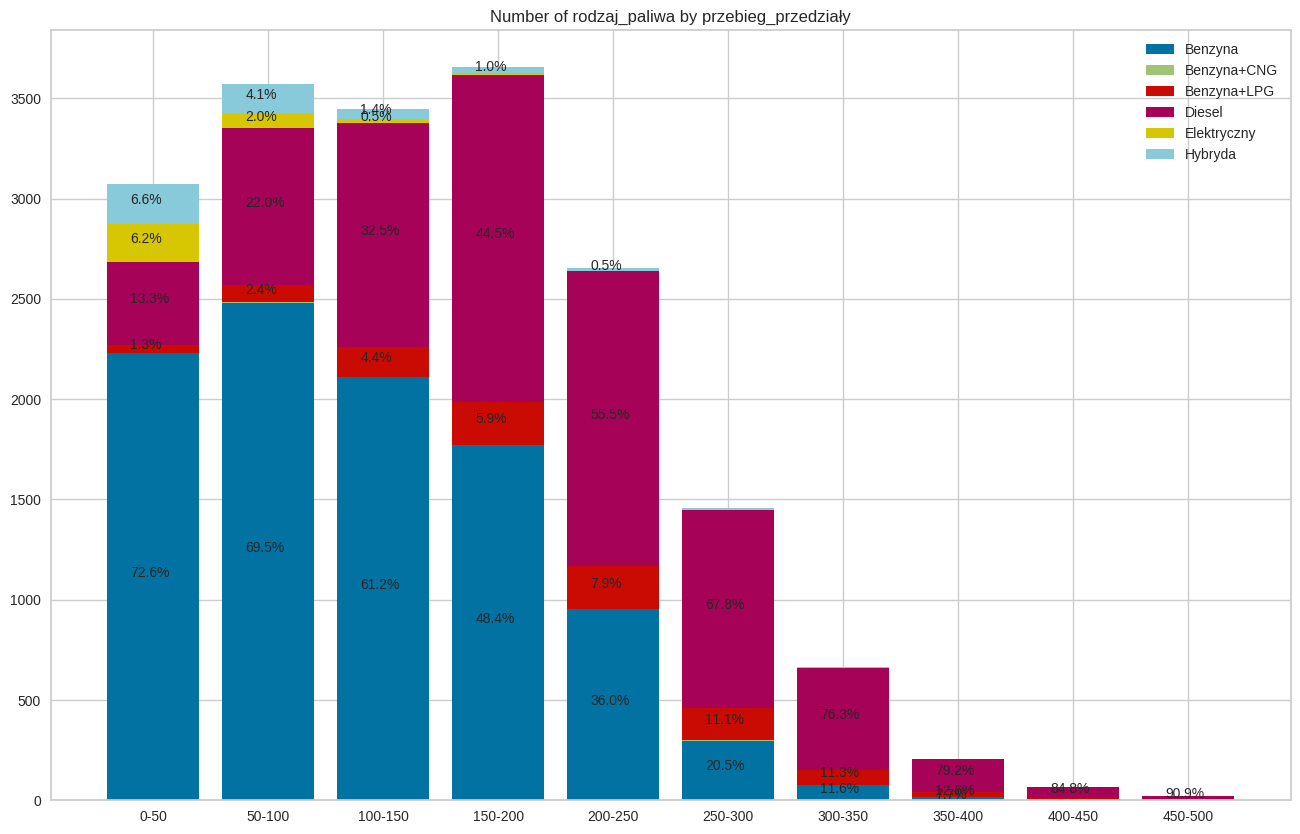

Benzyna  Benzyna+CNG  Benzyna+LPG  Diesel  Elektryczny  \
przebieg_przedziały                                                           
0-50                    2230            1           41     410          189   
50-100                  2480            2           85     784           73   
100-150                 2109            0          151    1118           17   
150-200                 1771            1          216    1628            5   
200-250                  955            1          210    1473            0   
250-300                  298            1          162     987            0   
300-350                   77            0           75     505            0   
350-400                   16            0           26     164            0   
400-450                    4            0            6      56            0   
450-500                    1            0            1      20            0   

                     Hybryda   sum  Benzyna_%  Benzyna+CNG_%  Benzyna+LPG_%  \
przebieg_przedziały                                                           
0-50                     202  3073       72.6            0.0            1.3   
50-100                   145  3569       69.5            0.1            2.4   
100-150                   49  3444       61.2            0.0            4.4   
150-200                   35  3656       48.4            0.0            5.9   
200-250                   14  2653       36.0            0.0            7.9   
250-300                    8  1456       20.5            0.1           11.1   
300-350                    5   662       11.6            0.0           11.3   
350-400                    1   207        7.7            0.0           12.6   
400-450                    0    66        6.1            0.0            9.1   
450-500                    0    22        4.5            0.0            4.5   

                     Diesel_%  Elektryczny_%  Hybryda_%  
przebieg_przedziały                                      
0-50                     13.3            6.2        6.6  
50-100                   22.0            2.0        4.1  
100-150                  32.5            0.5        1.4  
150-200                  44.5            0.1        1.0  
200-250                  55.5            0.0        0.5  
250-300                  67.8            0.0        0.5  
300-350                  76.3            0.0        0.8  
350-400                  79.2            0.0        0.5  
400-450                  84.8            0.0        0.0  
450-500                  90.9            0.0        0.0

In [ ]:
extended_pivot_table_with_chart(df=eda_df, index_='przebieg_przedziały', column_='rodzaj_paliwa',  return_pivot_table=True)

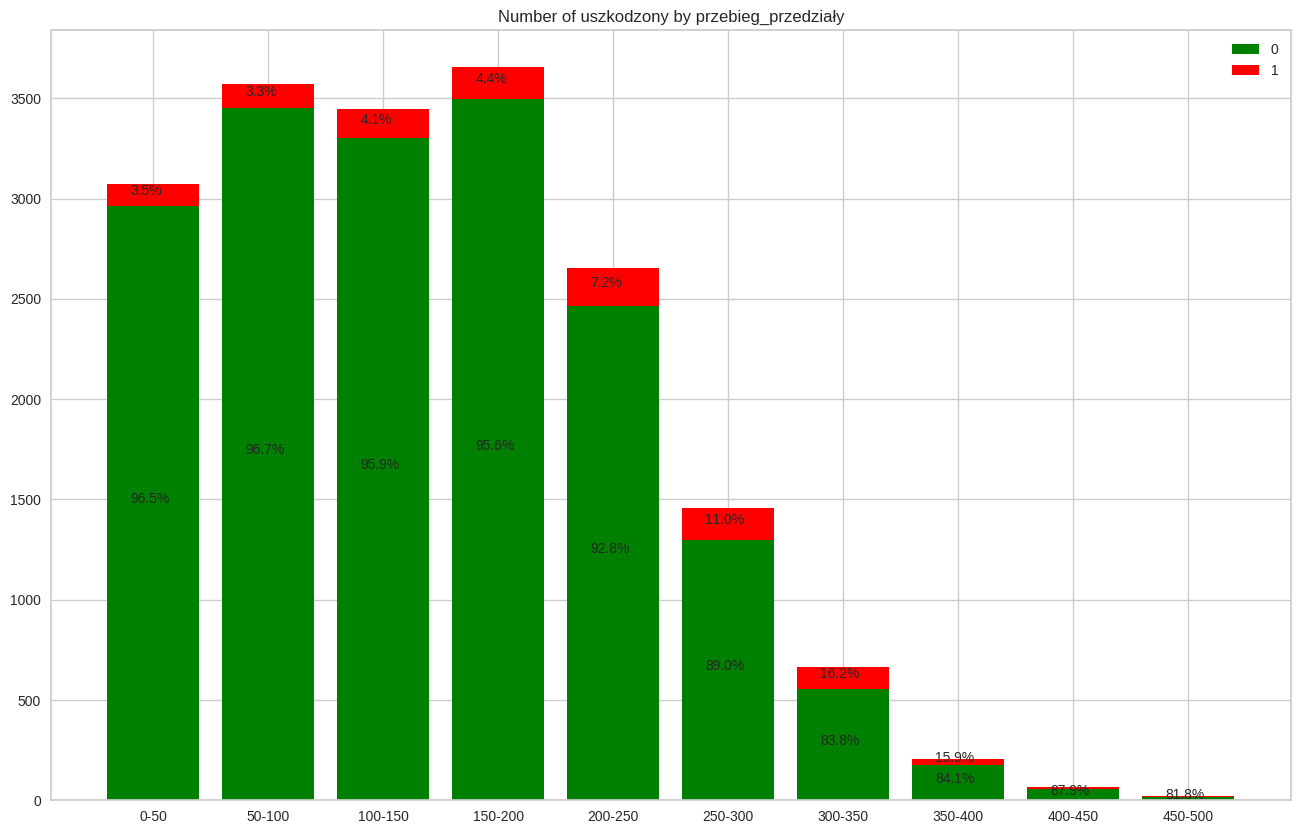

0    1   sum   0_%   1_%
przebieg_przedziały                             
0-50                 2965  108  3073  96.5   3.5
50-100               3451  118  3569  96.7   3.3
100-150              3304  140  3444  95.9   4.1
150-200              3494  162  3656  95.6   4.4
200-250              2462  191  2653  92.8   7.2
250-300              1296  160  1456  89.0  11.0
300-350               555  107   662  83.8  16.2
350-400               174   33   207  84.1  15.9
400-450                58    8    66  87.9  12.1
450-500                18    4    22  81.8  18.2

In [ ]:
extended_pivot_table_with_chart(df=eda_df, index_='przebieg_przedziały', column_='uszkodzony',  return_pivot_table=True)

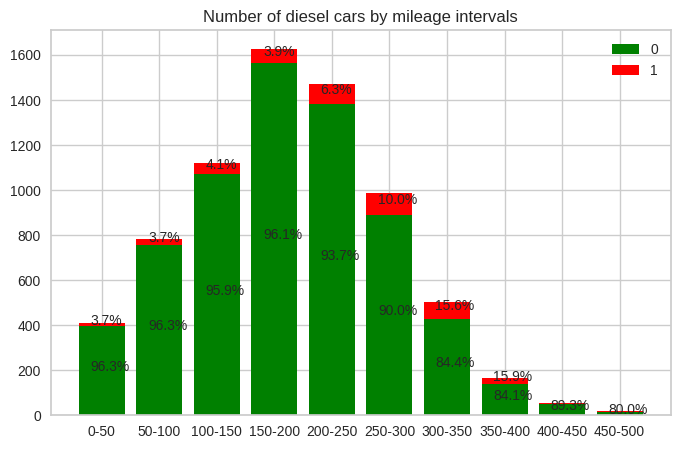

0   1   sum   0_%   1_%
przebieg_przedziały                            
0-50                  395  15   410  96.3   3.7
50-100                755  29   784  96.3   3.7
100-150              1072  46  1118  95.9   4.1
150-200              1564  64  1628  96.1   3.9
200-250              1380  93  1473  93.7   6.3
250-300               888  99   987  90.0  10.0
300-350               426  79   505  84.4  15.6
350-400               138  26   164  84.1  15.9
400-450                50   6    56  89.3  10.7
450-500                16   4    20  80.0  20.0

In [ ]:
extended_pivot_table_with_chart(df=eda_df[eda_df['rodzaj_paliwa'] == 'Diesel'],
                                index_='przebieg_przedziały',
                                column_='uszkodzony',
                                return_pivot_table=True,
                                title='Number of diesel cars by mileage intervals',
                                figsize=(8, 5))

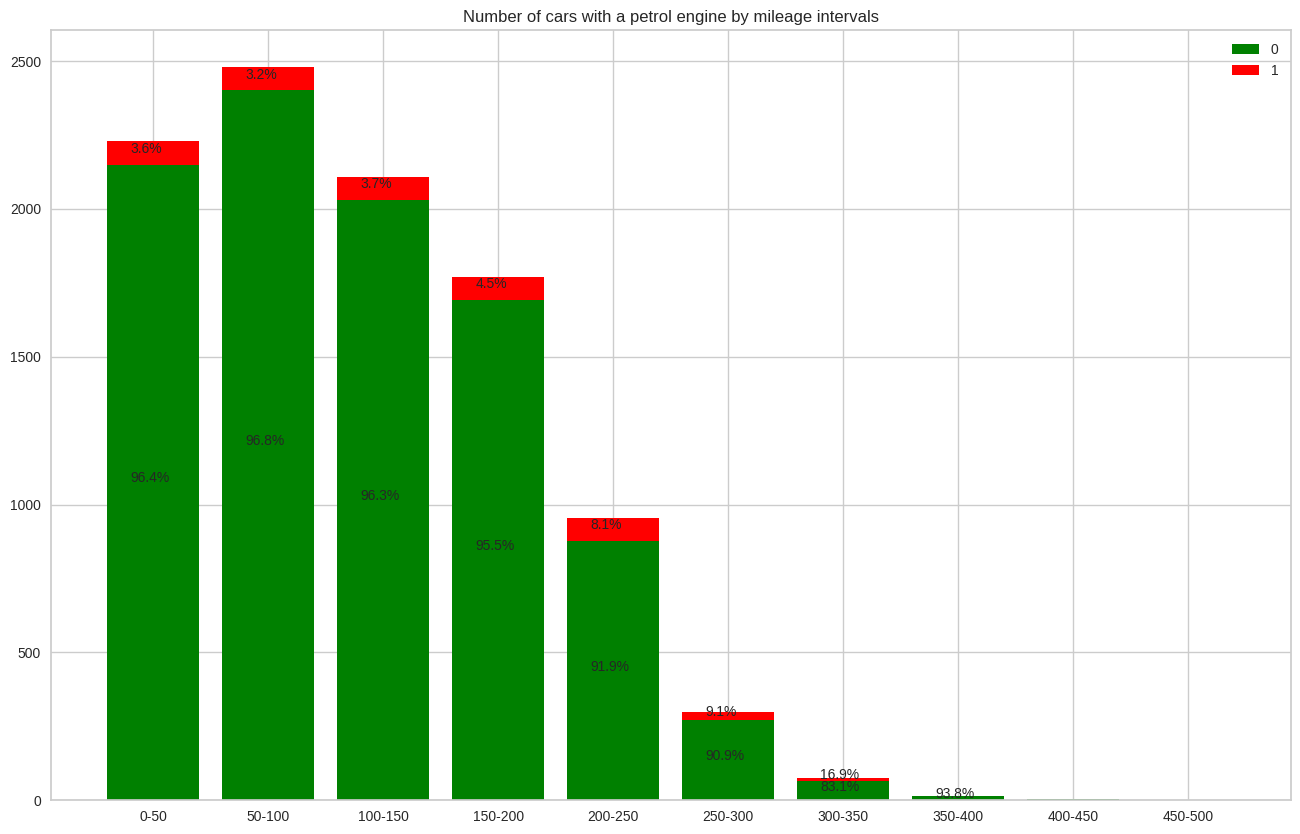

0   1   sum    0_%   1_%
przebieg_przedziały                             
0-50                 2150  80  2230   96.4   3.6
50-100               2401  79  2480   96.8   3.2
100-150              2030  79  2109   96.3   3.7
150-200              1692  79  1771   95.5   4.5
200-250               878  77   955   91.9   8.1
250-300               271  27   298   90.9   9.1
300-350                64  13    77   83.1  16.9
350-400                15   1    16   93.8   6.2
400-450                 3   1     4   75.0  25.0
450-500                 1   0     1  100.0   0.0

In [ ]:
extended_pivot_table_with_chart(df=eda_df[eda_df['rodzaj_paliwa'] == 'Benzyna'],
                                index_='przebieg_przedziały',
                                column_='uszkodzony',
                                return_pivot_table=True,
                                title='Number of cars with a petrol engine by mileage intervals')

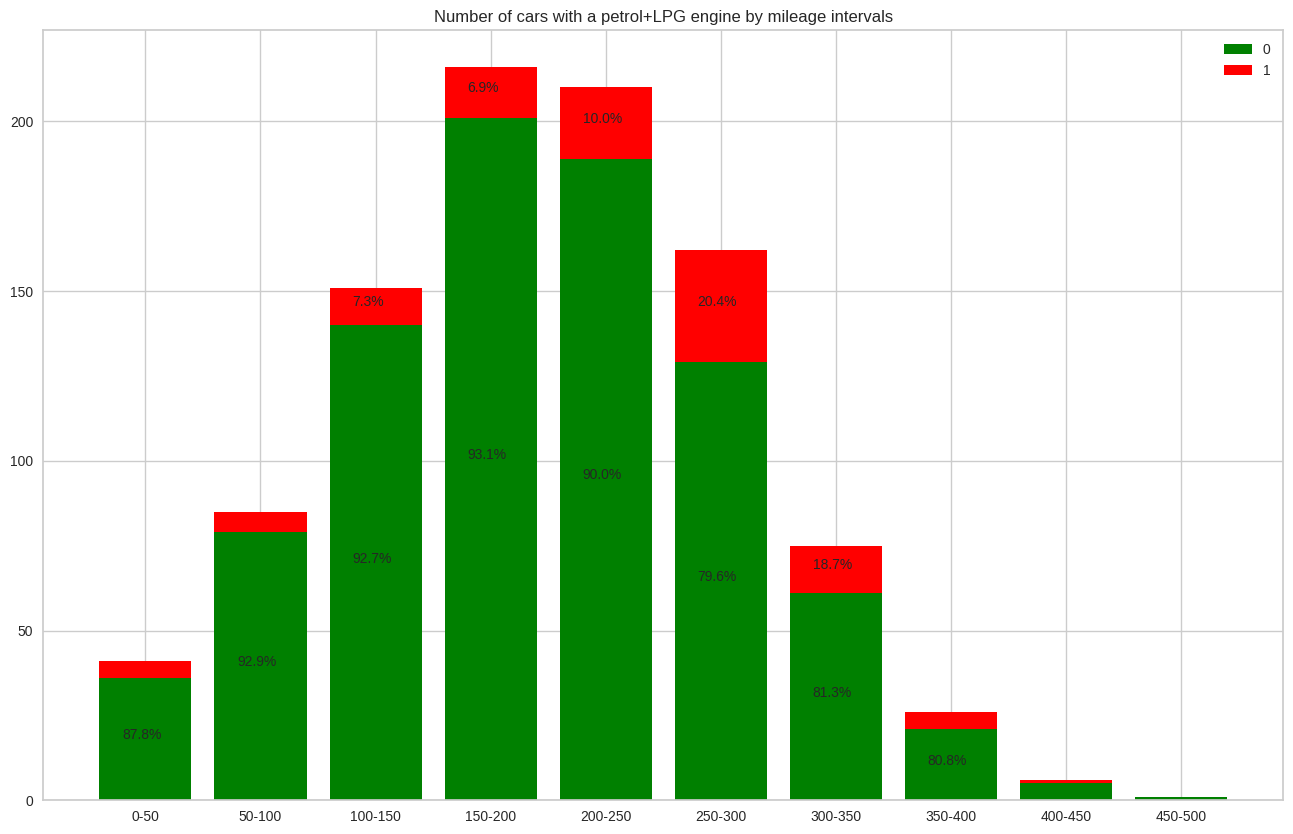

0   1  sum    0_%   1_%
przebieg_przedziały                           
0-50                  36   5   41   87.8  12.2
50-100                79   6   85   92.9   7.1
100-150              140  11  151   92.7   7.3
150-200              201  15  216   93.1   6.9
200-250              189  21  210   90.0  10.0
250-300              129  33  162   79.6  20.4
300-350               61  14   75   81.3  18.7
350-400               21   5   26   80.8  19.2
400-450                5   1    6   83.3  16.7
450-500                1   0    1  100.0   0.0

In [ ]:
extended_pivot_table_with_chart(df=eda_df[eda_df['rodzaj_paliwa'] == 'Benzyna+LPG'],
                                index_='przebieg_przedziały',
                                column_='uszkodzony',
                                return_pivot_table=True,
                                title='Number of cars with a petrol+LPG engine by mileage intervals')

In [ ]:
agg_data(eda_df, 'marka_pojazdu', 'cena').sort_values("perc_50", ascending = False) # perc_50 == median
# Mediana, wartość środkowa, drugi kwartyl – wartość cechy w szeregu uporządkowanym,
# powyżej i poniżej której znajduje się jednakowa liczba obserwacji. Mediana jest kwantylem rzędu 1/2, czyli drugim kwartylem.

In [ ]:
agg_data(eda_df, 'rodzaj_paliwa', 'przebieg').sort_values("perc_50", ascending = False)

In [ ]:
agg_data(eda_df, 'typ_nadwozia', 'przebieg').sort_values("perc_50", ascending = False)

In [ ]:
eda_df['cena']

4961     38950.0
23199    39000.0
21448    75000.0
1730     24700.0
15889     9999.0
          ...   
7994     59900.0
6269     42900.0
14524    58794.0
2606     15900.0
23288    59900.0
Name: cena, Length: 18808, dtype: float64

In [ ]:
step = 25000

intervals = np.arange(0, 500000+step, step)
intervals

array([     0,  25000,  50000,  75000, 100000, 125000, 150000, 175000,
       200000, 225000, 250000, 275000, 300000, 325000, 350000, 375000,
       400000, 425000, 450000, 475000, 500000])

In [ ]:
labels = [f'{i}-{i+step}' for i in intervals[:-1]]
labels

['0-25000',
 '25000-50000',
 '50000-75000',
 '75000-100000',
 '100000-125000',
 '125000-150000',
 '150000-175000',
 '175000-200000',
 '200000-225000',
 '225000-250000',
 '250000-275000',
 '275000-300000',
 '300000-325000',
 '325000-350000',
 '350000-375000',
 '375000-400000',
 '400000-425000',
 '425000-450000',
 '450000-475000',
 '475000-500000']

In [ ]:
eda_df['cena_przedziały'] = pd.cut(eda_df['cena'], bins=intervals,
                                       labels=labels)

In [ ]:
eda_df[['cena', 'cena_przedziały']]

cena cena_przedziały
4961   38950.0     25000-50000
23199  39000.0     25000-50000
21448  75000.0     50000-75000
1730   24700.0         0-25000
15889   9999.0         0-25000
...        ...             ...
7994   59900.0     50000-75000
6269   42900.0     25000-50000
14524  58794.0     50000-75000
2606   15900.0         0-25000
23288  59900.0     50000-75000

[18808 rows x 2 columns]

In [ ]:
price_df = pd.pivot_table(data=eda_df, index='cena_przedziały', columns=['uszkodzony'],# 'rok_produkcji'],
                                        aggfunc={'cena': 'mean', 'uszkodzony': 'count'}).\
                         rename(columns={'cena': 'średnia_cena', 'uszkodzony': 'liczebność'}).round(0)

price_df

średnia_cena           liczebność     
uszkodzony                 0         1          0    1
cena_przedziały                                       
0-25000              15446.0   11176.0       4518  593
25000-50000          37564.0   36637.0       4525  232
50000-75000          62696.0   61187.0       3042  109
75000-100000         87581.0   86748.0       2005   42
100000-125000       113784.0  112405.0        929   21
125000-150000       138073.0  138142.0        769   12
150000-175000       163032.0  164186.0        479    8
175000-200000       188963.0  190520.0        401    5
200000-225000       215025.0  214600.0        228    2
225000-250000       238571.0  242900.0        211    1
250000-275000       265101.0  259000.0        133    2
275000-300000       290646.0  299000.0        157    1
300000-325000       315771.0       NaN         73    0
325000-350000       339707.0  344400.0         66    1
350000-375000       363988.0  359999.0         47    1
375000-400000       390360.0       NaN         67    0
400000-425000       416998.0  405000.0         28    1
425000-450000       442210.0       NaN         41    0
450000-475000       465994.0       NaN         17    0
475000-500000       491383.0       NaN         41    0

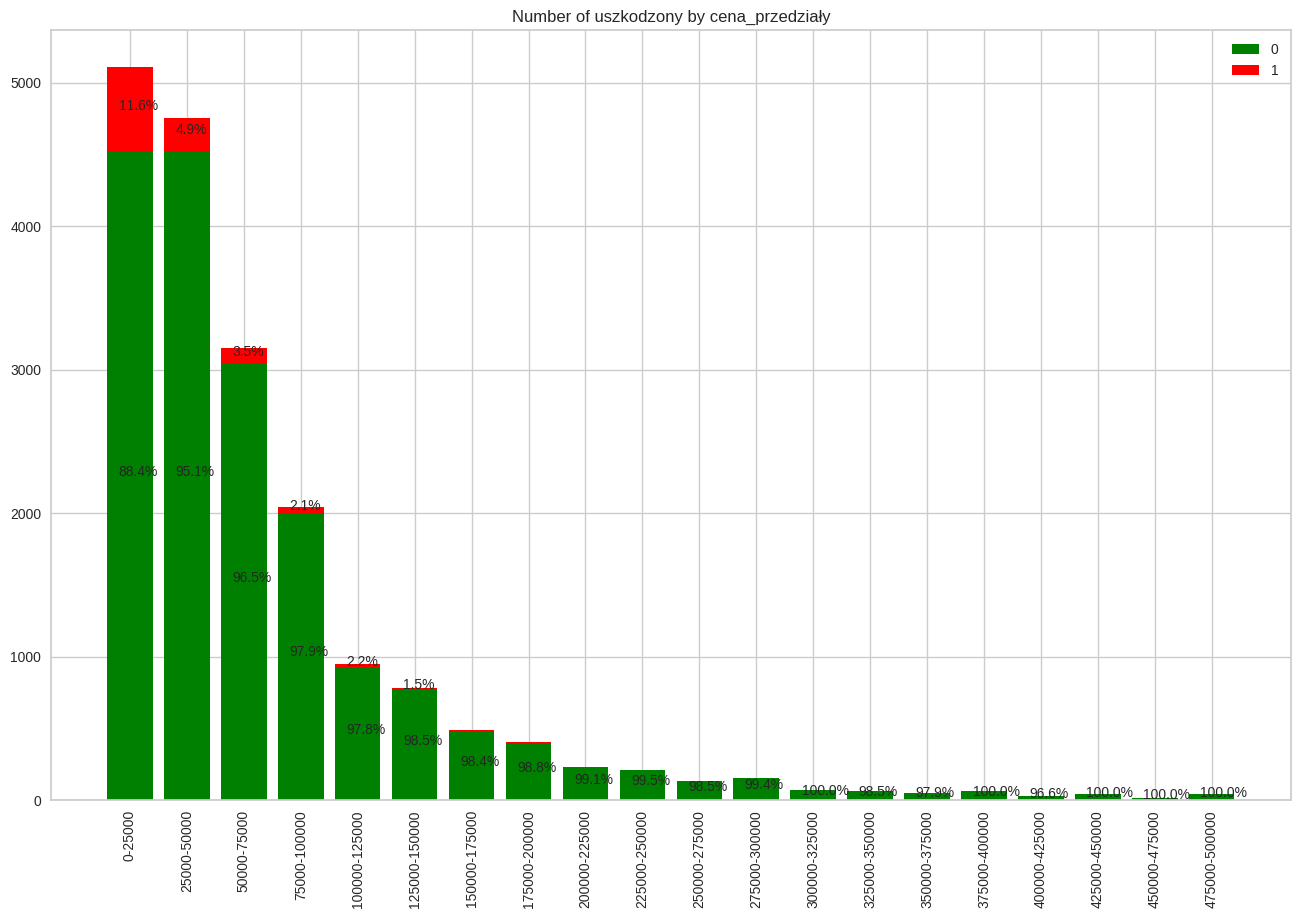

0    1   sum    0_%   1_%
cena_przedziały                              
0-25000          4518  593  5111   88.4  11.6
25000-50000      4525  232  4757   95.1   4.9
50000-75000      3042  109  3151   96.5   3.5
75000-100000     2005   42  2047   97.9   2.1
100000-125000     929   21   950   97.8   2.2
125000-150000     769   12   781   98.5   1.5
150000-175000     479    8   487   98.4   1.6
175000-200000     401    5   406   98.8   1.2
200000-225000     228    2   230   99.1   0.9
225000-250000     211    1   212   99.5   0.5
250000-275000     133    2   135   98.5   1.5
275000-300000     157    1   158   99.4   0.6
300000-325000      73    0    73  100.0   0.0
325000-350000      66    1    67   98.5   1.5
350000-375000      47    1    48   97.9   2.1
375000-400000      67    0    67  100.0   0.0
400000-425000      28    1    29   96.6   3.4
425000-450000      41    0    41  100.0   0.0
450000-475000      17    0    17  100.0   0.0
475000-500000      41    0    41  100.0   0.0

In [ ]:
extended_pivot_table_with_chart(df=eda_df, index_='cena_przedziały', column_='uszkodzony',  return_pivot_table=True)

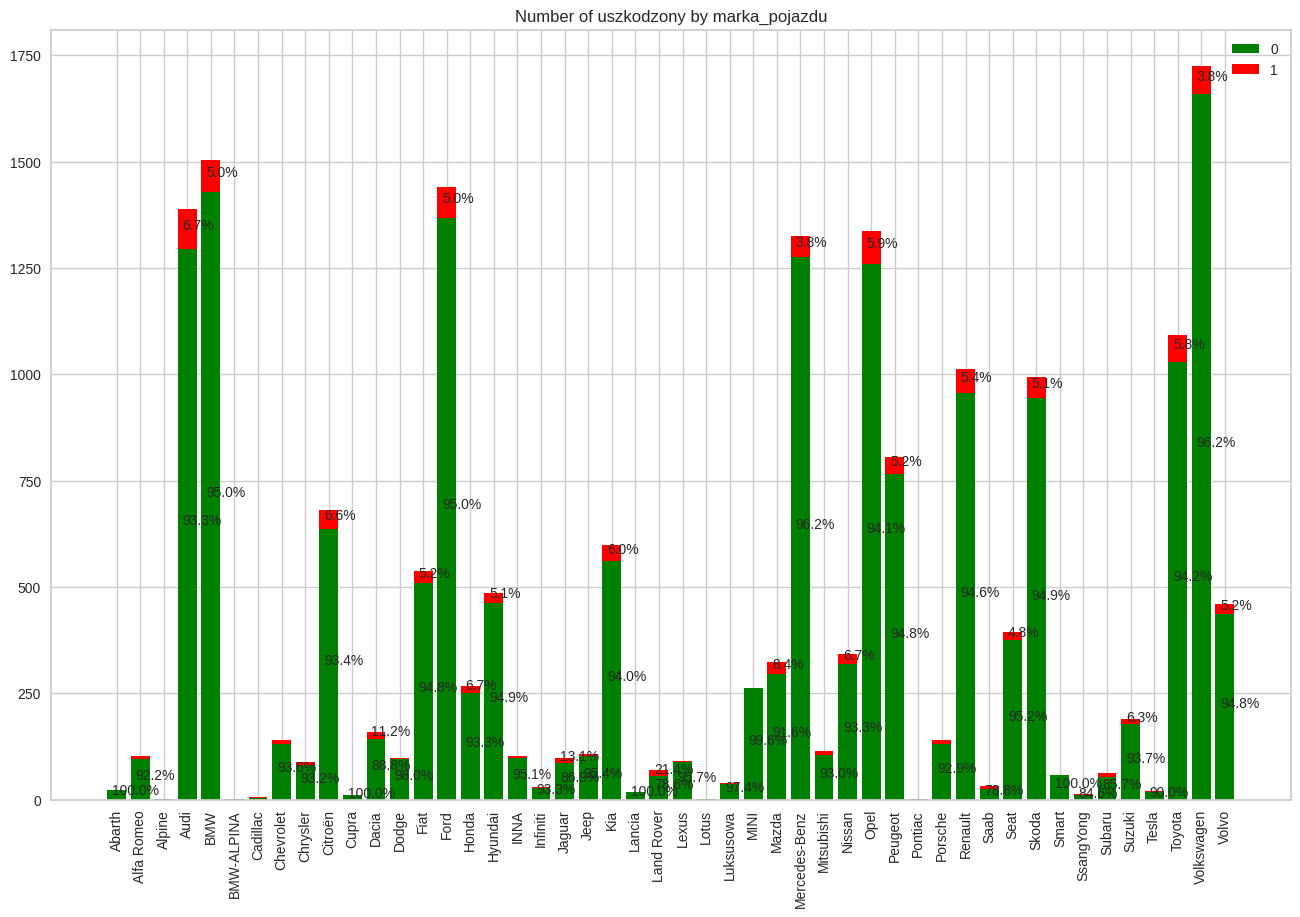

0     1     sum    0_%   1_%
marka_pojazdu                                   
Abarth           24.0   0.0    24.0  100.0   0.0
Alfa Romeo       95.0   8.0   103.0   92.2   7.8
Alpine            2.0   0.0     2.0  100.0   0.0
Audi           1295.0  93.0  1388.0   93.3   6.7
BMW            1428.0  75.0  1503.0   95.0   5.0
BMW-ALPINA        2.0   0.0     2.0  100.0   0.0
Cadillac          5.0   1.0     6.0   83.3  16.7
Chevrolet       132.0   9.0   141.0   93.6   6.4
Chrysler         82.0   6.0    88.0   93.2   6.8
Citroën         636.0  45.0   681.0   93.4   6.6
Cupra            11.0   0.0    11.0  100.0   0.0
Dacia           142.0  18.0   160.0   88.8  11.2
Dodge            97.0   2.0    99.0   98.0   2.0
Fiat            509.0  28.0   537.0   94.8   5.2
Ford           1368.0  72.0  1440.0   95.0   5.0
Honda           250.0  18.0   268.0   93.3   6.7
Hyundai         462.0  25.0   487.0   94.9   5.1
INNA             98.0   5.0   103.0   95.1   4.9
Infiniti         28.0   2.0    30.0   93.3   6.7
Jaguar           86.0  13.0    99.0   86.9  13.1
Jeep            103.0   5.0   108.0   95.4   4.6
Kia             562.0  36.0   598.0   94.0   6.0
Lancia           19.0   0.0    19.0  100.0   0.0
Land Rover       55.0  15.0    70.0   78.6  21.4
Lexus            88.0   4.0    92.0   95.7   4.3
Lotus             1.0   0.0     1.0  100.0   0.0
Luksusowa        38.0   1.0    39.0   97.4   2.6
MINI            262.0   1.0   263.0   99.6   0.4
Mazda           296.0  27.0   323.0   91.6   8.4
Mercedes-Benz  1275.0  51.0  1326.0   96.2   3.8
Mitsubishi      106.0   8.0   114.0   93.0   7.0
Nissan          319.0  23.0   342.0   93.3   6.7
Opel           1259.0  79.0  1338.0   94.1   5.9
Peugeot         765.0  42.0   807.0   94.8   5.2
Pontiac           1.0   0.0     1.0  100.0   0.0
Porsche         130.0  10.0   140.0   92.9   7.1
Renault         957.0  55.0  1012.0   94.6   5.4
Saab             26.0   7.0    33.0   78.8  21.2
Seat            375.0  19.0   394.0   95.2   4.8
Skoda           944.0  51.0   995.0   94.9   5.1
Smart            59.0   0.0    59.0  100.0   0.0
SsangYong        11.0   2.0    13.0   84.6  15.4
Subaru           54.0   9.0    63.0   85.7  14.3
Suzuki          177.0  12.0   189.0   93.7   6.3
Tesla            18.0   2.0    20.0   90.0  10.0
Toyota         1030.0  63.0  1093.0   94.2   5.8
Volkswagen     1659.0  65.0  1724.0   96.2   3.8
Volvo           436.0  24.0   460.0   94.8   5.2

In [ ]:
brand_damaged = extended_pivot_table_with_chart(df=eda_df, index_='marka_pojazdu', column_='uszkodzony',  return_pivot_table=True)
brand_damaged

In [ ]:
# filtered previous dataframe (brand with over 50 ads)
brand_damaged_2 = brand_damaged[(brand_damaged['sum'] >= 50) & (brand_damaged['1_%'] >= 5)].sort_values('1_%', ascending=False)
brand_damaged_2

0     1     sum   0_%   1_%
marka_pojazdu                                  
Land Rover       55.0  15.0    70.0  78.6  21.4
Subaru           54.0   9.0    63.0  85.7  14.3
Jaguar           86.0  13.0    99.0  86.9  13.1
Dacia           142.0  18.0   160.0  88.8  11.2
Mazda           296.0  27.0   323.0  91.6   8.4
Alfa Romeo       95.0   8.0   103.0  92.2   7.8
Porsche         130.0  10.0   140.0  92.9   7.1
Mitsubishi      106.0   8.0   114.0  93.0   7.0
Chrysler         82.0   6.0    88.0  93.2   6.8
Nissan          319.0  23.0   342.0  93.3   6.7
Audi           1295.0  93.0  1388.0  93.3   6.7
Honda           250.0  18.0   268.0  93.3   6.7
Citroën         636.0  45.0   681.0  93.4   6.6
Chevrolet       132.0   9.0   141.0  93.6   6.4
Suzuki          177.0  12.0   189.0  93.7   6.3
Kia             562.0  36.0   598.0  94.0   6.0
Opel           1259.0  79.0  1338.0  94.1   5.9
Toyota         1030.0  63.0  1093.0  94.2   5.8
Renault         957.0  55.0  1012.0  94.6   5.4
Fiat            509.0  28.0   537.0  94.8   5.2
Peugeot         765.0  42.0   807.0  94.8   5.2
Volvo           436.0  24.0   460.0  94.8   5.2
Hyundai         462.0  25.0   487.0  94.9   5.1
Skoda           944.0  51.0   995.0  94.9   5.1
Ford           1368.0  72.0  1440.0  95.0   5.0
BMW            1428.0  75.0  1503.0  95.0   5.0

In [ ]:
brand_damaged[(brand_damaged['sum'] >= 50) & (brand_damaged['1_%'] < 5)].sort_values('1_%', ascending=True)

0     1     sum    0_%  1_%
marka_pojazdu                                  
Smart            59.0   0.0    59.0  100.0  0.0
MINI            262.0   1.0   263.0   99.6  0.4
Dodge            97.0   2.0    99.0   98.0  2.0
Mercedes-Benz  1275.0  51.0  1326.0   96.2  3.8
Volkswagen     1659.0  65.0  1724.0   96.2  3.8
Lexus            88.0   4.0    92.0   95.7  4.3
Jeep            103.0   5.0   108.0   95.4  4.6
Seat            375.0  19.0   394.0   95.2  4.8
INNA             98.0   5.0   103.0   95.1  4.9

In [ ]:
fig = px.bar(data_frame=brand_damaged_2,
             barmode='relative',
             y=[0, 1],
             hover_data=['0_%', '1_%'],
             title='Damaged and undamaged cars by brand',
             labels={'marka_pojazdu': 'brand', 'value': 'cardinality'},
             )

fig.show()

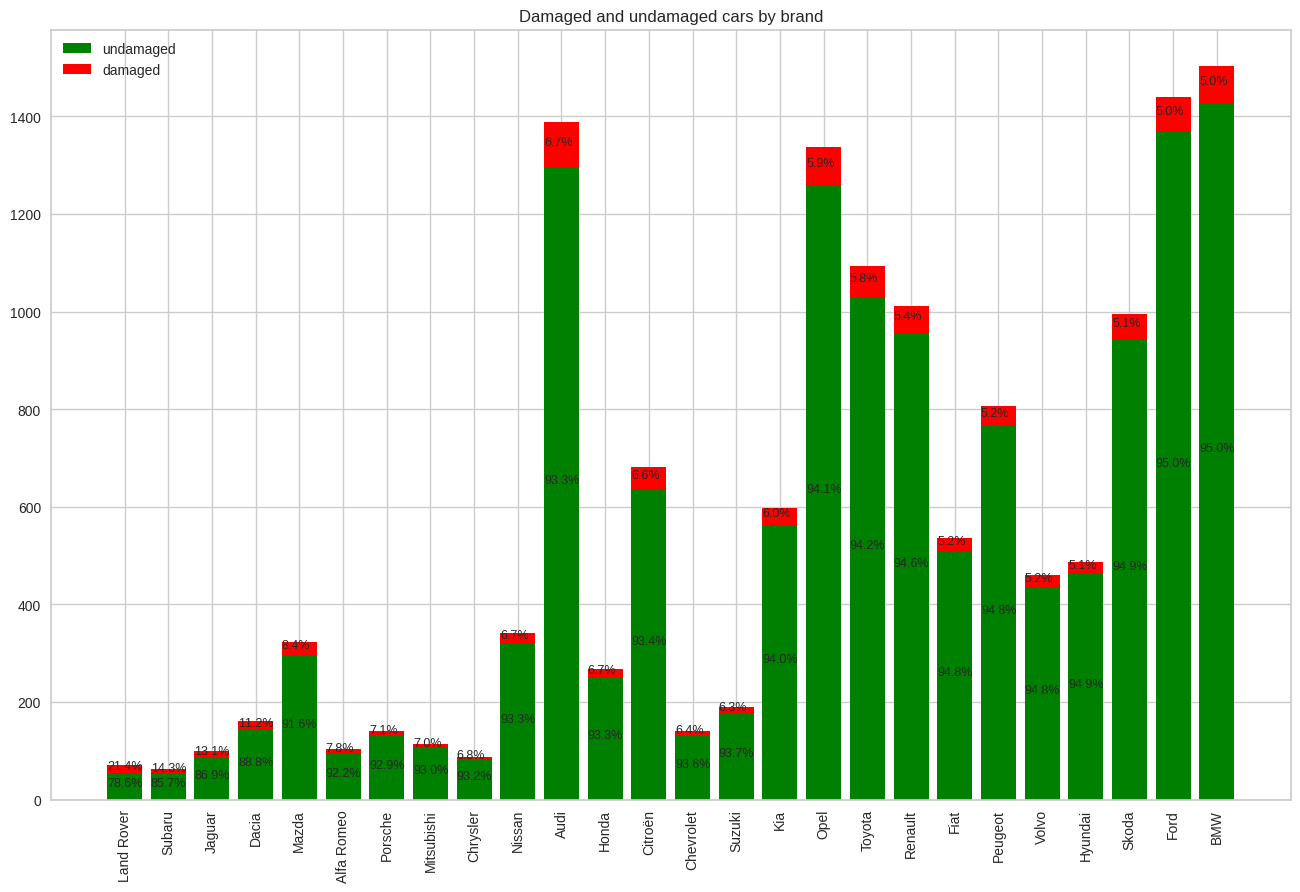

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))

ax.bar(brand_damaged_2.index, brand_damaged_2[0], label='undamaged', color='green')

# annotate
for i in range(len(brand_damaged_2.index)):
        plt.text(i-0.4, brand_damaged_2[0][i]/2, f"{brand_damaged_2['0_%'][i]}%", fontsize=9)

ax.bar(brand_damaged_2.index, brand_damaged_2[1], bottom=brand_damaged_2[0], label='damaged', color='red')
# annotate
for i in range(len(brand_damaged_2.index)):
        plt.text(i-0.4, brand_damaged_2[1][i]/2 + brand_damaged_2[0][i], f"{brand_damaged_2['1_%'][i]}%", fontsize=9)

ax.tick_params('x', labelrotation=90)
ax.set_title('Damaged and undamaged cars by brand')

ax.legend()
plt.show()

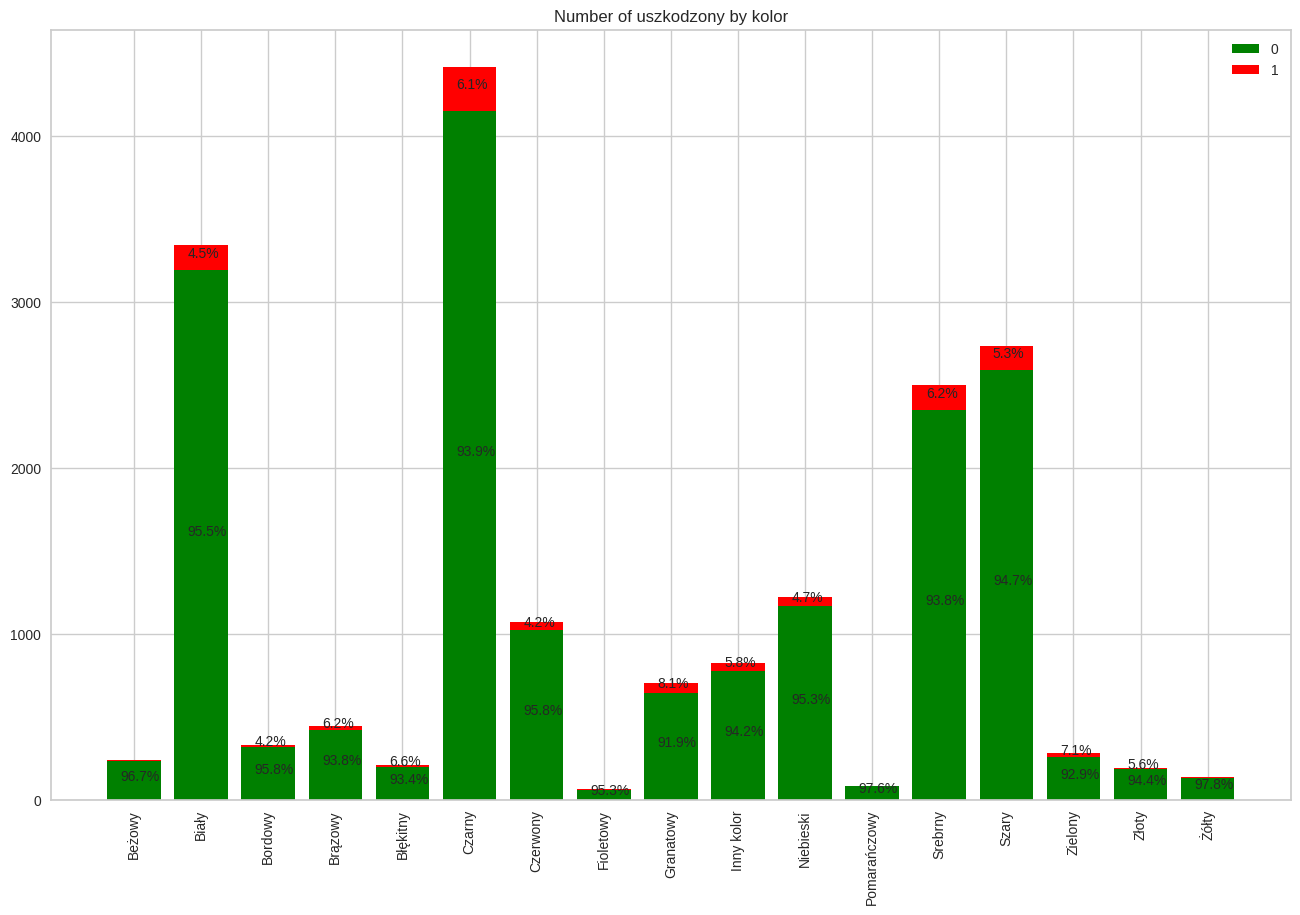

0    1   sum   0_%  1_%
kolor                                   
Beżowy         234    8   242  96.7  3.3
Biały         3189  152  3341  95.5  4.5
Bordowy        319   14   333  95.8  4.2
Brązowy        420   28   448  93.8  6.2
Błękitny       199   14   213  93.4  6.6
Czarny        4146  270  4416  93.9  6.1
Czerwony      1024   45  1069  95.8  4.2
Fioletowy       61    3    64  95.3  4.7
Granatowy      646   57   703  91.9  8.1
Inny kolor     776   48   824  94.2  5.8
Niebieski     1165   57  1222  95.3  4.7
Pomarańczowy    83    2    85  97.6  2.4
Srebrny       2347  154  2501  93.8  6.2
Szary         2591  145  2736  94.7  5.3
Zielony        260   20   280  92.9  7.1
Złoty          184   11   195  94.4  5.6
Żółty          133    3   136  97.8  2.2

In [ ]:
extended_pivot_table_with_chart(df=eda_df, index_='kolor', column_='uszkodzony',  return_pivot_table=True)

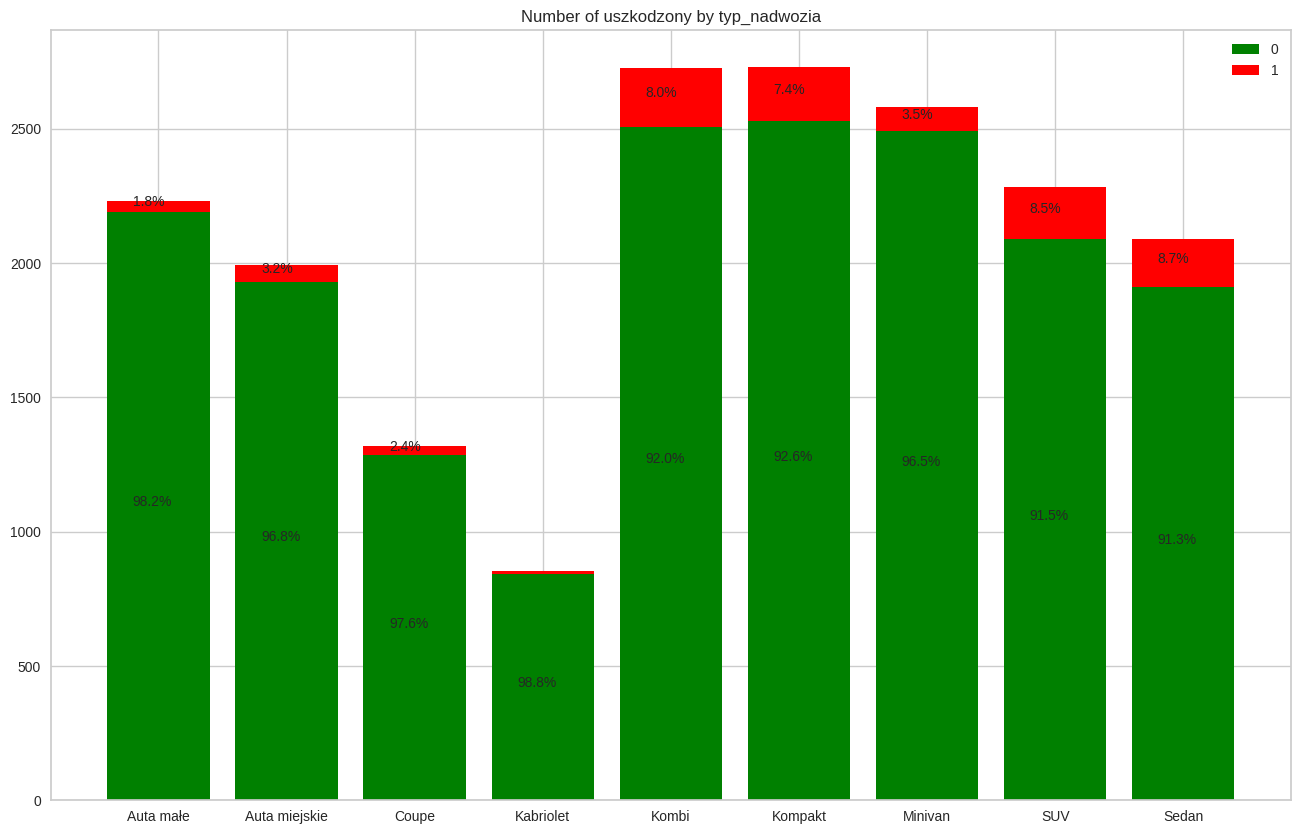

0    1   sum   0_%  1_%
typ_nadwozia                             
Auta małe      2191   41  2232  98.2  1.8
Auta miejskie  1930   63  1993  96.8  3.2
Coupe          1286   32  1318  97.6  2.4
Kabriolet       844   10   854  98.8  1.2
Kombi          2508  218  2726  92.0  8.0
Kompakt        2529  201  2730  92.6  7.4
Minivan        2490   91  2581  96.5  3.5
SUV            2089  194  2283  91.5  8.5
Sedan          1910  181  2091  91.3  8.7

In [ ]:
extended_pivot_table_with_chart(df=eda_df, index_='typ_nadwozia', column_='uszkodzony',  return_pivot_table=True)

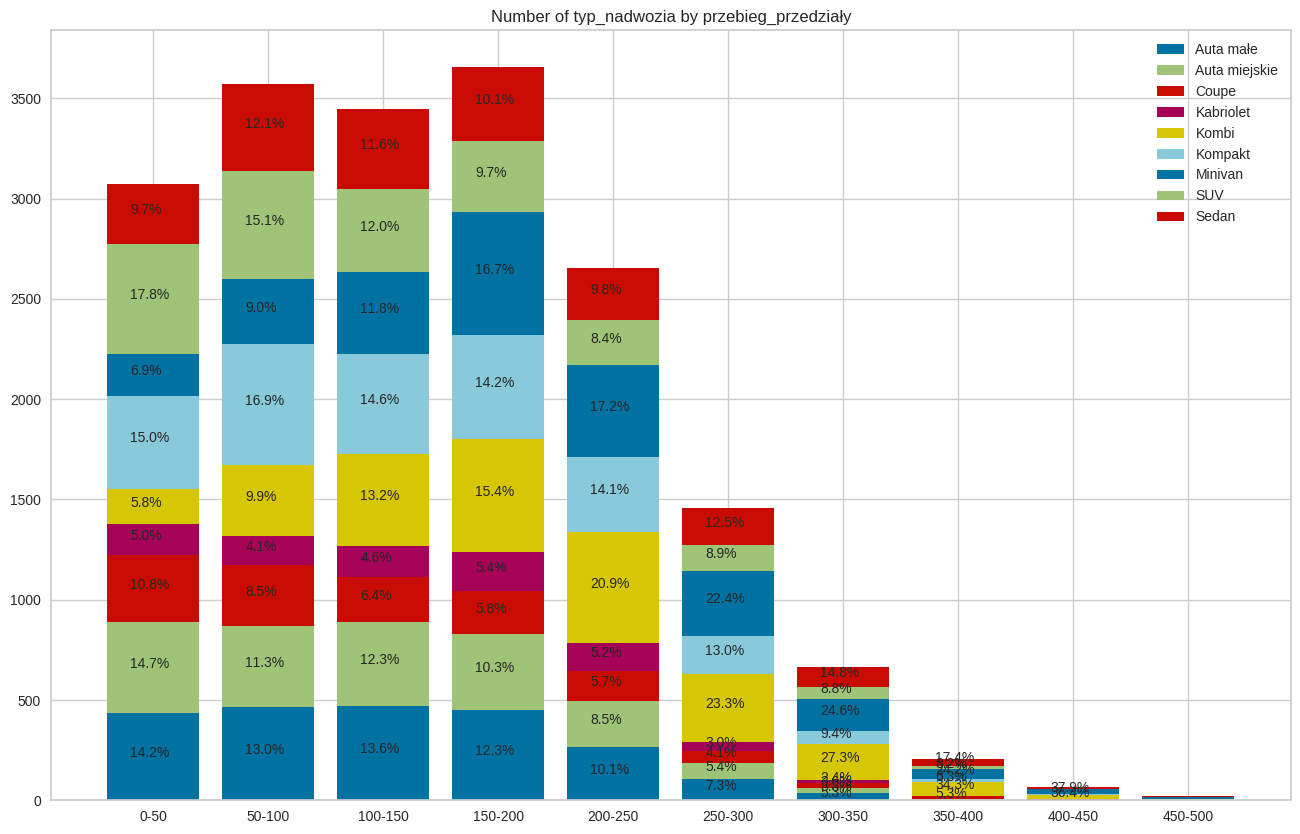

Auta małe  Auta miejskie  Coupe  Kabriolet  Kombi  \
przebieg_przedziały                                                      
0-50                       435            453    333        154    179   
50-100                     465            404    303        146    353   
100-150                    469            422    220        158    455   
150-200                    451            378    212        197    563   
200-250                    267            226    152        138    555   
250-300                    107             79     60         44    339   
300-350                     35             25     24         16    181   
350-400                      3              5     11          1     71   
400-450                      0              1      3          0     24   
450-500                      0              0      0          0      6   

                     Kompakt  Minivan  SUV  Sedan   sum  Auta małe_%  \
przebieg_przedziały                                                    
0-50                     461      212  547    299  3073         14.2   
50-100                   604      322  539    433  3569         13.0   
100-150                  502      408  412    398  3444         13.6   
150-200                  520      610  354    371  3656         12.3   
200-250                  375      457  223    260  2653         10.1   
250-300                  190      326  129    182  1456          7.3   
300-350                   62      163   58     98   662          5.3   
350-400                   13       50   17     36   207          1.4   
400-450                    2       25    3      8    66          0.0   
450-500                    1        8    1      6    22          0.0   

                     Auta miejskie_%  Coupe_%  Kabriolet_%  Kombi_%  \
przebieg_przedziały                                                   
0-50                            14.7     10.8          5.0      5.8   
50-100                          11.3      8.5          4.1      9.9   
100-150                         12.3      6.4          4.6     13.2   
150-200                         10.3      5.8          5.4     15.4   
200-250                          8.5      5.7          5.2     20.9   
250-300                          5.4      4.1          3.0     23.3   
300-350                          3.8      3.6          2.4     27.3   
350-400                          2.4      5.3          0.5     34.3   
400-450                          1.5      4.5          0.0     36.4   
450-500                          0.0      0.0          0.0     27.3   

                     Kompakt_%  Minivan_%  SUV_%  Sedan_%  
przebieg_przedziały                                        
0-50                      15.0        6.9   17.8      9.7  
50-100                    16.9        9.0   15.1     12.1  
100-150                   14.6       11.8   12.0     11.6  
150-200                   14.2       16.7    9.7     10.1  
200-250                   14.1       17.2    8.4      9.8  
250-300                   13.0       22.4    8.9     12.5  
300-350                    9.4       24.6    8.8     14.8  
350-400                    6.3       24.2    8.2     17.4  
400-450                    3.0       37.9    4.5     12.1  
450-500                    4.5       36.4    4.5     27.3

In [ ]:
extended_pivot_table_with_chart(df=eda_df, index_='przebieg_przedziały', column_='typ_nadwozia',  return_pivot_table=True)

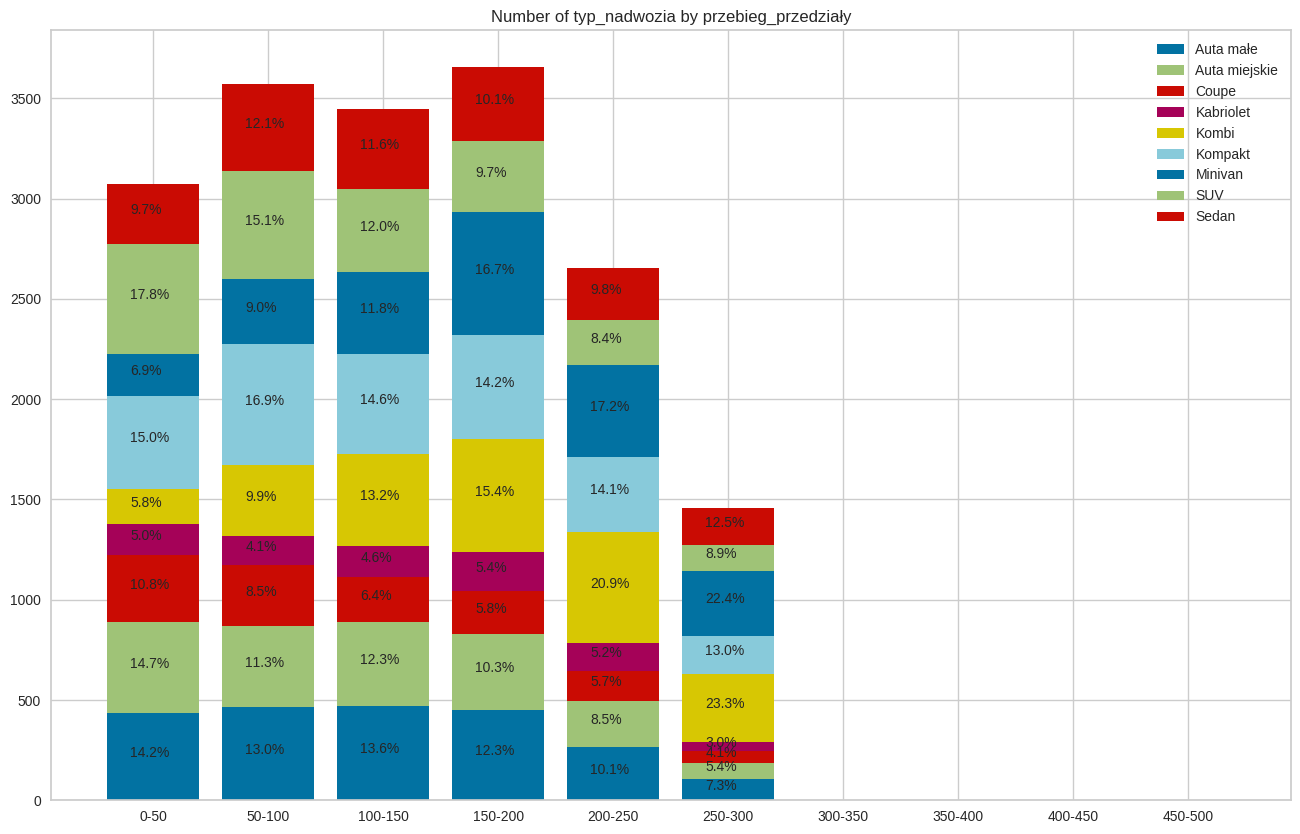

Auta małe  Auta miejskie  Coupe  Kabriolet  Kombi  \
przebieg_przedziały                                                      
0-50                       435            453    333        154    179   
50-100                     465            404    303        146    353   
100-150                    469            422    220        158    455   
150-200                    451            378    212        197    563   
200-250                    267            226    152        138    555   
250-300                    107             79     60         44    339   
300-350                      0              0      0          0      0   
350-400                      0              0      0          0      0   
400-450                      0              0      0          0      0   
450-500                      0              0      0          0      0   

                     Kompakt  Minivan  SUV  Sedan   sum  Auta małe_%  \
przebieg_przedziały                                                    
0-50                     461      212  547    299  3073         14.2   
50-100                   604      322  539    433  3569         13.0   
100-150                  502      408  412    398  3444         13.6   
150-200                  520      610  354    371  3656         12.3   
200-250                  375      457  223    260  2653         10.1   
250-300                  190      326  129    182  1456          7.3   
300-350                    0        0    0      0     0          NaN   
350-400                    0        0    0      0     0          NaN   
400-450                    0        0    0      0     0          NaN   
450-500                    0        0    0      0     0          NaN   

                     Auta miejskie_%  Coupe_%  Kabriolet_%  Kombi_%  \
przebieg_przedziały                                                   
0-50                            14.7     10.8          5.0      5.8   
50-100                          11.3      8.5          4.1      9.9   
100-150                         12.3      6.4          4.6     13.2   
150-200                         10.3      5.8          5.4     15.4   
200-250                          8.5      5.7          5.2     20.9   
250-300                          5.4      4.1          3.0     23.3   
300-350                          NaN      NaN          NaN      NaN   
350-400                          NaN      NaN          NaN      NaN   
400-450                          NaN      NaN          NaN      NaN   
450-500                          NaN      NaN          NaN      NaN   

                     Kompakt_%  Minivan_%  SUV_%  Sedan_%  
przebieg_przedziały                                        
0-50                      15.0        6.9   17.8      9.7  
50-100                    16.9        9.0   15.1     12.1  
100-150                   14.6       11.8   12.0     11.6  
150-200                   14.2       16.7    9.7     10.1  
200-250                   14.1       17.2    8.4      9.8  
250-300                   13.0       22.4    8.9     12.5  
300-350                    NaN        NaN    NaN      NaN  
350-400                    NaN        NaN    NaN      NaN  
400-450                    NaN        NaN    NaN      NaN  
450-500                    NaN        NaN    NaN      NaN

In [ ]:
extended_pivot_table_with_chart(df=eda_df[eda_df['przebieg'] <= 300000], index_='przebieg_przedziały', column_='typ_nadwozia',  return_pivot_table=True)

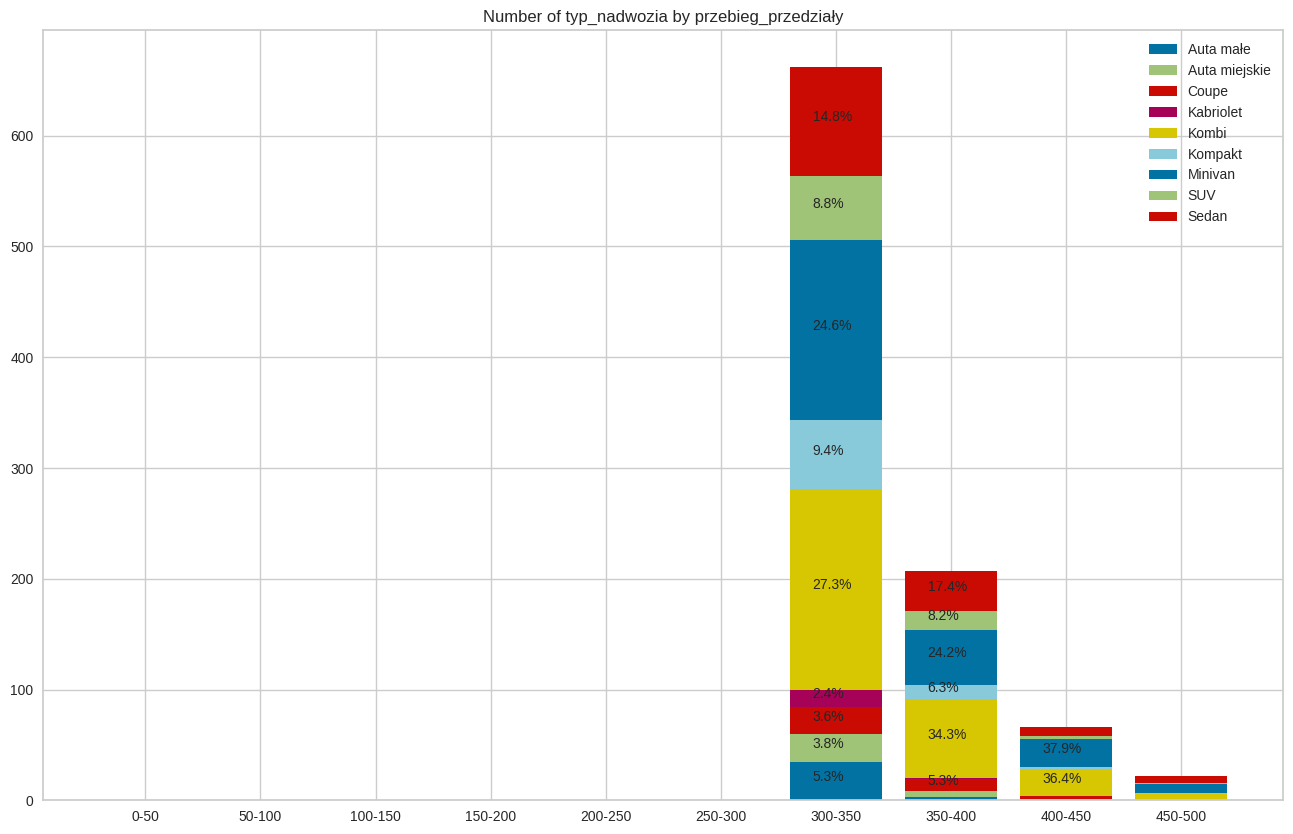

Auta małe  Auta miejskie  Coupe  Kabriolet  Kombi  \
przebieg_przedziały                                                      
0-50                         0              0      0          0      0   
50-100                       0              0      0          0      0   
100-150                      0              0      0          0      0   
150-200                      0              0      0          0      0   
200-250                      0              0      0          0      0   
250-300                      0              0      0          0      0   
300-350                     35             25     24         16    181   
350-400                      3              5     11          1     71   
400-450                      0              1      3          0     24   
450-500                      0              0      0          0      6   

                     Kompakt  Minivan  SUV  Sedan  sum  Auta małe_%  \
przebieg_przedziały                                                   
0-50                       0        0    0      0    0          NaN   
50-100                     0        0    0      0    0          NaN   
100-150                    0        0    0      0    0          NaN   
150-200                    0        0    0      0    0          NaN   
200-250                    0        0    0      0    0          NaN   
250-300                    0        0    0      0    0          NaN   
300-350                   62      163   58     98  662          5.3   
350-400                   13       50   17     36  207          1.4   
400-450                    2       25    3      8   66          0.0   
450-500                    1        8    1      6   22          0.0   

                     Auta miejskie_%  Coupe_%  Kabriolet_%  Kombi_%  \
przebieg_przedziały                                                   
0-50                             NaN      NaN          NaN      NaN   
50-100                           NaN      NaN          NaN      NaN   
100-150                          NaN      NaN          NaN      NaN   
150-200                          NaN      NaN          NaN      NaN   
200-250                          NaN      NaN          NaN      NaN   
250-300                          NaN      NaN          NaN      NaN   
300-350                          3.8      3.6          2.4     27.3   
350-400                          2.4      5.3          0.5     34.3   
400-450                          1.5      4.5          0.0     36.4   
450-500                          0.0      0.0          0.0     27.3   

                     Kompakt_%  Minivan_%  SUV_%  Sedan_%  
przebieg_przedziały                                        
0-50                       NaN        NaN    NaN      NaN  
50-100                     NaN        NaN    NaN      NaN  
100-150                    NaN        NaN    NaN      NaN  
150-200                    NaN        NaN    NaN      NaN  
200-250                    NaN        NaN    NaN      NaN  
250-300                    NaN        NaN    NaN      NaN  
300-350                    9.4       24.6    8.8     14.8  
350-400                    6.3       24.2    8.2     17.4  
400-450                    3.0       37.9    4.5     12.1  
450-500                    4.5       36.4    4.5     27.3

In [ ]:
extended_pivot_table_with_chart(df=eda_df[eda_df['przebieg'] > 300000], index_='przebieg_przedziały', column_='typ_nadwozia',  return_pivot_table=True)

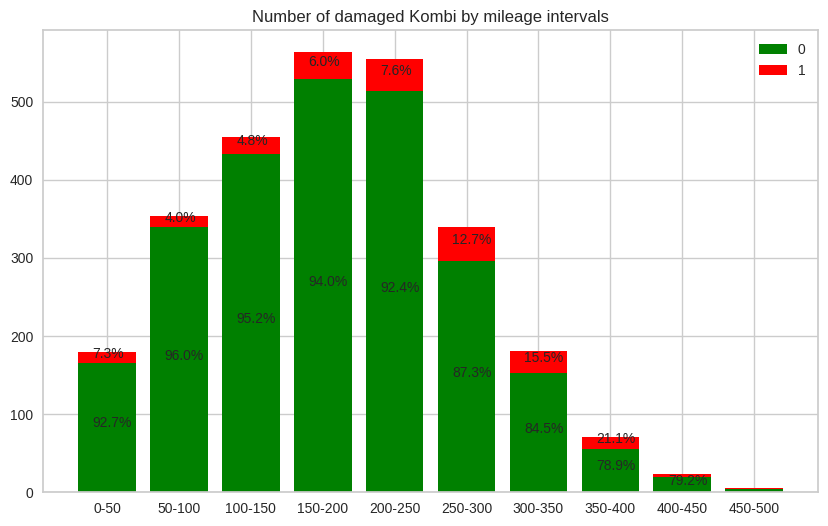

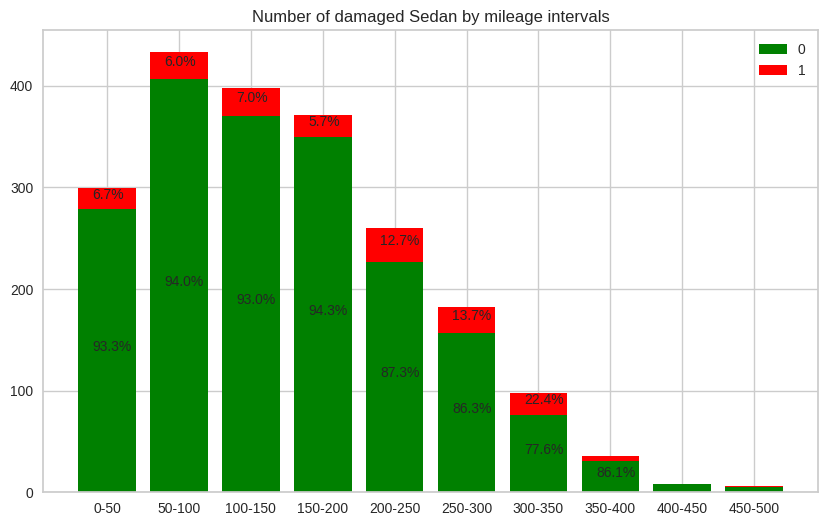

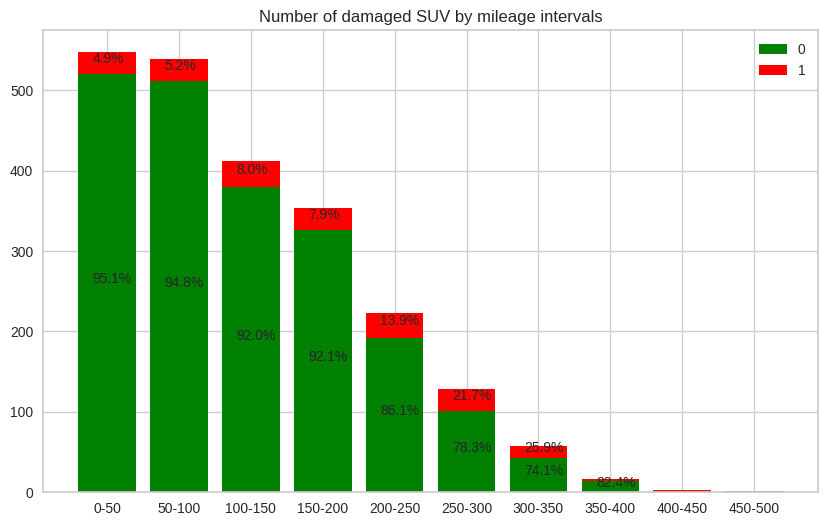

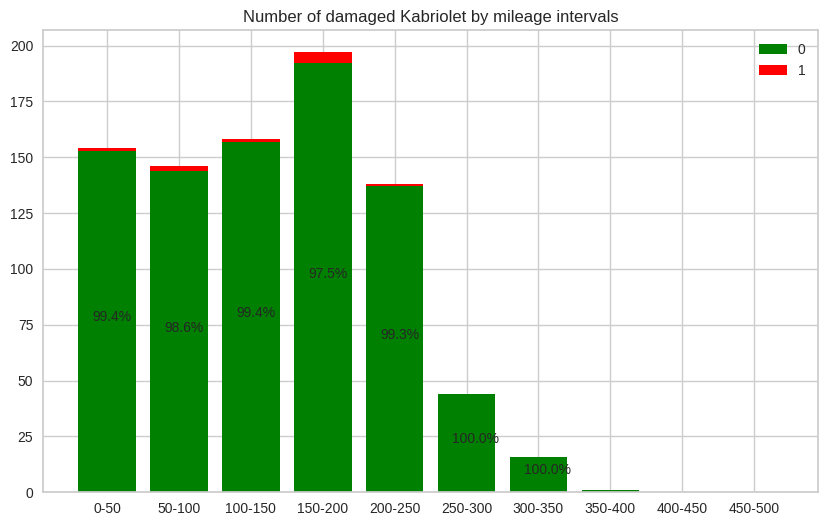

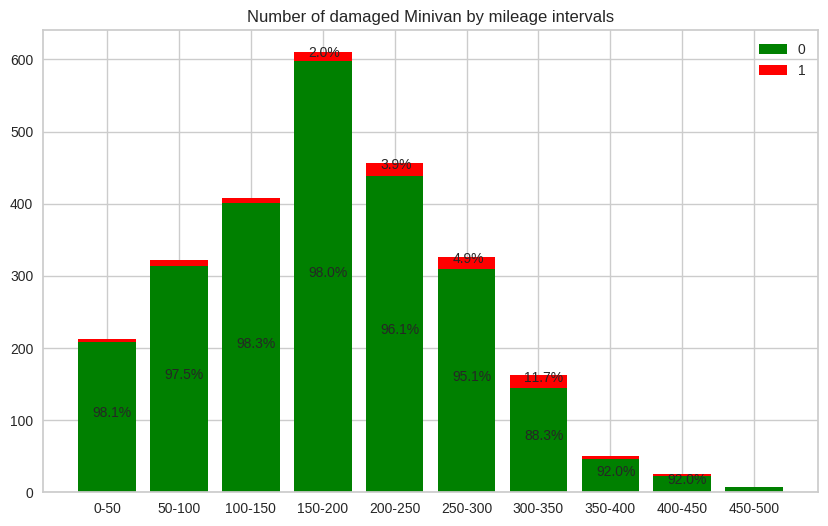

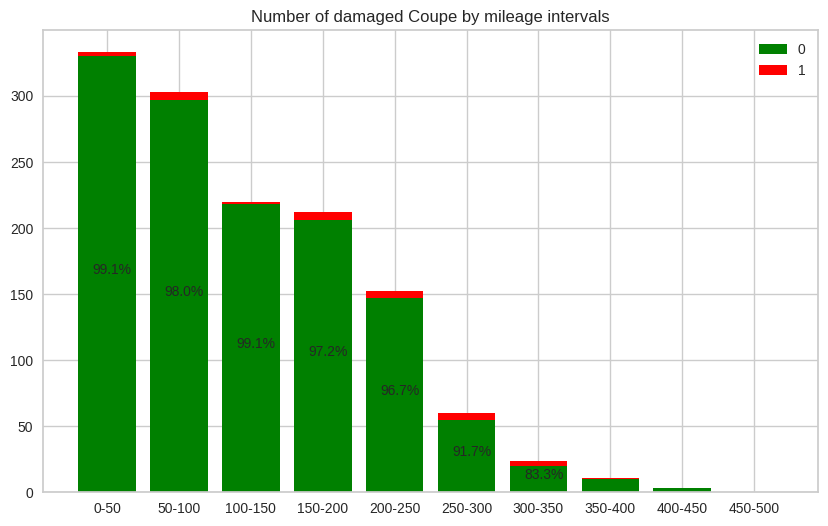

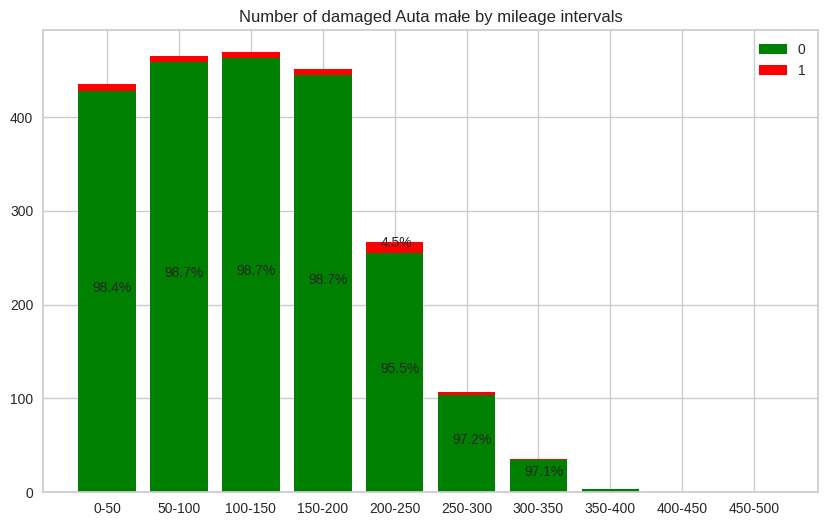

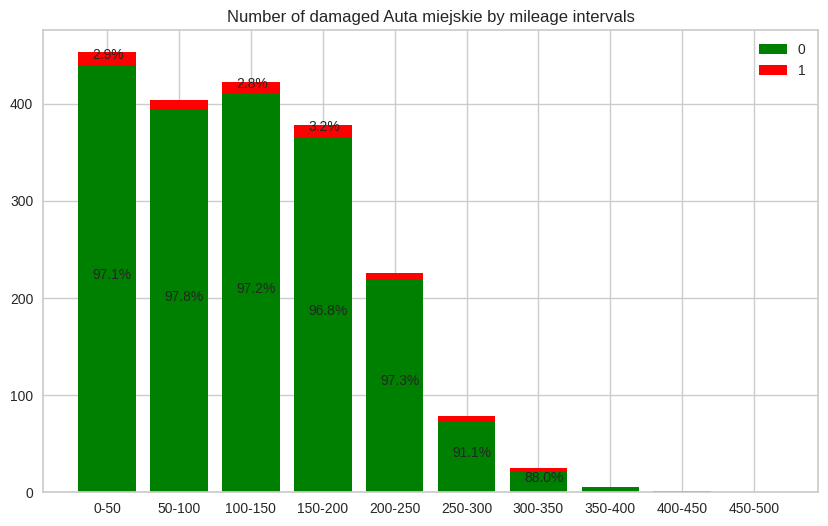

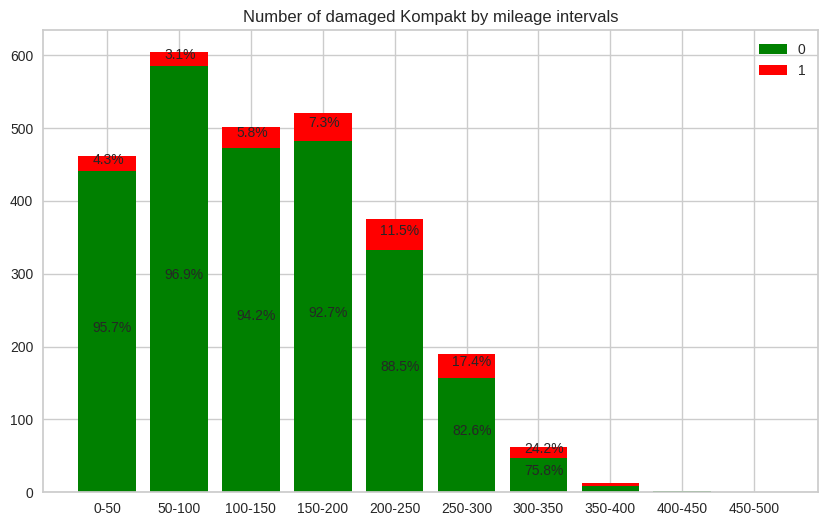

In [ ]:
for body_type in eda_df['typ_nadwozia'].unique():
    extended_pivot_table_with_chart(df=eda_df[eda_df['typ_nadwozia'] == body_type],
                                    index_='przebieg_przedziały',
                                    column_='uszkodzony',
                                    title=f'Number of damaged {body_type} by mileage intervals' ,
                                    figsize=(10, 6))
    print(100 * '=')

In [ ]:
for body_type in eda_df['typ_nadwozia'].unique():
    fig = px.histogram(eda_df[eda_df['typ_nadwozia'] == body_type].sort_values(['uszkodzony', 'rodzaj_paliwa']),
                       x="przebieg_przedziały",
                       color="rodzaj_paliwa",
                       #facet_col ='rodzaj_paliwa',
                       labels={'przebieg_przedziały': 'mileage intervals'},
                       pattern_shape="uszkodzony",
                       category_orders ={'przebieg_przedziały': sorted(eda_df['przebieg_przedziały'].unique(), key=lambda x: int(x.split('-')[0]))} ,
                       #color_discrete_sequence = ['blue','pink', 'yellow', 'purple', 'green', 'red'],
                       #pattern_shape_sequence=[None, "x"],
                       #text_auto=True,
                       width=1200,
                       height=500,
                       barmode='relative',
                       title=body_type)
    fig.show()
    print(100 * '=')

In [ ]:
body_type_mileage_df = pd.pivot_table(data=eda_df, index=['typ_nadwozia', 'rodzaj_paliwa', 'uszkodzony'], columns=['przebieg_przedziały'],
                                        aggfunc={'uszkodzony': 'count'})

body_type_mileage_df

uszkodzony                         \
przebieg_przedziały                         0-50 50-100 100-150 150-200   
typ_nadwozia rodzaj_paliwa uszkodzony                                     
Auta małe    Benzyna       0                 332    368     383     324   
                           1                   4      6       3       2   
             Benzyna+CNG   0                   0      0       0       0   
                           1                   0      0       0       0   
             Benzyna+LPG   0                   2     27      28      43   
...                                          ...    ...     ...     ...   
Sedan        Diesel        1                   1      7      12       8   
             Elektryczny   0                  15      3       2       2   
                           1                   1      1       0       0   
             Hybryda       0                  25     33       9       5   
                           1                   2      0       2       0   

                                                                               \
przebieg_przedziały                   200-250 250-300 300-350 350-400 400-450   
typ_nadwozia rodzaj_paliwa uszkodzony                                           
Auta małe    Benzyna       0              140      41       9       0       0   
                           1                4       1       1       0       0   
             Benzyna+CNG   0                0       0       0       0       0   
                           1                0       0       0       0       0   
             Benzyna+LPG   0               31      18       6       1       0   
...                                       ...     ...     ...     ...     ...   
Sedan        Diesel        1               18      16      14       4       0   
             Elektryczny   0                0       0       0       0       0   
                           1                0       0       0       0       0   
             Hybryda       0                4       2       2       0       0   
                           1                0       0       0       0       0   

                                               
przebieg_przedziały                   450-500  
typ_nadwozia rodzaj_paliwa uszkodzony          
Auta małe    Benzyna       0                0  
                           1                0  
             Benzyna+CNG   0                0  
                           1                0  
             Benzyna+LPG   0                0  
...                                       ...  
Sedan        Diesel        1                1  
             Elektryczny   0                0  
                           1                0  
             Hybryda       0                0  
                           1                0  

[108 rows x 10 columns]

In [ ]:
fig = px.box(eda_df, x="typ_nadwozia", y="przebieg", color="uszkodzony")#, notched=True)
fig.show()

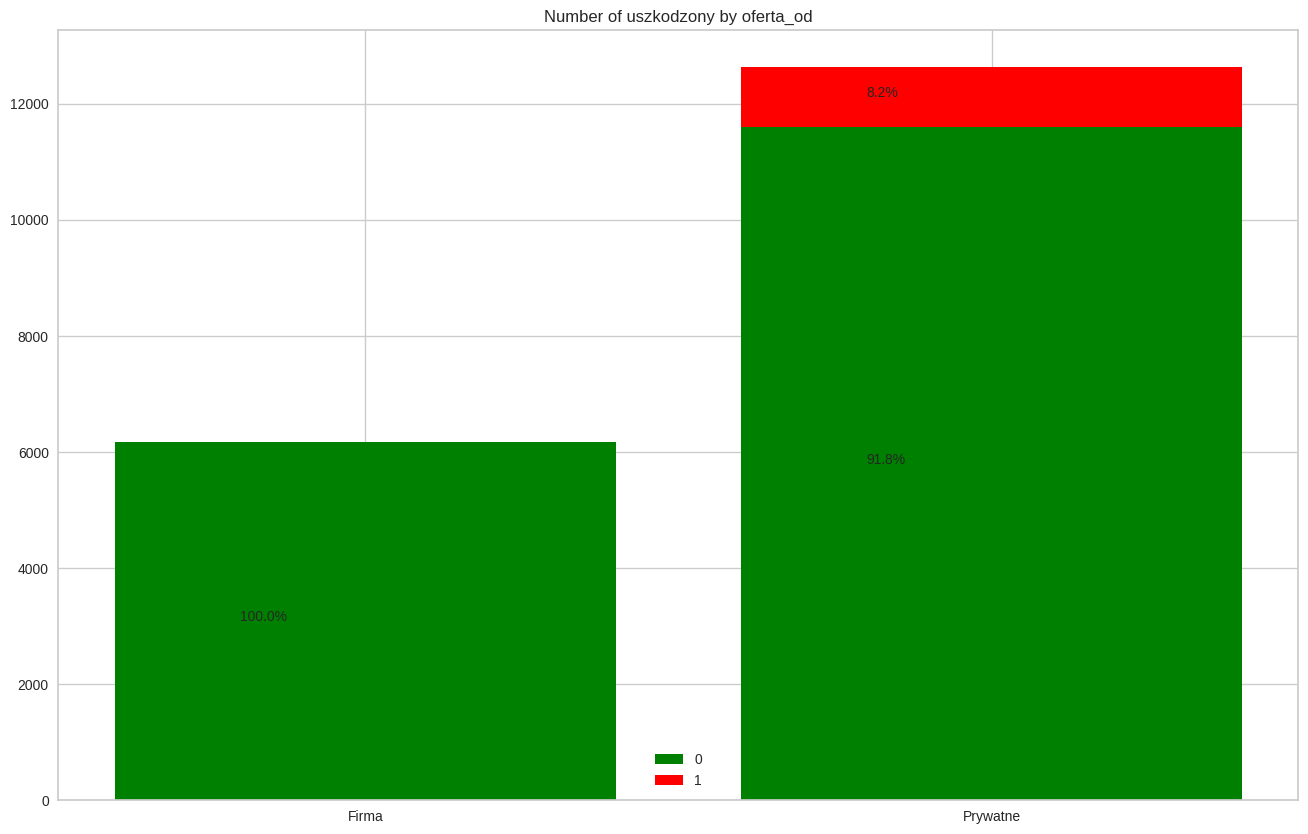

0       1      sum    0_%  1_%
oferta_od                                      
Firma       6173.0     0.0   6173.0  100.0  0.0
Prywatne   11604.0  1031.0  12635.0   91.8  8.2

In [ ]:
extended_pivot_table_with_chart(df=eda_df, index_='oferta_od', column_='uszkodzony', return_pivot_table=True)

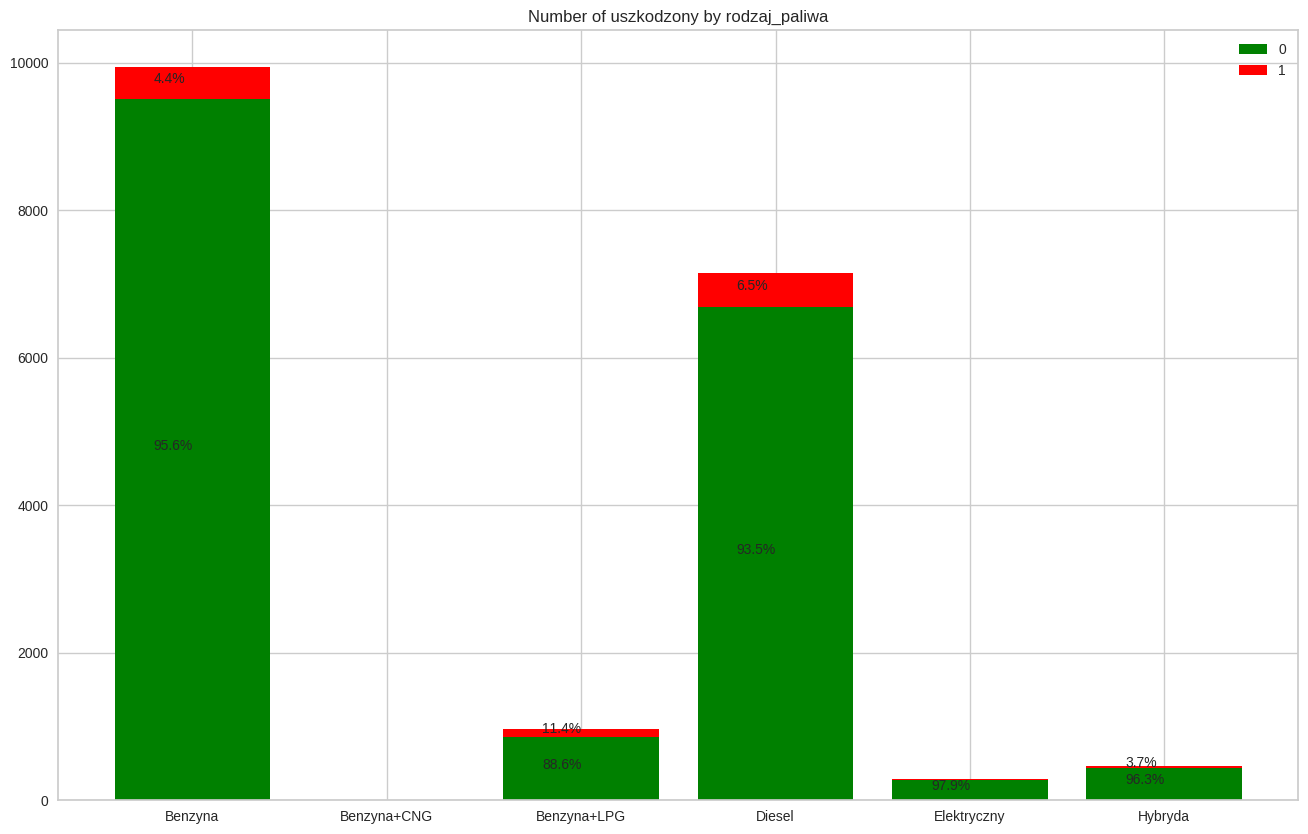

0      1     sum    0_%   1_%
rodzaj_paliwa                                    
Benzyna        9505.0  436.0  9941.0   95.6   4.4
Benzyna+CNG       6.0    0.0     6.0  100.0   0.0
Benzyna+LPG     862.0  111.0   973.0   88.6  11.4
Diesel         6684.0  461.0  7145.0   93.5   6.5
Elektryczny     278.0    6.0   284.0   97.9   2.1
Hybryda         442.0   17.0   459.0   96.3   3.7

In [ ]:
extended_pivot_table_with_chart(df=eda_df, index_='rodzaj_paliwa', column_='uszkodzony', return_pivot_table=True)

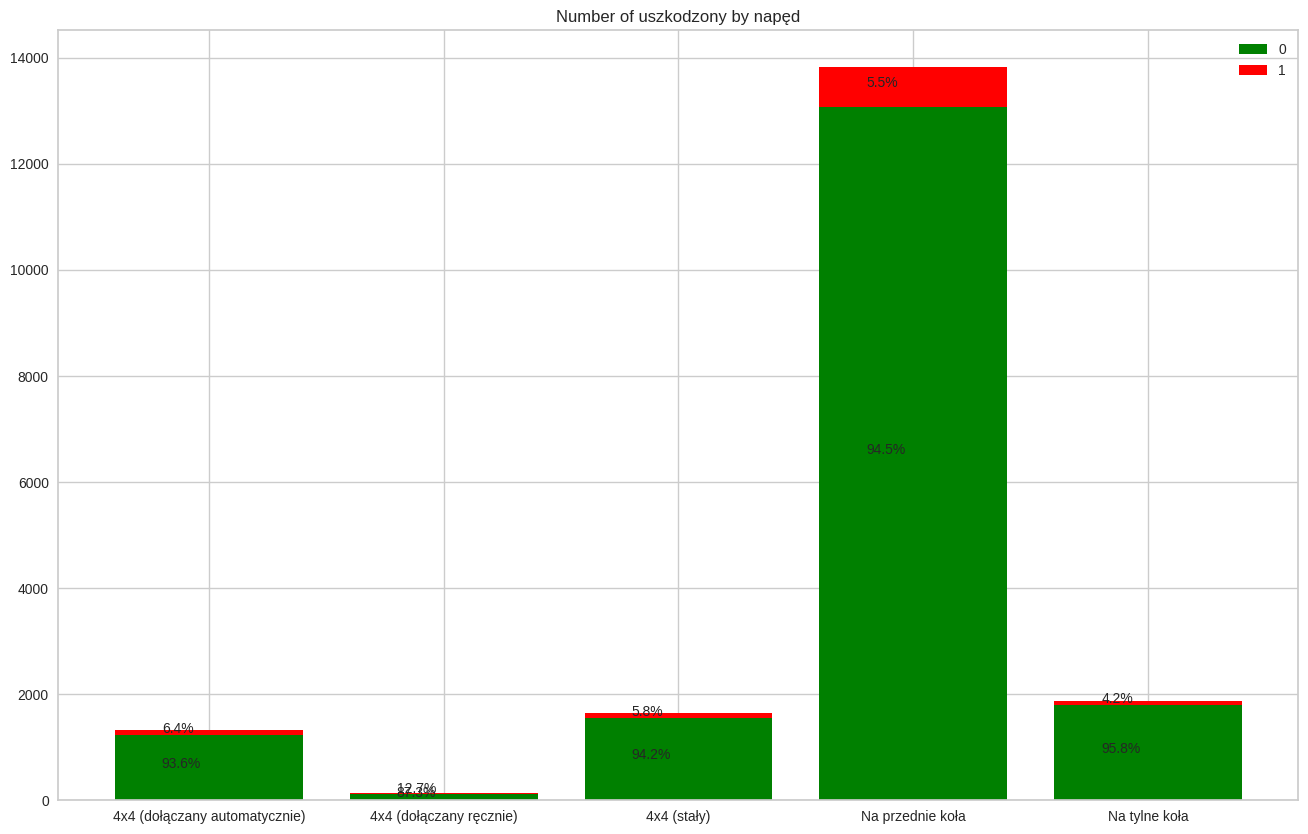

0    1    sum   0_%   1_%
napęd                                                       
4x4 (dołączany automatycznie)   1233   84   1317  93.6   6.4
4x4 (dołączany ręcznie)          124   18    142  87.3  12.7
4x4 (stały)                     1547   96   1643  94.2   5.8
Na przednie koła               13072  754  13826  94.5   5.5
Na tylne koła                   1801   79   1880  95.8   4.2

In [ ]:
extended_pivot_table_with_chart(df=eda_df, index_='napęd', column_='uszkodzony', return_pivot_table=True)

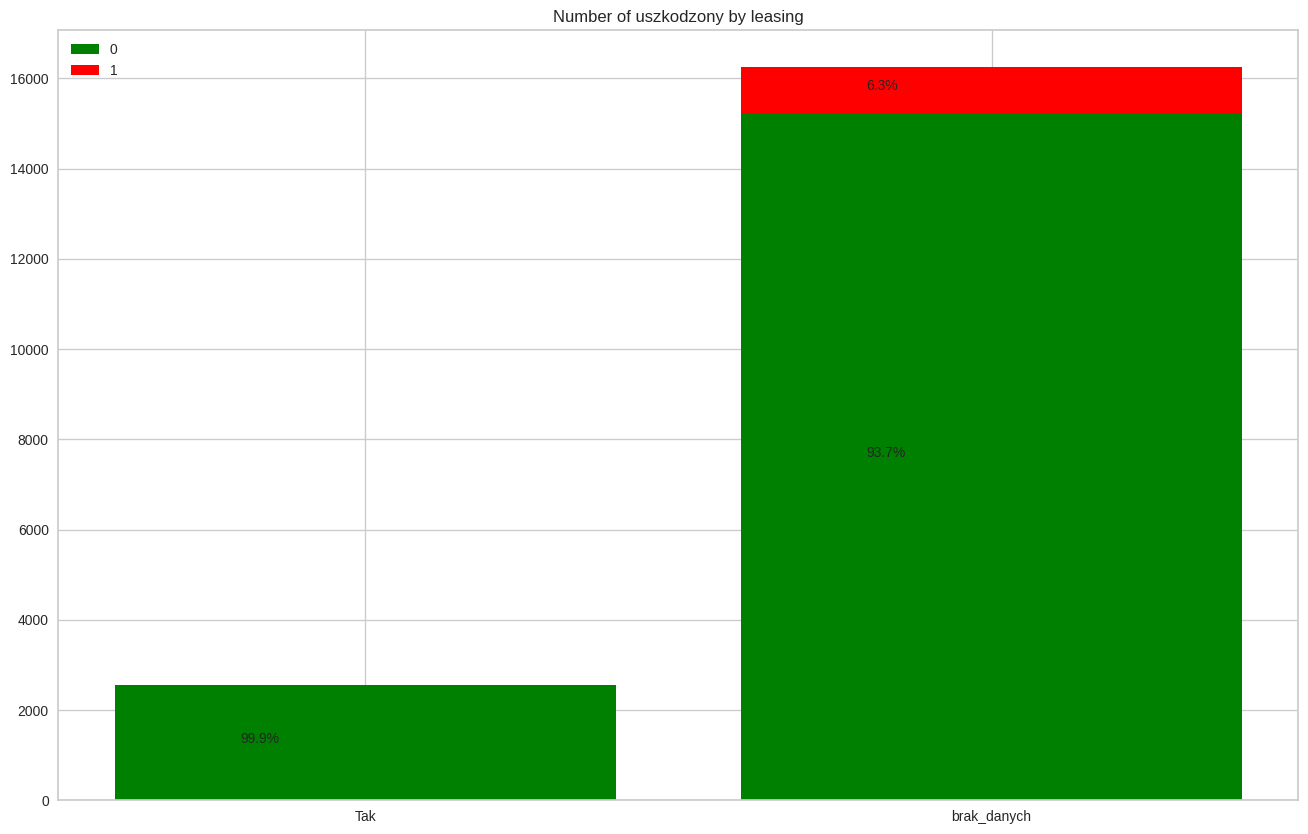

0     1    sum   0_%  1_%
leasing                                   
Tak           2550     3   2553  99.9  0.1
brak_danych  15227  1028  16255  93.7  6.3

In [ ]:
extended_pivot_table_with_chart(df=eda_df, index_='leasing', column_='uszkodzony', return_pivot_table=True)

In [ ]:
eda_df.to_csv('eda_df.csv', index=False)

#### Conclusions


Observations of damaged cars performed on training data showed that:

-as the mileage increases, the number of damaged cars increases

(among cars with mileage below 100 000 km, approximately 3.5% are damaged cars,

among cars with mileage above 250 000 km, above 11% are damaged cars),

-the higher the price, the less damaged cars

(among cars priced below PLN 25,000, over 11% are damaged cars,

among cars priced above PLN 125,000, less than 1.5% are damaged cars),



-100% of the cars from Dealer are undamaged,

-among cars powered by petrol+LPG 11,4% are damaged,
among electric cars 0,4% are damaged,



-12.7% of cars with manually engaged 4-wheel drive are damaged,

-99,9% leasing cars are undamaged,

-among car brands (which there are over 50 advertisements), the most are damaged:

Land Rover 21.4%

Subaru 14.3%

Jaguar 13.1%

Dacia 11.2%

Mazda 8.4%

and least damaged cars:

Smart 0%

MINI 0.4%

Dodge 2%

Mercedes_Benz 3.8%

Volkswagen 3.8%

-up to 150,000 km, petrol engine cars predominate, a
above with diesel engine. The distribution of damaged cars is similar

-The most damaged body types include:

sedans 8.7%,

SUVs 8.5%,

station wagon 8%,

compacts7.4%


while the least damaged are:

Convertibles 1.2%

Small cars 1.8%

Coupe 2.4%

City cars 3.2%

Minivans 3.5%

Small cars and convertibles are the most well-kept

=========================================================================


Observations carried out on the training set show that (from previous EDA; otomoto_cars_EDA_&_regression_model):

-most cars were produced in 2017-2019,

-most cars have a mileage of less than 200000 km,

-as the engine capacity increases, the power increases,

-the most powerful cars have gasoline or electric engines

-cars with high power have lower mileage,

-the newer the car, the higher the price,

-highly powerful cars have automatic transmissions,

-we notice a decrease in engines capacity and an increase in power.

# <a name='5'></a> Classification

## StandardScaler & OneHotEncoder

In [ ]:
categorical_features = list(X_train.select_dtypes(include="object").columns)
categorical_features

['marka_pojazdu',
 'model_pojazdu',
 'rodzaj_paliwa',
 'skrzynia_biegów',
 'napęd',
 'typ_nadwozia',
 'kolor',
 'leasing',
 'oferta_od']

In [ ]:
numeric_features = list(X_train.select_dtypes(include=["int", "float"]).columns)
numeric_features

['rok_produkcji',
 'pojemność_skokowa',
 'moc',
 'przebieg',
 'cena',
 'liczba_drzwi',
 'liczba_miejsc']

In [ ]:
sc = StandardScaler()
#pf = PolynomialFeatures(include_bias=False)
ohe = OneHotEncoder(drop='first',
                    handle_unknown='infrequent_if_exist') #handle_unknown{‘error’, ‘ignore’, ‘infrequent_if_exist’}, default=’error’

In [ ]:
cf = ColumnTransformer(
    transformers=[
        ('sc', sc, numeric_features),
        #('pf', pf, numeric_features),
        ('ohe', ohe, categorical_features)
    ]
)

In [ ]:
X_train_processed = cf.fit_transform(X_train)

In [ ]:
X_train_processed_df = pd.DataFrame(X_train_processed.toarray(),
                                    columns=cf.get_feature_names_out())

X_train_processed_df

NameError: ignored

In [ ]:
L1 = [1, 2, 3, 4]
L2 = [2, 4, 6, 8]
import numpy as np
result = 0
for x1, y1 in zip(L1, L2):
    for x2, y2 in zip(L1, L2):
        print(x1, y1, x2, y2)
        result += np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
result

1 2 1 2
1 2 2 4
1 2 3 6
1 2 4 8
2 4 1 2
2 4 2 4
2 4 3 6
2 4 4 8
3 6 1 2
3 6 2 4
3 6 3 6
3 6 4 8
4 8 1 2
4 8 2 4
4 8 3 6
4 8 4 8


44.721359549995796

In [ ]:
kstest(X_train_processed_df['sc__cena'], stats.norm.cdf)

NameError: ignored

## X_test preprocessing

In [ ]:
X_test[X_test['pojemność_skokowa'].isna()]['rodzaj_paliwa'].value_counts()

Elektryczny    69
Name: rodzaj_paliwa, dtype: int64

##### Extraction of cars with missing "pojemność_skokowa" (electric and no electric) and imputing values.

In [ ]:
# Electric cars with missing 'pojemność_skokowa'  (all electric)
electric_X_test = X_test[(X_test['rodzaj_paliwa'] == 'Elektryczny') & (X_test['pojemność_skokowa'].isna())]
electric_X_test

marka_pojazdu model_pojazdu rok_produkcji pojemność_skokowa     moc  \
8841            Kia           EV6          2022               NaN  585 KM   
14382          MINI      Cooper S        2022.0               NaN  184 KM   
22183        Jaguar        I-Pace        2019.0               NaN  400 KM   
10473         Honda             e          2020               NaN  154 KM   
9965     Volkswagen           up!          2017               NaN   82 KM   
...             ...           ...           ...               ...     ...   
13185        Nissan          Leaf        2019.0               NaN  150 KM   
1411     Volkswagen          Golf        2019.0               NaN  136 KM   
13374        Nissan          Leaf        2019.0               NaN  150 KM   
11157    Volkswagen           up!          2017               NaN   82 KM   
14063          Fiat           500        2017.0               NaN  118 KM   

        przebieg rodzaj_paliwa skrzynia_biegów             napęd      cena  \
8841    4 115 km   Elektryczny    Automatyczna       4x4 (stały)  319900.0   
14382   8 200 km   Elektryczny    Automatyczna  Na przednie koła  139900.0   
22183  26 340 km   Elektryczny    Automatyczna       4x4 (stały)  219000.0   
10473  20 500 km   Elektryczny    Automatyczna     Na tylne koła  111111.0   
9965   44 500 km   Elektryczny    Automatyczna  Na przednie koła   65500.0   
...          ...           ...             ...               ...       ...   
13185  27 300 km   Elektryczny    Automatyczna  Na przednie koła  106900.0   
1411   46 000 km   Elektryczny    Automatyczna  Na przednie koła   93900.0   
13374  36 250 km   Elektryczny    Automatyczna  Na przednie koła   95900.0   
11157  47 200 km   Elektryczny    Automatyczna  Na przednie koła   69900.0   
14063  57 400 km   Elektryczny    Automatyczna  Na przednie koła   54900.0   

        typ_nadwozia  liczba_drzwi  liczba_miejsc      kolor leasing oferta_od  
8841         Kompakt           5.0            5.0     Czarny     Tak     Firma  
14382  Auta miejskie           3.0            5.0  Niebieski     NaN     Firma  
22183            SUV           5.0            5.0     Czarny     NaN     Firma  
10473      Auta małe           5.0            4.0      Szary     NaN  Prywatne  
9965       Auta małe           5.0            4.0  Niebieski     NaN  Prywatne  
...              ...           ...            ...        ...     ...       ...  
13185  Auta miejskie           5.0            5.0      Szary     NaN     Firma  
1411           Coupe           5.0            5.0    Srebrny     NaN  Prywatne  
13374  Auta miejskie           5.0            5.0     Czarny     NaN     Firma  
11157      Auta małe           5.0            4.0     Czarny     NaN     Firma  
14063  Auta miejskie           3.0            4.0      Szary     NaN  Prywatne  

[69 rows x 16 columns]

In [ ]:
electric_X_test['pojemność_skokowa'] = imputer_pojemnosc_skokowa_electric.transform(electric_X_test[['pojemność_skokowa']])

<ipython-input-157-845b164fa17f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electric_X_test['pojemność_skokowa'] = imputer_pojemnosc_skokowa_electric.transform(electric_X_test[['pojemność_skokowa']])


In [ ]:
electric_X_test['pojemność_skokowa']

8841     0.0
14382    0.0
22183    0.0
10473    0.0
9965     0.0
        ... 
13185    0.0
1411     0.0
13374    0.0
11157    0.0
14063    0.0
Name: pojemność_skokowa, Length: 69, dtype: object

In [ ]:
# No electric cars with missing 'pojemność_skokowa'
no_electric_X_test = X_test[(X_test['rodzaj_paliwa'] != 'Elektryczny') & (X_test['pojemność_skokowa'].isna())]
no_electric_X_test

Empty DataFrame
Columns: [marka_pojazdu, model_pojazdu, rok_produkcji, pojemność_skokowa, moc, przebieg, rodzaj_paliwa, skrzynia_biegów, napęd, cena, typ_nadwozia, liczba_drzwi, liczba_miejsc, kolor, leasing, oferta_od]
Index: []

In [ ]:
no_electric_X_test['pojemność_skokowa'] = imputer_pojemnosc_skokowa_mean.transform(no_electric_X_test[['pojemność_skokowa']])

ValueError: ignored

In [ ]:
no_electric_X_test['pojemność_skokowa']

Series([], Name: pojemność_skokowa, dtype: object)

In [ ]:
others_X_test = X_test[~X_test['pojemność_skokowa'].isna()]
others_X_test

marka_pojazdu model_pojazdu rok_produkcji pojemność_skokowa     moc  \
7773        Peugeot           207          2007         1 360 cm3   73 KM   
13139          Ford        Fiesta        2014.0         1 388 cm3   96 KM   
22276    Volkswagen       Touareg        2012.0         2 967 cm3  245 KM   
7699        Peugeot           308          2016         1 199 cm3  130 KM   
4324           Ford         Focus          2019         1 498 cm3  120 KM   
...             ...           ...           ...               ...     ...   
4732     Volkswagen          Golf          2017         1 598 cm3  115 KM   
18317          Audi            A6          2018         2 995 cm3  340 KM   
20899         Volvo         XC 60        2008.0         2 400 cm3  185 KM   
22506          Seat         Ateca        2018.0         1 395 cm3  150 KM   
6086     Volkswagen         T-Roc          2020           999 cm3  115 KM   

         przebieg rodzaj_paliwa skrzynia_biegów  \
7773   194 304 km   Benzyna+LPG        Manualna   
13139  126 000 km       Benzyna        Manualna   
22276  234 171 km        Diesel    Automatyczna   
7699    93 219 km       Benzyna        Manualna   
4324   150 000 km        Diesel        Manualna   
...           ...           ...             ...   
4732   154 973 km        Diesel        Manualna   
18317   80 000 km       Benzyna    Automatyczna   
20899  294 000 km        Diesel    Automatyczna   
22506   55 000 km       Benzyna        Manualna   
6086    15 000 km       Benzyna        Manualna   

                               napęd      cena   typ_nadwozia  liczba_drzwi  \
7773                Na przednie koła   11000.0        Kompakt           3.0   
13139               Na przednie koła   33900.0  Auta miejskie           5.0   
22276                    4x4 (stały)   72900.0            SUV           5.0   
7699                Na przednie koła   51000.0        Kompakt           5.0   
4324                Na przednie koła   43900.0          Kombi           5.0   
...                              ...       ...            ...           ...   
4732                Na przednie koła   54000.0          Kombi           5.0   
18317  4x4 (dołączany automatycznie)  108500.0          Sedan           4.0   
20899                    4x4 (stały)   39900.0            SUV           5.0   
22506               Na przednie koła   87900.0            SUV           5.0   
6086                Na przednie koła   84870.0        Kompakt           5.0   

       liczba_miejsc         kolor leasing oferta_od  
7773             5.0      Czerwony     Tak     Firma  
13139            5.0        Czarny     NaN     Firma  
22276            5.0         Biały     NaN     Firma  
7699             5.0         Biały     Tak     Firma  
4324             5.0         Biały     NaN  Prywatne  
...              ...           ...     ...       ...  
4732             5.0         Szary     Tak     Firma  
18317            5.0        Czarny     NaN  Prywatne  
20899            5.0       Brązowy     NaN  Prywatne  
22506            5.0  Pomarańczowy     NaN  Prywatne  
6086             5.0         Szary     NaN  Prywatne  

[4617 rows x 16 columns]

##### New data frame with completed values

In [ ]:
X_test_2 = pd.concat([electric_X_test, no_electric_X_test, others_X_test], axis=0, join='outer')#, ignore_index=True)
X_test_2

marka_pojazdu model_pojazdu rok_produkcji pojemność_skokowa     moc  \
8841            Kia           EV6          2022               0.0  585 KM   
14382          MINI      Cooper S        2022.0               0.0  184 KM   
22183        Jaguar        I-Pace        2019.0               0.0  400 KM   
10473         Honda             e          2020               0.0  154 KM   
9965     Volkswagen           up!          2017               0.0   82 KM   
...             ...           ...           ...               ...     ...   
4732     Volkswagen          Golf          2017         1 598 cm3  115 KM   
18317          Audi            A6          2018         2 995 cm3  340 KM   
20899         Volvo         XC 60        2008.0         2 400 cm3  185 KM   
22506          Seat         Ateca        2018.0         1 395 cm3  150 KM   
6086     Volkswagen         T-Roc          2020           999 cm3  115 KM   

         przebieg rodzaj_paliwa skrzynia_biegów  \
8841     4 115 km   Elektryczny    Automatyczna   
14382    8 200 km   Elektryczny    Automatyczna   
22183   26 340 km   Elektryczny    Automatyczna   
10473   20 500 km   Elektryczny    Automatyczna   
9965    44 500 km   Elektryczny    Automatyczna   
...           ...           ...             ...   
4732   154 973 km        Diesel        Manualna   
18317   80 000 km       Benzyna    Automatyczna   
20899  294 000 km        Diesel    Automatyczna   
22506   55 000 km       Benzyna        Manualna   
6086    15 000 km       Benzyna        Manualna   

                               napęd      cena   typ_nadwozia  liczba_drzwi  \
8841                     4x4 (stały)  319900.0        Kompakt           5.0   
14382               Na przednie koła  139900.0  Auta miejskie           3.0   
22183                    4x4 (stały)  219000.0            SUV           5.0   
10473                  Na tylne koła  111111.0      Auta małe           5.0   
9965                Na przednie koła   65500.0      Auta małe           5.0   
...                              ...       ...            ...           ...   
4732                Na przednie koła   54000.0          Kombi           5.0   
18317  4x4 (dołączany automatycznie)  108500.0          Sedan           4.0   
20899                    4x4 (stały)   39900.0            SUV           5.0   
22506               Na przednie koła   87900.0            SUV           5.0   
6086                Na przednie koła   84870.0        Kompakt           5.0   

       liczba_miejsc         kolor leasing oferta_od  
8841             5.0        Czarny     Tak     Firma  
14382            5.0     Niebieski     NaN     Firma  
22183            5.0        Czarny     NaN     Firma  
10473            4.0         Szary     NaN  Prywatne  
9965             4.0     Niebieski     NaN  Prywatne  
...              ...           ...     ...       ...  
4732             5.0         Szary     Tak     Firma  
18317            5.0        Czarny     NaN  Prywatne  
20899            5.0       Brązowy     NaN  Prywatne  
22506            5.0  Pomarańczowy     NaN  Prywatne  
6086             5.0         Szary     NaN  Prywatne  

[4686 rows x 16 columns]

In [ ]:
X_test.index

Int64Index([ 7773, 13139, 22276,  7699,  4324,  7165, 14637,  3769, 21199,
            21339,
            ...
               72, 12447,  9257, 19908, 10836,  4732, 18317, 20899, 22506,
             6086],
           dtype='int64', length=4686)

In [ ]:
X_test_2.index

Int64Index([ 8841, 14382, 22183, 10473,  9965, 12757, 10643, 10134, 14346,
             9584,
            ...
               72, 12447,  9257, 19908, 10836,  4732, 18317, 20899, 22506,
             6086],
           dtype='int64', length=4686)

In [ ]:
X_test.loc[[13090, 9674]]

KeyError: ignored

In [ ]:
X_test_2.loc[[13090, 9674]]

marka_pojazdu model_pojazdu rok_produkcji pojemność_skokowa     moc  \
13090        Nissan          Leaf        2019.0               0.0  150 KM   
9674        Peugeot           iOn          2015               0.0   67 KM   

        przebieg rodzaj_paliwa skrzynia_biegów             napęd     cena  \
13090  29 140 km   Elektryczny    Automatyczna  Na przednie koła  94900.0   
9674   79 000 km   Elektryczny    Automatyczna     Na tylne koła  30900.0   

        typ_nadwozia  liczba_drzwi  liczba_miejsc      kolor leasing oferta_od  
13090  Auta miejskie           5.0            5.0  Niebieski     NaN     Firma  
9674       Auta małe           5.0            4.0    Srebrny     NaN  Prywatne

In [ ]:
# Changing rows order in X_train_2
X_test_2 = X_test_2.loc[X_test.index]

In [ ]:
# comparing rows order
X_test.index

Int64Index([ 7773, 13139, 22276,  7699,  4324,  7165, 14637,  3769, 21199,
            21339,
            ...
               72, 12447,  9257, 19908, 10836,  4732, 18317, 20899, 22506,
             6086],
           dtype='int64', length=4686)

In [ ]:
X_test_2.index

Int64Index([ 7773, 13139, 22276,  7699,  4324,  7165, 14637,  3769, 21199,
            21339,
            ...
               72, 12447,  9257, 19908, 10836,  4732, 18317, 20899, 22506,
             6086],
           dtype='int64', length=4686)

In [ ]:
pd.Series(X_test.index == X_test_2.index).value_counts()

True    4686
dtype: int64

In [ ]:
# compare data frames
df_diff = pd.concat([X_test, X_test_2]).drop_duplicates(keep=False)
df_diff.sort_index()

marka_pojazdu model_pojazdu rok_produkcji pojemność_skokowa     moc  \
1411      Volkswagen          Golf        2019.0               0.0  136 KM   
1411      Volkswagen          Golf        2019.0               NaN  136 KM   
6306         Peugeot           208          2022               NaN  136 KM   
6306         Peugeot           208          2022               0.0  136 KM   
6544         Renault           Zoe          2020               0.0  135 KM   
...              ...           ...           ...               ...     ...   
22183         Jaguar        I-Pace        2019.0               NaN  400 KM   
22325            BMW           iX1        2023.0               NaN  313 KM   
22325            BMW           iX1        2023.0               0.0  313 KM   
22525  Mercedes-Benz           EQA        2022.0               NaN  190 KM   
22525  Mercedes-Benz           EQA        2022.0               0.0  190 KM   

        przebieg rodzaj_paliwa skrzynia_biegów             napęd      cena  \
1411   46 000 km   Elektryczny    Automatyczna  Na przednie koła   93900.0   
1411   46 000 km   Elektryczny    Automatyczna  Na przednie koła   93900.0   
6306    3 500 km   Elektryczny    Automatyczna  Na przednie koła  141900.0   
6306    3 500 km   Elektryczny    Automatyczna  Na przednie koła  141900.0   
6544   27 000 km   Elektryczny    Automatyczna  Na przednie koła   99999.0   
...          ...           ...             ...               ...       ...   
22183  26 340 km   Elektryczny    Automatyczna       4x4 (stały)  219000.0   
22325   6 000 km   Elektryczny    Automatyczna       4x4 (stały)  290600.0   
22325   6 000 km   Elektryczny    Automatyczna       4x4 (stały)  290600.0   
22525   8 100 km   Elektryczny    Automatyczna  Na przednie koła  229900.0   
22525   8 100 km   Elektryczny    Automatyczna  Na przednie koła  229900.0   

      typ_nadwozia  liczba_drzwi  liczba_miejsc      kolor leasing oferta_od  
1411         Coupe           5.0            5.0    Srebrny     NaN  Prywatne  
1411         Coupe           5.0            5.0    Srebrny     NaN  Prywatne  
6306       Kompakt           5.0            5.0      Biały     NaN     Firma  
6306       Kompakt           5.0            5.0      Biały     NaN     Firma  
6544       Kompakt           5.0            5.0      Biały     NaN     Firma  
...            ...           ...            ...        ...     ...       ...  
22183          SUV           5.0            5.0     Czarny     NaN     Firma  
22325          SUV           5.0            5.0  Niebieski     Tak     Firma  
22325          SUV           5.0            5.0  Niebieski     Tak     Firma  
22525          SUV           5.0            5.0      Szary     Tak     Firma  
22525          SUV           5.0            5.0      Szary     Tak     Firma  

[138 rows x 16 columns]

In [ ]:
X_test['pojemność_skokowa'].isna().sum() * 2

138

In [ ]:
# X_test overwrite
X_test= X_test_2

In [ ]:
X_test['pojemność_skokowa'].isnull().sum()

0

In [ ]:
X_test.shape

(4686, 16)

In [ ]:
# changing data types
X_test['rok_produkcji'] = X_test['rok_produkcji'].astype(float)

X_test['przebieg'] = X_test['przebieg'].str.replace('km', '').str.replace(' ', '').str.strip().astype(int)

X_test['pojemność_skokowa'] = X_test['pojemność_skokowa'].str.replace('cm3', '').str.replace(' ', '').astype(float)

X_test['moc'] = X_test['moc'].str.replace('KM', '').str.replace(' ', '').astype(float)

X_test['marka_pojazdu'] = X_test['marka_pojazdu'].apply(lambda x: brand_type(x))


# missing values
# X_test['pojemność_skokowa'] above


X_test['leasing'] = X_test['leasing'].map({'Tak': 'Tak', np.nan: 'brak_danych', None: 'brak_danych'})



missing_data = X_test.isnull().sum()
cols_to_fill = list(missing_data[missing_data > 0].index)
print(cols_to_fill)
print()

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

for col in cols_to_fill:
    print(f"{col}; number of missing values: {X_test[col].isnull().sum()}") # missing from X_test
    imputer.fit(X_train[[col]]) # fit from X_train
    print(f"The most common value (from X_train): {imputer.statistics_}")
    X_test.loc[:, col] = imputer.transform(X_test[[col]])
    print(40 * '-')

['pojemność_skokowa', 'skrzynia_biegów', 'napęd', 'liczba_drzwi', 'liczba_miejsc']

pojemność_skokowa; number of missing values: 69
The most common value (from X_train): [1598.]
----------------------------------------
skrzynia_biegów; number of missing values: 8
The most common value (from X_train): ['Manualna']
----------------------------------------
napęd; number of missing values: 255
The most common value (from X_train): ['Na przednie koła']
----------------------------------------
liczba_drzwi; number of missing values: 4
The most common value (from X_train): [5.]
----------------------------------------
liczba_miejsc; number of missing values: 197
The most common value (from X_train): [5.]
----------------------------------------


In [ ]:
X_test_processed = cf.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
pd.DataFrame(X_test_processed.toarray(),
             columns=cf.get_feature_names_out())

sc__rok_produkcji  sc__pojemność_skokowa   sc__moc  sc__przebieg  \
0             -1.244971              -0.571111 -0.953482      0.542571   
1              0.034773              -0.537686 -0.692861     -0.229581   
2             -0.330868               1.347281  0.995503      0.993252   
3              0.400415              -0.763309 -0.307597     -0.600158   
4              0.948877              -0.406371 -0.420910      0.041730   
...                 ...                    ...       ...           ...   
4681           0.583235              -0.286993 -0.477567      0.097948   
4682           0.766056               1.380707  2.071978     -0.749593   
4683          -1.062151               0.670412  0.315625      1.669597   
4684           0.766056              -0.529329 -0.080971     -1.032209   
4685           1.131697              -1.002063 -0.477567     -1.484394   

      sc__cena  sc__liczba_drzwi  sc__liczba_miejsc  \
0    -0.817688         -1.511338           0.077007   
1    -0.502973          0.554066           0.077007   
2     0.033006          0.554066           0.077007   
3    -0.267967          0.554066           0.077007   
4    -0.365542          0.554066           0.077007   
...        ...               ...                ...   
4681 -0.226738          0.554066           0.077007   
4682  0.522258         -0.478636           0.077007   
4683 -0.420514          0.554066           0.077007   
4684  0.239151          0.554066           0.077007   
4685  0.197510          0.554066           0.077007   

      ohe__marka_pojazdu_Alfa Romeo  ohe__marka_pojazdu_Alpine  \
0                               0.0                        0.0   
1                               0.0                        0.0   
2                               0.0                        0.0   
3                               0.0                        0.0   
4                               0.0                        0.0   
...                             ...                        ...   
4681                            0.0                        0.0   
4682                            0.0                        0.0   
4683                            0.0                        0.0   
4684                            0.0                        0.0   
4685                            0.0                        0.0   

      ohe__marka_pojazdu_Audi  ohe__marka_pojazdu_BMW  \
0                         0.0                     0.0   
1                         0.0                     0.0   
2                         0.0                     0.0   
3                         0.0                     0.0   
4                         0.0                     0.0   
...                       ...                     ...   
4681                      0.0                     0.0   
4682                      1.0                     0.0   
4683                      0.0                     0.0   
4684                      0.0                     0.0   
4685                      0.0                     0.0   

      ohe__marka_pojazdu_BMW-ALPINA  ohe__marka_pojazdu_Cadillac  \
0                               0.0                          0.0   
1                               0.0                          0.0   
2                               0.0                          0.0   
3                               0.0                          0.0   
4                               0.0                          0.0   
...                             ...                          ...   
4681                            0.0                          0.0   
4682                            0.0                          0.0   
4683                            0.0                          0.0   
4684                            0.0                          0.0   
4685                            0.0                          0.0   

      ohe__marka_pojazdu_Chevrolet  ohe__marka_pojazdu_Chrysler  \
0                              0.0                          0.0   
1                          

## Classification models

In [ ]:
y_train.value_counts()

0    17712
1     1031
Name: uszkodzony, dtype: int64

In [ ]:
17777 / 1031

17.242483026188168

### LogisticRegression

In [ ]:
class_weight = {0: 1, 1: 20.}

In [ ]:
lr = LogisticRegression(max_iter=10000, class_weight=class_weight)
lr.fit(X_train_processed, y_train)

LogisticRegression(class_weight={0: 1, 1: 20.0}, max_iter=10000)

In [ ]:
y_train_pred = lr.predict(X_train_processed)

In [ ]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.99      0.74      0.85     17712
           1       0.17      0.93      0.29      1031

    accuracy                           0.75     18743
   macro avg       0.58      0.83      0.57     18743
weighted avg       0.95      0.75      0.82     18743



In [ ]:
cfm = confusion_matrix(y_train, y_train_pred)
cfm

array([[13158,  4554],
       [   76,   955]])

<Axes: >

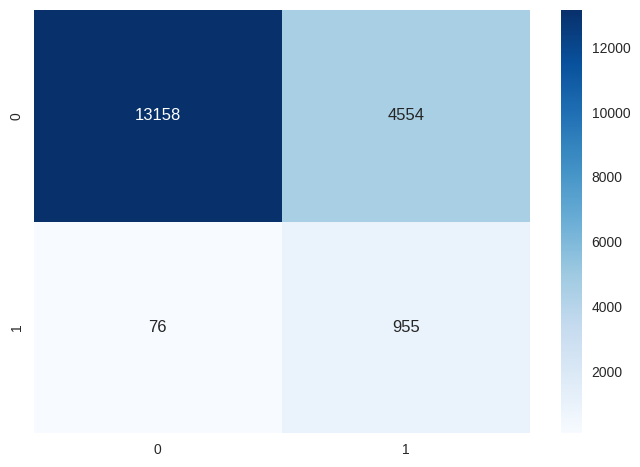

In [ ]:
sns.heatmap(cfm, annot=True, cmap='Blues', fmt=".0f")

In [ ]:
y_test.value_counts()

0    4428
1     258
Name: uszkodzony, dtype: int64

In [ ]:
y_test_pred = lr.predict(X_test_processed)

In [ ]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.73      0.84      4428
           1       0.15      0.82      0.26       258

    accuracy                           0.74      4686
   macro avg       0.57      0.78      0.55      4686
weighted avg       0.94      0.74      0.81      4686



In [ ]:
cfm_test = confusion_matrix(y_test, y_test_pred)
cfm_test

array([[3250, 1178],
       [  47,  211]])

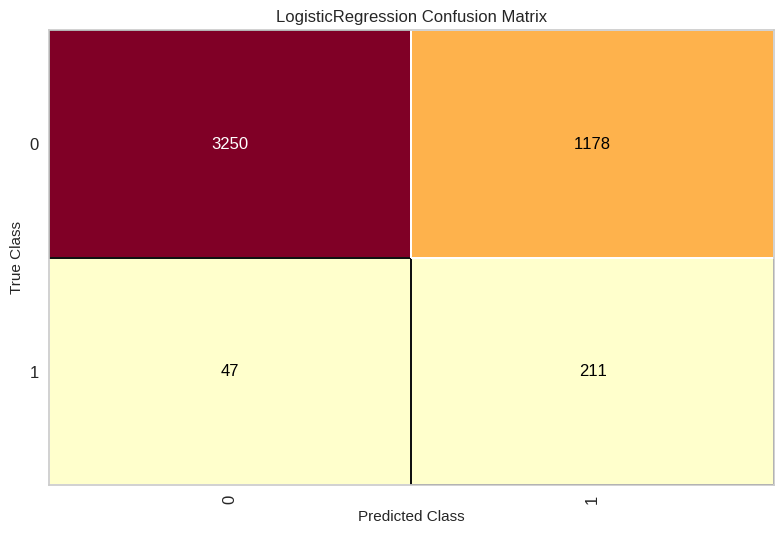

<Figure size 800x550 with 0 Axes>

In [ ]:
from yellowbrick.classifier import confusion_matrix as yb_confusion_matrix

yb_confusion_matrix(
    lr,
    X_train_processed, y_train, X_test_processed, y_test,
)
plt.tight_layout()

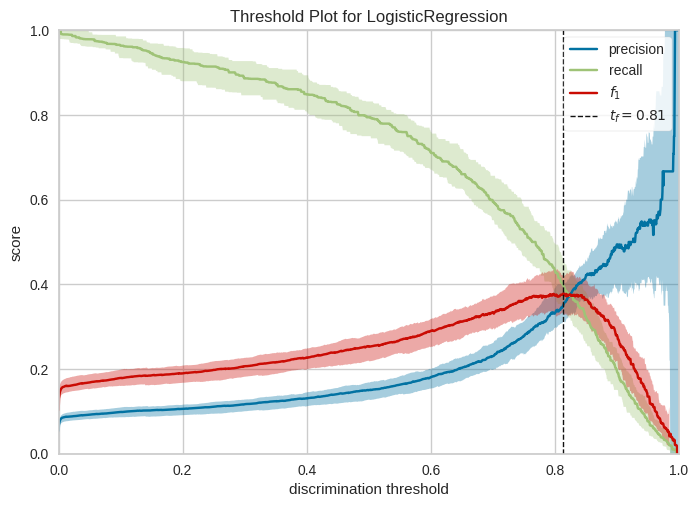

<Axes: title={'center': 'Threshold Plot for LogisticRegression'}, xlabel='discrimination threshold', ylabel='score'>

In [ ]:
# przecięci precision i recall
# https://www.scikit-yb.org/en/latest/api/classifier/threshold.html

from yellowbrick.classifier import DiscriminationThreshold

visualizer = DiscriminationThreshold(lr, exclude='queue_rate')

visualizer.fit(X_train_processed, y_train)        # Fit the data to the visualizer
visualizer.show()


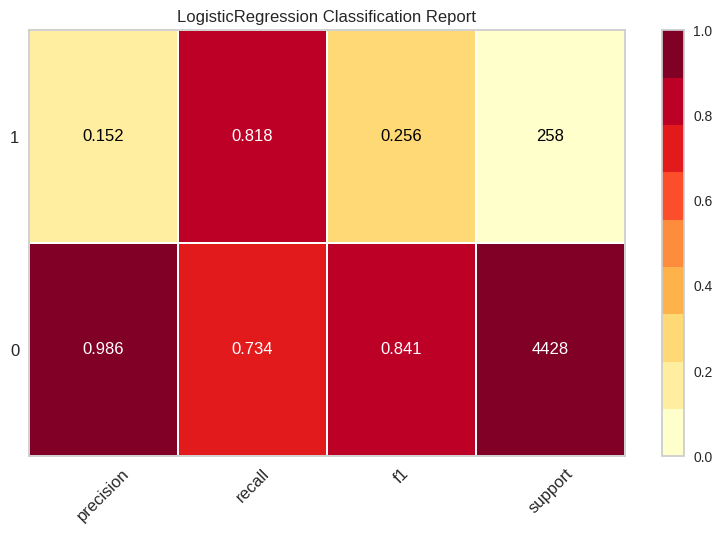

In [ ]:
# https://www.scikit-yb.org/en/latest/api/classifier/classification_report.html
from yellowbrick.classifier import classification_report as yb_classification_report

visualizer = yb_classification_report(
    lr, X_train_processed, y_train, X_test_processed, y_test, support=True
)

In [ ]:
cf.get_feature_names_out()

/usr/local/lib/python3.10/dist-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


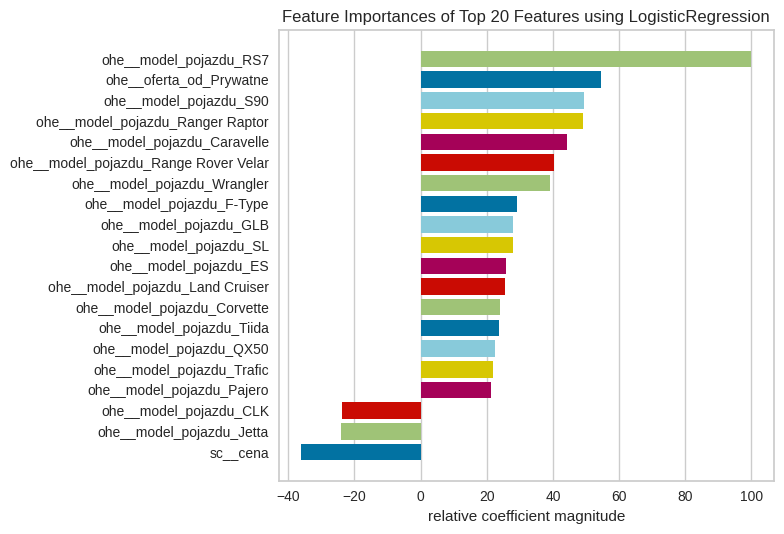

<Axes: title={'center': 'Feature Importances of Top 20 Features using LogisticRegression'}, xlabel='relative coefficient magnitude'>

In [ ]:
#from yellowbrick.model_selection import FeatureImportances

labels = cf.get_feature_names_out()
viz = FeatureImportances(lr, labels=labels, topn=20)
viz.fit(X_train_processed, y_train)
viz.show()

In [ ]:
eda_df.loc[X_train[X_train['model_pojazdu'] == 'RS7'].index]

marka_pojazdu model_pojazdu  rok_produkcji  pojemność_skokowa    moc  \
882            Audi           RS7         2015.0             3996.0  630.0   
646            Audi           RS7         2017.0             3993.0  605.0   
9104           Audi           RS7         2020.0             3996.0  600.0   
19957          Audi           RS7         2013.0             3993.0  560.0   
22725          Audi           RS7         2021.0             3996.0  600.0   

       przebieg rodzaj_paliwa skrzynia_biegów        napęd      cena  \
882       55000       Benzyna    Automatyczna  4x4 (stały)  225000.0   
646      159000       Benzyna    Automatyczna  4x4 (stały)  275000.0   
9104      47900       Benzyna    Automatyczna  4x4 (stały)  469000.0   
19957    175000       Benzyna    Automatyczna  4x4 (stały)  199888.0   
22725     24955       Benzyna    Automatyczna  4x4 (stały)  405000.0   

      typ_nadwozia  liczba_drzwi  liczba_miejsc       kolor      leasing  \
882          Coupe           5.0            4.0     Srebrny  brak_danych   
646          Coupe           5.0            4.0   Granatowy  brak_danych   
9104       Kompakt           5.0            5.0       Szary  brak_danych   
19957        Sedan           5.0            4.0       Szary  brak_danych   
22725      Kompakt           5.0            5.0  Inny kolor  brak_danych   

      oferta_od  uszkodzony  
882    Prywatne           0  
646    Prywatne           0  
9104   Prywatne           0  
19957  Prywatne           0  
22725  Prywatne           1

#### GridSearchCV LogisticRegression

In [ ]:
class_weight

{0: 1, 1: 20.0}

In [ ]:
lr_model = LogisticRegression(max_iter=10000, class_weight=class_weight)

In [ ]:
lr_params = {'penalty': ['l1', 'l2'],
             'C': np.logspace(-4, 4, 4),
               }

In [ ]:
gs_lr_model = GridSearchCV(estimator=lr_model,
                           param_grid = lr_params,
                           n_jobs=4,
                           cv=10,
                           verbose=3,
                           scoring='recall')

In [ ]:
gs_lr_model.fit(X_train_processed, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

GridSearchCV(cv=10,
             estimator=LogisticRegression(class_weight={0: 1, 1: 20.0},
                                          max_iter=10000),
             n_jobs=4,
             param_grid={'C': array([1.00000000e-04, 4.64158883e-02, 2.15443469e+01, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']},
             scoring='recall', verbose=3)

In [ ]:
gs_lr_model.best_params_

{'C': 0.046415888336127774, 'penalty': 'l2'}

In [ ]:
y_train_gs_lr_pred = gs_lr_model.predict(X_train_processed)

In [ ]:
print(classification_report(y_train, y_train_gs_lr_pred))

              precision    recall  f1-score   support

           0       0.99      0.67      0.80     17765
           1       0.14      0.90      0.24      1031

    accuracy                           0.68     18796
   macro avg       0.56      0.78      0.52     18796
weighted avg       0.94      0.68      0.77     18796



In [ ]:
y_test_gs_lr_pred = gs_lr_model.predict(X_test_processed)

In [ ]:
print(classification_report(y_test, y_test_gs_lr_pred))

              precision    recall  f1-score   support

           0       0.99      0.69      0.81      4441
           1       0.14      0.89      0.24       258

    accuracy                           0.70      4699
   macro avg       0.57      0.79      0.53      4699
weighted avg       0.94      0.70      0.78      4699



<Axes: >

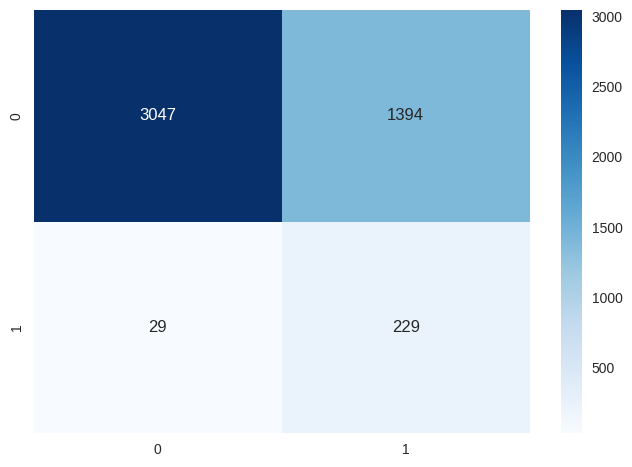

In [ ]:
cfm = confusion_matrix(y_test, y_test_gs_lr_pred)
sns.heatmap(cfm, annot=True, cmap='Blues', fmt=".0f")

### PolynomialFeatures - Regresja logistyczna wielomianowa

In [ ]:
class_weight

{0: 1, 1: 20.0}

In [ ]:
pipe_poly = Pipeline([
                 ('poly', PolynomialFeatures(degree=2, include_bias=False)),
                 ('lr', LogisticRegression(max_iter=10000, C=100, class_weight=class_weight))
                 ])

In [ ]:
pipe_poly.fit(X_train_processed, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('lr',
                 LogisticRegression(C=100, class_weight={0: 1, 1: 20.0},
                                    max_iter=10000))])

In [ ]:
y_train_poly_pred = pipe_poly.predict(X_train_processed)

In [ ]:
print(classification_report(y_train, y_train_poly_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     17765
           1       0.45      0.99      0.62      1031

    accuracy                           0.93     18796
   macro avg       0.73      0.96      0.79     18796
weighted avg       0.97      0.93      0.94     18796



In [ ]:
y_test_poly_pred = pipe_poly.predict(X_test_processed)

In [ ]:
print(classification_report(y_test, y_test_poly_pred))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94      4441
           1       0.29      0.63      0.40       258

    accuracy                           0.90      4699
   macro avg       0.63      0.77      0.67      4699
weighted avg       0.94      0.90      0.91      4699



<Axes: >

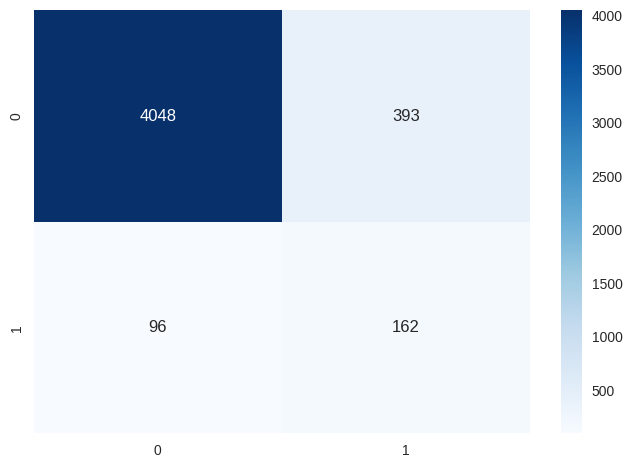

In [ ]:
cfm = confusion_matrix(y_test, y_test_poly_pred)
sns.heatmap(cfm, annot=True, cmap='Blues', fmt=".0f")

In [ ]:
pipe_poly = Pipeline([
                 ('poly', PolynomialFeatures(include_bias=False)),
                 ('lr', LogisticRegression(max_iter=10000, class_weight=class_weight))
                 ])



pipe_poly_params = {'poly__degree': np.arange(1,3),
               'lr__C': np.logspace(-3, 1, 4),
               }

In [ ]:
gs = GridSearchCV(estimator=pipe_poly,
                  param_grid = pipe_poly_params,
                  n_jobs=4,
                  cv=10,
                  verbose=3,
                  scoring='f1')

In [ ]:
gs.fit(X_train_processed, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(include_bias=False)),
                                       ('lr',
                                        LogisticRegression(class_weight={0: 1,
                                                                         1: 20.0},
                                                           max_iter=10000))]),
             n_jobs=4,
             param_grid={'lr__C': array([1.00000000e-03, 2.15443469e-02, 4.64158883e-01, 1.00000000e+01]),
                         'poly__degree': array([1, 2])},
             scoring='f1', verbose=3)

In [ ]:
gs.best_params_

{'lr__C': 10.0, 'poly__degree': 2}

In [ ]:
y_train_gs_pred = gs.predict(X_train_processed)

In [ ]:
print(classification_report(y_train, y_train_gs_pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     17765
           1       0.41      0.98      0.58      1031

    accuracy                           0.92     18796
   macro avg       0.71      0.95      0.77     18796
weighted avg       0.97      0.92      0.94     18796



In [ ]:
y_test_gs_pred = gs.predict(X_test_processed)

In [ ]:
print(classification_report(y_test, y_test_gs_pred))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94      4441
           1       0.29      0.66      0.40       258

    accuracy                           0.89      4699
   macro avg       0.63      0.78      0.67      4699
weighted avg       0.94      0.89      0.91      4699



<Axes: >

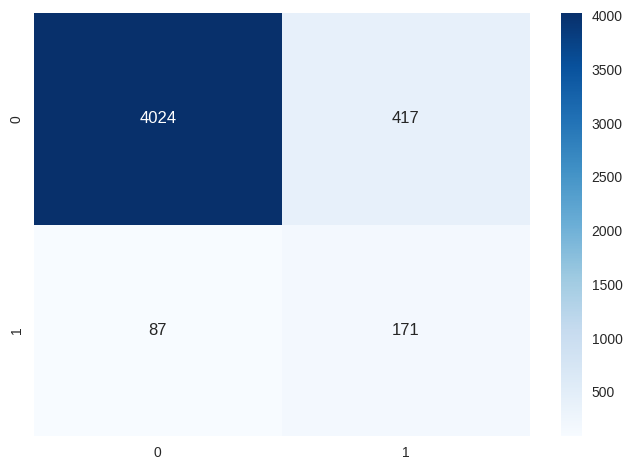

In [ ]:
cfm = confusion_matrix(y_test, y_test_gs_pred)
sns.heatmap(cfm, annot=True, cmap='Blues', fmt=".0f")

### SVM/SVC

#### Kernel liniowy

In [ ]:
class_weight

{0: 1, 1: 20.0}

In [ ]:
svc_model = SVC(kernel='linear', probability=True, class_weight=class_weight)

In [ ]:
svc_model.fit(X_train_processed, y_train)

SVC(class_weight={0: 1, 1: 20.0}, kernel='linear', probability=True)

In [ ]:
y_train_svc_pred = svc_model.predict(X_train_processed)

In [ ]:
print(classification_report(y_true=y_train, y_pred=y_train_svc_pred))

              precision    recall  f1-score   support

           0       0.99      0.63      0.77     17765
           1       0.12      0.90      0.22      1031

    accuracy                           0.64     18796
   macro avg       0.56      0.76      0.49     18796
weighted avg       0.94      0.64      0.74     18796



In [ ]:
y_test_svc_pred = svc_model.predict(X_test_processed)

In [ ]:
print(classification_report(y_true=y_test, y_pred=y_test_svc_pred))

              precision    recall  f1-score   support

           0       0.99      0.64      0.78      4441
           1       0.13      0.88      0.22       258

    accuracy                           0.66      4699
   macro avg       0.56      0.76      0.50      4699
weighted avg       0.94      0.66      0.75      4699



<Axes: >

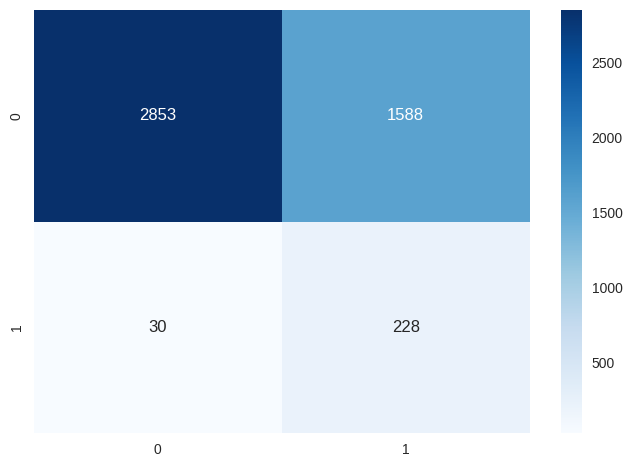

In [ ]:
cfm = confusion_matrix(y_test, y_test_svc_pred)
sns.heatmap(cfm, annot=True, cmap='Blues', fmt=".0f")

#### Kernel wielomianowy

In [ ]:
class_weight

{0: 1, 1: 20.0}

In [ ]:
svc_poly_model = SVC(kernel='poly', probability=True, class_weight=class_weight)

In [ ]:
svc_poly_model.fit(X_train_processed, y_train)

SVC(class_weight={0: 1, 1: 20.0}, kernel='poly', probability=True)

In [ ]:
y_train_svc_poly_pred = svc_poly_model.predict(X_train_processed)

In [ ]:
print(classification_report(y_train, y_train_svc_poly_pred))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95     17765
           1       0.36      0.98      0.53      1031

    accuracy                           0.90     18796
   macro avg       0.68      0.94      0.74     18796
weighted avg       0.96      0.90      0.92     18796



In [ ]:
y_test_svc_poly_pred = svc_poly_model.predict(X_test_processed)

In [ ]:
print(classification_report(y_test, y_test_svc_poly_pred))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      4441
           1       0.28      0.70      0.40       258

    accuracy                           0.89      4699
   macro avg       0.63      0.80      0.67      4699
weighted avg       0.94      0.89      0.91      4699



<Axes: >

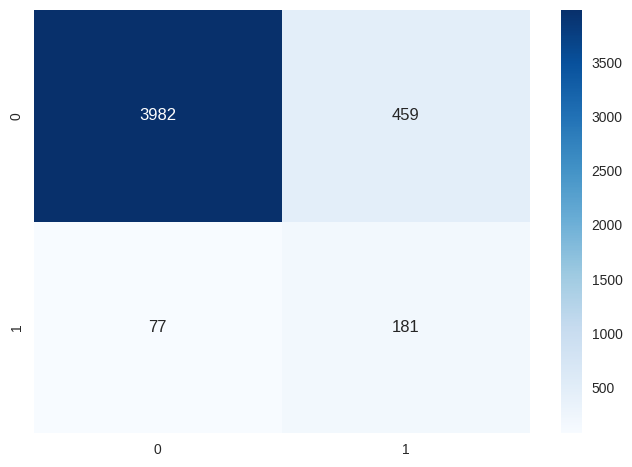

In [ ]:
cfm = confusion_matrix(y_test, y_test_svc_poly_pred)
sns.heatmap(cfm, annot=True, cmap='Blues', fmt=".0f")

##### GridSearchCV kernel='poly'

In [ ]:
pipe_poly = Pipeline([
                 ('svc', SVC(kernel='poly', probability=True, class_weight=class_weight))
                 ])

In [ ]:
param_grid_poly = {
                    "svc__degree": np.arange(1,4),
                    "svc__C": np.logspace(-2, 1, 3),

}

In [ ]:
gs_poly = GridSearchCV(pipe_poly,
                  param_grid_poly,
                  n_jobs=4,
                  cv=5,
                  verbose=3,
                  scoring = 'recall')

In [ ]:
# Conclusions
'''
The obtained models result are not satisfactory.
In my opinion, this is due to the seller's subjective assessment of the damage.
For example, for some sellers, the damage may be a slightly dented bumper or for other sellers, a car leaking oil may be assessed as undamaged.
There may be various reasons for car damage.
For example, damage resulting from negligence, road traffic collision or other accident.

To improve the performance of the models, you can assess the damage to the car based on the description and photos.




Uzyskane wyniki modeli nie są zadowalające.
Moim zdaniem wynika to z subiektywnej oceny uszkodzenia dokonanej przez sprzedawcę.
Np. dla niektórych sprzedających uszkodzeniem może być lekko wgnieciony zderzak
lub
dla innych sprzedających auto z którego cieknie olej może być ocenione jako nieuszkodzone.

Przyczyny uszkodzenia samochodu mogą być różne.
Na przykład uszkodzenia wynikające z zaniedbania, kolizji drogowej lub innego wypadku.

Aby poprawić wydajność modeli, można ocenić uszkodzenia samochodu na podstawie opisu i zdjęć.
'''



In [ ]:
gs_poly.fit(X_train_processed, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('svc',
                                        SVC(class_weight={0: 1, 1: 20.0},
                                            kernel='poly',
                                            probability=True))]),
             n_jobs=4,
             param_grid={'svc__C': array([ 0.01      ,  0.31622777, 10.        ]),
                         'svc__degree': array([1, 2, 3])},
             scoring='recall', verbose=3)

In [ ]:
gs_poly.best_params_

{'svc__C': 0.01, 'svc__degree': 1}

In [ ]:
y_train_gs_poly_pred = gs_poly.predict(X_train_processed)

In [ ]:
print(classification_report(y_train, y_train_gs_poly_pred))

              precision    recall  f1-score   support

           0       0.99      0.50      0.67     17765
           1       0.10      0.95      0.18      1031

    accuracy                           0.53     18796
   macro avg       0.55      0.73      0.43     18796
weighted avg       0.95      0.53      0.64     18796



In [ ]:
y_test_gs_poly_pred = gs_poly.predict(X_test_processed)

In [ ]:
print(classification_report(y_test, y_test_gs_poly_pred))

              precision    recall  f1-score   support

           0       0.99      0.52      0.68      4441
           1       0.10      0.93      0.18       258

    accuracy                           0.54      4699
   macro avg       0.55      0.73      0.43      4699
weighted avg       0.94      0.54      0.66      4699



<Axes: >

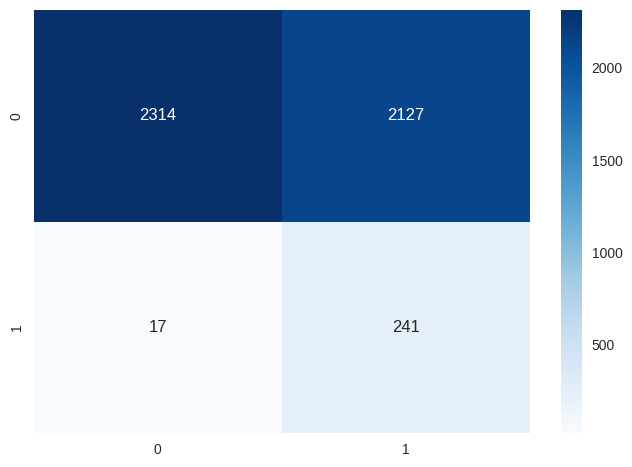

In [ ]:
cfm = confusion_matrix(y_test, y_test_gs_poly_pred)
sns.heatmap(cfm, annot=True, cmap='Blues', fmt=".0f")

#### Kernel RBF

In [ ]:
class_weight

{0: 1, 1: 20.0}

In [ ]:
svc_rbf_model = SVC(kernel='rbf', probability=True, class_weight=class_weight)

In [ ]:
svc_rbf_model.fit(X_train_processed, y_train)

SVC(class_weight={0: 1, 1: 20.0}, probability=True)

In [ ]:
y_train_svc_rbf_pred = svc_rbf_model.predict(X_train_processed)

In [ ]:
print(classification_report(y_train, y_train_svc_rbf_pred))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94     17765
           1       0.35      0.97      0.51      1031

    accuracy                           0.90     18796
   macro avg       0.67      0.93      0.73     18796
weighted avg       0.96      0.90      0.92     18796



In [ ]:
y_test_svc_rbf_pred = svc_rbf_model.predict(X_test_processed)

In [ ]:
print(classification_report(y_test, y_test_svc_rbf_pred))

              precision    recall  f1-score   support

           0       0.98      0.89      0.94      4441
           1       0.29      0.73      0.41       258

    accuracy                           0.89      4699
   macro avg       0.64      0.81      0.67      4699
weighted avg       0.94      0.89      0.91      4699



<Axes: >

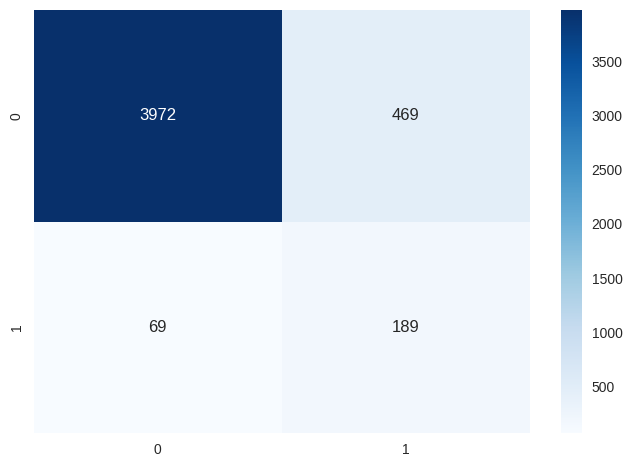

In [ ]:
cfm = confusion_matrix(y_test, y_test_svc_rbf_pred)
sns.heatmap(cfm, annot=True, cmap='Blues', fmt=".0f")

<Axes: >

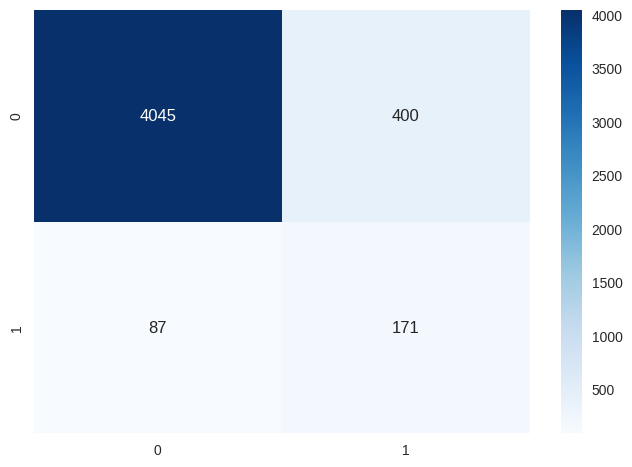

In [ ]:
# poprzednie (z modelami aut)
cfm = confusion_matrix(y_test, y_test_svc_rbf_pred)
sns.heatmap(cfm, annot=True, cmap='Blues', fmt=".0f")

In [ ]:
# best?

In [ ]:
labels = cf.get_feature_names_out()
viz = FeatureImportances(svc_rbf_model, labels=labels, topn=20)
viz.fit(X_train_processed, y_train)
viz.show()

YellowbrickTypeError: ignored

### KNN

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)

In [ ]:
knn.fit(X_train_processed, y_train)

KNeighborsClassifier(n_neighbors=10)

In [ ]:
y_train_knn_pred = knn.predict(X_train_processed)

In [ ]:
print(classification_report(y_train, y_train_knn_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     17777
           1       0.80      0.00      0.01      1031

    accuracy                           0.95     18808
   macro avg       0.87      0.50      0.49     18808
weighted avg       0.94      0.95      0.92     18808



In [ ]:
y_test_knn_pred = knn.predict(X_test_processed)

In [ ]:
print(classification_report(y_test, y_test_knn_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4444
           1       0.00      0.00      0.00       258

    accuracy                           0.94      4702
   macro avg       0.47      0.50      0.49      4702
weighted avg       0.89      0.94      0.92      4702



<Axes: >

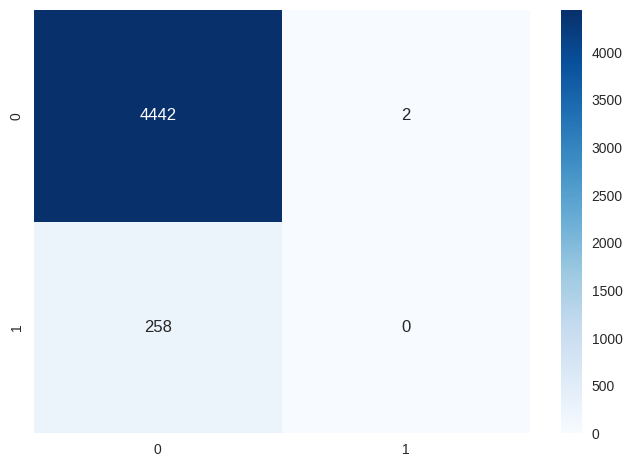

In [ ]:
cfm = confusion_matrix(y_test, y_test_knn_pred)
sns.heatmap(cfm, annot=True, cmap='Blues', fmt=".0f")

### GaussianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
gnb = GaussianNB()

In [ ]:
gnb.fit(X_train_processed.toarray(), y_train)

GaussianNB()

In [ ]:
y_train_gnb_pred = gnb.predict(X_train_processed.toarray())

In [ ]:
print(classification_report(y_train, y_train_gnb_pred))

              precision    recall  f1-score   support

           0       1.00      0.47      0.64     17777
           1       0.10      1.00      0.18      1031

    accuracy                           0.50     18808
   macro avg       0.55      0.73      0.41     18808
weighted avg       0.95      0.50      0.61     18808



In [ ]:
y_test_gnb_pred = gnb.predict(X_test_processed.toarray())

In [ ]:
print(classification_report(y_test, y_test_gnb_pred))

              precision    recall  f1-score   support

           0       0.98      0.47      0.64      4444
           1       0.09      0.84      0.16       258

    accuracy                           0.49      4702
   macro avg       0.53      0.66      0.40      4702
weighted avg       0.93      0.49      0.61      4702



<Axes: >

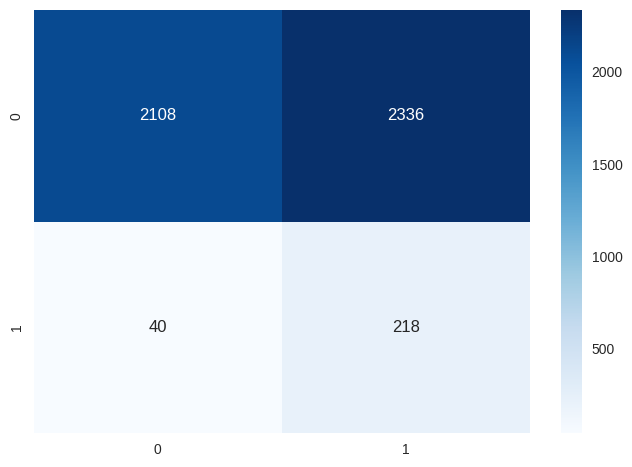

In [ ]:
cfm = confusion_matrix(y_test, y_test_gnb_pred)
sns.heatmap(cfm, annot=True, cmap='Blues', fmt=".0f")

### DecisionTreeClassifier

In [ ]:
#from sklearn.tree import DecisionTreeClassifier

In [ ]:
class_weight

{0: 1, 1: 20.0}

In [ ]:
dtc= DecisionTreeClassifier(criterion='entropy', random_state=0, class_weight=class_weight)

In [ ]:
gs_dtc_params = {'max_depth': np.arange(2, 10),
                 'min_samples_split': np.arange(5, 10),
                 'min_samples_leaf': np.arange(5, 10)}


In [ ]:
gs_dtc = GridSearchCV(dtc,
                  gs_dtc_params,
                  n_jobs=4,
                  cv=5,
                  verbose=3,
                  scoring = 'f1')

In [ ]:
gs_dtc.fit(X_train_processed, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight={0: 1, 1: 20.0},
                                              criterion='entropy',
                                              random_state=0),
             n_jobs=4,
             param_grid={'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_leaf': array([5, 6, 7, 8, 9]),
                         'min_samples_split': array([5, 6, 7, 8, 9])},
             scoring='f1', verbose=3)

In [ ]:
gs_dtc.best_params_

{'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 5}

In [ ]:
y_train_gs_dtc_pred = gs_dtc.predict(X_train_processed)

In [ ]:
print(classification_report(y_train, y_train_gs_dtc_pred))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91     17777
           1       0.23      0.81      0.35      1031

    accuracy                           0.84     18808
   macro avg       0.61      0.82      0.63     18808
weighted avg       0.95      0.84      0.88     18808



In [ ]:
y_test_gs_dtc_pred = gs_dtc.predict(X_test_processed)

In [ ]:
print(classification_report(y_test, y_test_gs_dtc_pred))

              precision    recall  f1-score   support

           0       0.98      0.84      0.90      4444
           1       0.20      0.70      0.31       258

    accuracy                           0.83      4702
   macro avg       0.59      0.77      0.61      4702
weighted avg       0.94      0.83      0.87      4702



<Axes: >

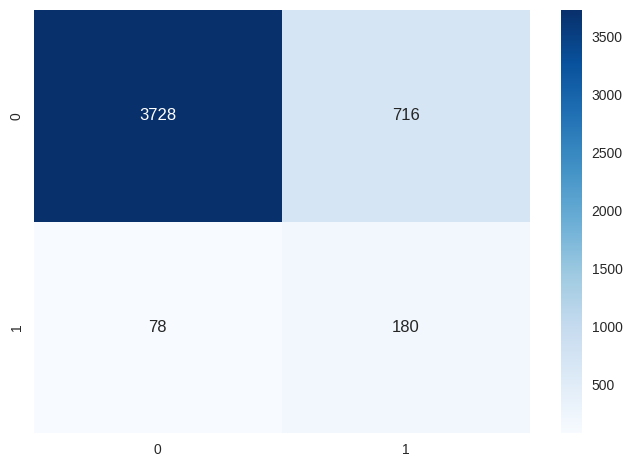

In [ ]:
cfm = confusion_matrix(y_test, y_test_gs_dtc_pred)
sns.heatmap(cfm, annot=True, cmap='Blues', fmt=".0f")

### BaggingClassifier

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
bg = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight=class_weight),
                       n_estimators=100)

In [ ]:
bg.fit(X_train_processed, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(class_weight={0: 1,
                                                                 1: 20.0}),
                  n_estimators=100)

In [ ]:
y_train_bg_pred = bg.predict(X_train_processed)

In [ ]:
print(classification_report(y_train, y_train_bg_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17780
           1       1.00      1.00      1.00      1031

    accuracy                           1.00     18811
   macro avg       1.00      1.00      1.00     18811
weighted avg       1.00      1.00      1.00     18811



In [ ]:
# spr X_test
y_test_bg_pred = bg.predict(X_test_processed)

In [ ]:
print(classification_report(y_test, y_test_bg_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      4445
           1       0.73      0.36      0.48       258

    accuracy                           0.96      4703
   macro avg       0.85      0.67      0.73      4703
weighted avg       0.95      0.96      0.95      4703



<Axes: >

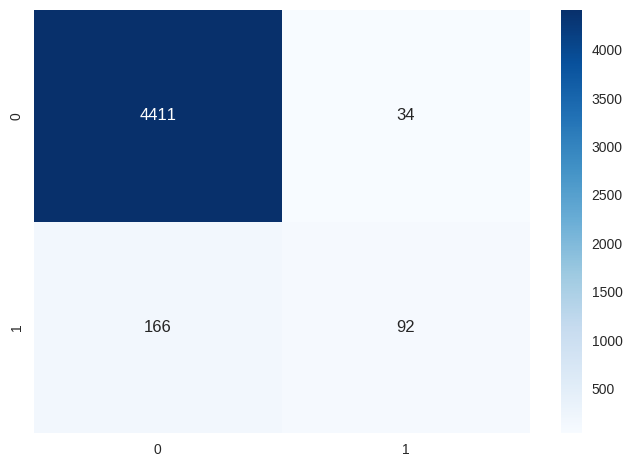

In [ ]:
cfm = confusion_matrix(y_test, y_test_bg_pred)
sns.heatmap(cfm, annot=True, cmap='Blues', fmt=".0f")

#### GridSearchCV BaggingClassifier

In [ ]:
class_weight

{0: 1, 1: 20.0}

In [ ]:
bg = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight=class_weight),
                       n_estimators=100)

In [ ]:
# https://stackoverflow.com/questions/54543612/grid-search-on-parameters-inside-the-parameters-of-a-baggingclassifier
gs_bg_params = { #'bootstrap': [True, False],
                 #'bootstrap_features': [True, False],
                 #'n_estimators': [5, 10, 15],
                'base_estimator__max_depth': np.arange(2, 10),
                'base_estimator__min_samples_split': np.arange(5, 10),
                'base_estimator__min_samples_leaf': np.arange(5, 10)}

In [ ]:
gs_bg = GridSearchCV(bg,
                  gs_bg_params,
                  n_jobs=4,
                  cv=5,
                  verbose=3,
                  scoring = 'recall')

In [ ]:
gs_bg.fit(X_train_processed, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:905: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  clone(base_estimator).set_params(**self.best_params_)


GridSearchCV(cv=5,
             estimator=BaggingClassifier(estimator=DecisionTreeClassifier(class_weight={0: 1,
                                                                                        1: 20.0}),
                                         n_estimators=100),
             n_jobs=4,
             param_grid={'base_estimator__max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'base_estimator__min_samples_leaf': array([5, 6, 7, 8, 9]),
                         'base_estimator__min_samples_split': array([5, 6, 7, 8, 9])},
             scoring='recall', verbose=3)

In [ ]:
gs_bg.best_params_

{'base_estimator__max_depth': 2,
 'base_estimator__min_samples_leaf': 5,
 'base_estimator__min_samples_split': 6}

In [ ]:
y_train_gs_bg_pred = gs_bg.predict(X_train_processed)

In [ ]:
print(classification_report(y_train, y_train_gs_bg_pred))

              precision    recall  f1-score   support

           0       1.00      0.35      0.51     17780
           1       0.08      1.00      0.15      1031

    accuracy                           0.38     18811
   macro avg       0.54      0.67      0.33     18811
weighted avg       0.95      0.38      0.49     18811



In [ ]:
y_test_gs_bg_pred = gs_bg.predict(X_test_processed)

In [ ]:
print(classification_report(y_test, y_test_gs_bg_pred))

              precision    recall  f1-score   support

           0       1.00      0.36      0.53      4445
           1       0.08      1.00      0.15       258

    accuracy                           0.39      4703
   macro avg       0.54      0.68      0.34      4703
weighted avg       0.95      0.39      0.51      4703



<Axes: >

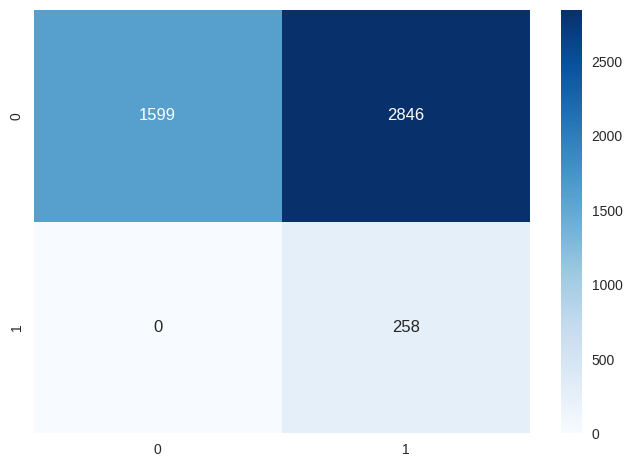

In [ ]:
cfm = confusion_matrix(y_test, y_test_gs_bg_pred)
sns.heatmap(cfm, annot=True, cmap='Blues', fmt=".0f")

## RandomForestClassifier - Lasy losowe

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

In [ ]:
#class_weight = {0: 0.1, 1: 1.0}
class_weight

{0: 1, 1: 20.0}

In [ ]:
rfc = RandomForestClassifier(class_weight=class_weight)

In [ ]:
gs_rfc_params = {
                 'max_depth' : np.arange(2, 5),
                 'min_samples_split': np.arange(2, 11),
                 'min_samples_leaf': np.arange(2, 11),
                 'n_estimators': [10, 20, 30]
                 }

In [ ]:
gs_rfc = GridSearchCV(rfc,
                      gs_rfc_params,
                      n_jobs=4,
                      cv=5,
                      verbose=3,
                      #scoring = 'recall')
                      scoring = 'f1')

In [ ]:
gs_rfc.fit(X_train_processed, y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={0: 1, 1: 20.0}),
             n_jobs=4,
             param_grid={'max_depth': array([2, 3, 4]),
                         'min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'n_estimators': [10, 20, 30]},
             scoring='f1', verbose=3)

In [ ]:
# 26.10.2023  00:54
gs_rfc.best_params_

{'max_depth': 4,
 'min_samples_leaf': 9,
 'min_samples_split': 3,
 'n_estimators': 20}

In [ ]:
y_train_gs_rfc_pred = gs_rfc.predict(X_train_processed)

In [ ]:
print(classification_report(y_train, y_train_gs_rfc_pred))

              precision    recall  f1-score   support

           0       0.99      0.47      0.64     17780
           1       0.09      0.89      0.16      1031

    accuracy                           0.50     18811
   macro avg       0.54      0.68      0.40     18811
weighted avg       0.94      0.50      0.61     18811



<Axes: >

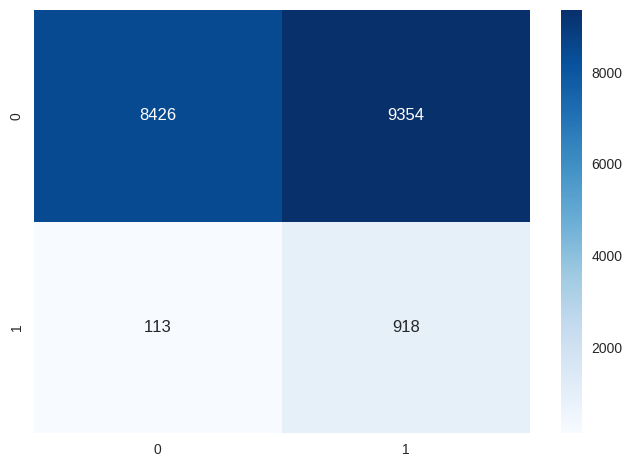

In [ ]:
cfm = confusion_matrix(y_train, y_train_gs_rfc_pred)
sns.heatmap(cfm, annot=True, cmap='Blues', fmt=".0f")

In [ ]:
# X_test
y_test_gs_rfc_pred = gs_rfc.predict(X_test_processed)

In [ ]:
print(classification_report(y_test, y_test_gs_rfc_pred))

              precision    recall  f1-score   support

           0       0.99      0.48      0.64      4445
           1       0.09      0.91      0.17       258

    accuracy                           0.50      4703
   macro avg       0.54      0.69      0.40      4703
weighted avg       0.94      0.50      0.62      4703



<Axes: >

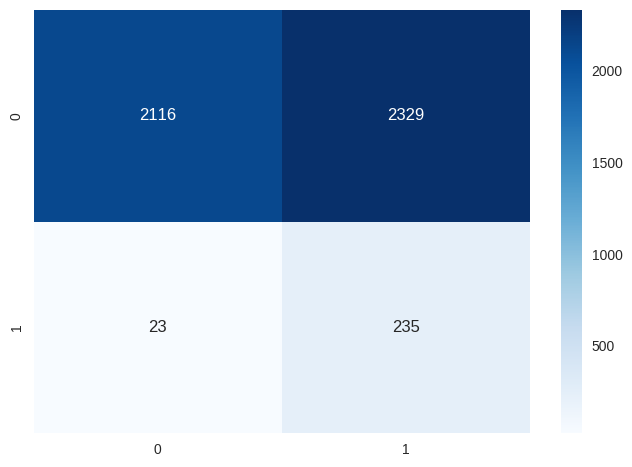

In [ ]:
cfm = confusion_matrix(y_test, y_test_gs_rfc_pred)
sns.heatmap(cfm, annot=True, cmap='Blues', fmt=".0f")

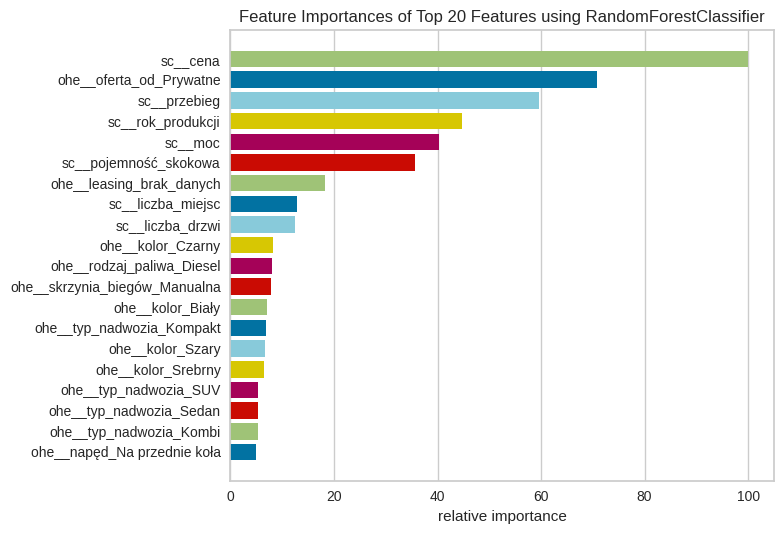

<Axes: title={'center': 'Feature Importances of Top 20 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [ ]:
labels = cf.get_feature_names_out()
viz = FeatureImportances(rfc, labels=labels, topn=20)
viz.fit(X_train_processed, y_train)
viz.show()

## Boosting

In [ ]:
# AdaBoost
# drzewo uczy się na błędnych predykcjach poprzedzającego drzewa
# dość płytkie (mała ilość podziałów)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
class_weight

{0: 1, 1: 20.0}

In [ ]:
dtc= DecisionTreeClassifier(criterion='entropy', random_state=0, class_weight=class_weight)

abc = AdaBoostClassifier(estimator=dtc,
                         n_estimators=10)
                         #larning_rate # ile zwiększać wagi źle sklasyfikowanych próbek

In [ ]:
abc.fit(X_train_processed, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight={0: 1,
                                                                  1: 20.0},
                                                    criterion='entropy',
                                                    random_state=0),
                   n_estimators=10)

In [ ]:
y_train_abc_pred = abc.predict(X_train_processed)

In [ ]:
print(classification_report(y_train, y_train_abc_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17780
           1       1.00      1.00      1.00      1031

    accuracy                           1.00     18811
   macro avg       1.00      1.00      1.00     18811
weighted avg       1.00      1.00      1.00     18811



In [ ]:
y_test_abc_pred = abc.predict(X_test_processed)

In [ ]:
print(classification_report(y_test, y_test_abc_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4445
           1       0.42      0.44      0.43       258

    accuracy                           0.94      4703
   macro avg       0.69      0.70      0.70      4703
weighted avg       0.94      0.94      0.94      4703



<Axes: >

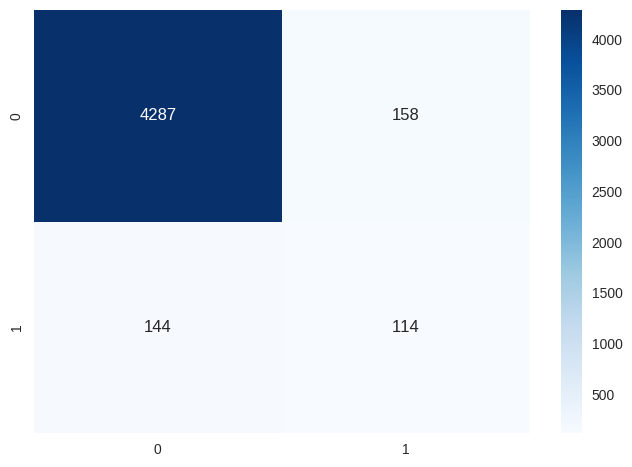

In [ ]:
cfm = confusion_matrix(y_test, y_test_abc_pred)
sns.heatmap(cfm, annot=True, cmap='Blues', fmt=".0f")

In [ ]:
# https://www.scikit-yb.org/en/latest/api/model_selection/importances.html

In [ ]:
from yellowbrick.model_selection import FeatureImportances

# Load the classification data set
X, y = load_occupancy()

model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(model)
viz.fit(X, y)
viz.show()